In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import copy
from matplotlib import colors
from sklearn import tree
#import skfda
#from sklearn import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import timeshap
from timeshap.explainer import event_level, feature_level

import seaborn as sns
from scipy import stats
from scipy.stats import truncnorm
import scipy.signal
#import cartopy.crs as ccrs
#import cartopy.io.shapereader as shpreader

import torch
import torch.nn as nn
import torch.optim as optim
#import torchvision
#import torch.nn.functional as F
#from torch.utils.data import TensorDataset, DataLoader, random_split
#import torchinfo

import warnings
import os
from copy import deepcopy

import plotting
import dataset_fctns
import modelling_fctns
from ML_fctns import *
import sys
sys.path.append("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\optimisation_experiments")
from optimise_GDD_fctns import *

from datetime import datetime
from dateutil.relativedelta import relativedelta
#from suntimes import SunTimes  

c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\optimisation_experiments\optimise_GDD_fctns.py:34: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


In [2]:
skip = 1
numsteps = int(163 // skip)
ds_inputs_DE1 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_2001_2024_full.csv')
ds_inputs_DE1[[f't2max at day {skip*n}' for n in range(numsteps)]] += -273.15
ds_inputs_DE1[[f't2min at day {skip*n}' for n in range(numsteps)]] += -273.15
ds_inputs_DE2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_90s.csv')

ds_inputs_DE = pd.concat([ds_inputs_DE1, ds_inputs_DE2], axis = 0)
#ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]], 7, 28, 42)
ds_inputs_DE=ds_inputs_DE.rename(columns={'Referenzjahr':'year'})
print(len(ds_inputs_DE))
ds_inputs_DE = ds_inputs_DE.dropna(how='all')
print(len(ds_inputs_DE))
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'] < 140]
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'] > 40]
new_series = []
ds_inputs_DE.loc[:, [f't2max at day {skip*n}' for n in range(numsteps)]] = ds_inputs_DE.loc[:, [f't2max at day {skip*n}' for n in range(numsteps)]].values - ds_inputs_DE.loc[:, [f't2m at day {skip*n}' for n in range(numsteps)]].values
ds_inputs_DE.loc[:, [f't2min at day {skip*n}' for n in range(numsteps)]] = ds_inputs_DE.loc[:, [f't2m at day {skip*n}' for n in range(numsteps)]].values - ds_inputs_DE.loc[:, [f't2min at day {skip*n}' for n in range(numsteps)]].values
for variable_name in ['t2m', 't2max', 't2min', 'photoperiod', 'vpd']: #, 'ssrd', 'tp'
    data = ds_inputs_DE[[f'{variable_name} at day {skip*n}' for n in range(numsteps)]].values
    #if variable_name != 't2m' and variable_name != 'photoperiod':
    #    scaler = StandardScaler()
    #    scaler.fit(data)
    #    data = scaler.transform(data)
    new_variable_series = torch.Tensor(data)
    new_series.append(new_variable_series)

day_series_DE = torch.Tensor([[(skip*n)/10 for n in range(numsteps)] for count in range(len(ds_inputs_DE))])
year_series_DE = torch.Tensor([ds_inputs_DE['year'].values for count in range(numsteps)]).T
id_series_DE = torch.Tensor([ds_inputs_DE['Stations_id'].values for count in range(numsteps)]).T
temp_NDVI_series_DE = torch.swapaxes(torch.stack((*new_series, day_series_DE, year_series_DE, id_series_DE)), 0, 1)
ds_inputs_DE.loc[:, [f'DTF at day {n}' for n in range(193)]] = np.tile(ds_inputs_DE['observed time to beginning of flowering'].values, (193, 1)).T - np.tile(np.arange(0, 193), (len(ds_inputs_DE),1))
NDVI_labels_DE = torch.Tensor(ds_inputs_DE[[f'dev stage at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype('int64').values)

#NDVI_labels_DE = torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype(int).values).unsqueeze(1)
#NDVI_labels_DE = 100 - torch.Tensor(ds_inputs_DE[[f'DTF at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype('int64').values)
#NDVI_labels_DE = torch.Tensor(ds_inputs_DE[[f'DTF at day {skip*n}' for n in range(numsteps)]].astype('int64').values)

27153
27153


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_12936\71982851.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_34s6o8i12c\croot\libtorch_1751464457133\work\torch\csrc\utils\tensor_new.cpp:257.)
  year_series_DE = torch.Tensor([ds_inputs_DE['year'].values for count in range(numsteps)]).T


In [3]:
def train_test_ds_by_year(x_train, y_train, test_years = [2015, 2016, 2017], year_column = -2, train_proportion = 0.8):
    samples_in_test_years = torch.isin(x_train[:, year_column, 0], torch.Tensor(test_years))
    train_ds = TensorDataset(x_train[~samples_in_test_years, :, :], y_train[~samples_in_test_years, :])
    val_ds = TensorDataset(x_train[samples_in_test_years, :, :], y_train[samples_in_test_years, :])
    return train_ds, val_ds

def train_test_dl_by_year(x_train, y_train, bs = 500, n_channels=1, train_proportion = 0.8, test_years = [2015, 2016, 2017], year_column = -2):
    train_ds, val_ds = train_test_ds_by_year(x_train, y_train, train_proportion = train_proportion, test_years = test_years, year_column = year_column)
    train_dl = DataLoader(train_ds, batch_size=bs)
    val_dl = DataLoader(val_ds, batch_size=bs)
    train_dl = WrappedDataLoader(train_dl, lambda x, y: preprocess(x, y, channels =n_channels))
    val_dl = WrappedDataLoader(val_dl, lambda x, y: preprocess(x, y, channels =n_channels))
    return train_dl, val_dl

In [4]:
def mindex_at_0(tens):
    indices = torch.tile(torch.arange(0, tens.shape[1]).float(), (tens.shape[0], 1))  # Shape: (4, 12)
    tens_rounded = torch.round(tens)
    tensmin = torch.min(torch.abs(tens_rounded), dim=1).values
    indices[(torch.abs(tens).T != tensmin).T] = float('nan')
    masked = torch.where(torch.isnan(indices), torch.full_like(indices, float('inf')), indices)
    result = torch.amin(masked, dim=1)##
    # Optionally: Set -inf back to NaN where all were NaN in the column
    result[result == float('inf')] = float('nan')
    return result

def load_model(savename, model):
    model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
    model_path = os.path.join(model_dir, savename + ".pt")
    checkpoint = torch.load(model_path, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    #print(checkpoint['model_state_dict'])
    return model

def plot_from_saved(savename, model, val_dl, method = 'regression', 
                    bce=False, CNN=False, title = 'fitted vs. observed', 
                    MMD=False, DTF = False, obs_method=False,
                    modify_u0=False, direct_obs = False, RMSE = False):
    model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
    model_path = os.path.join(model_dir, savename + ".pt")
    checkpoint = torch.load(model_path, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    if modify_u0:
        model.u0.data = model.u0.data*3#2.26
    #print(checkpoint['model_state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if method == 'cumulative':
        plot_fitted_observed_cumulative(model, val_dl, bce=bce, CNN=CNN, title=title, MMD=MMD, direct_obs = direct_obs)
    elif method == 'regression':
        plot_fitted_observed_TS(model, val_dl, bce=bce, CNN=CNN, title=title, MMD=MMD, DTF = DTF, obs_method=obs_method, direct_obs = direct_obs, RMSE = RMSE)
    elif method == 'histogram':
        plot_fitted_observed_histogram(model, val_dl, bce=bce, CNN=CNN, title=title, MMD=MMD, DTF = DTF, obs_method=obs_method, direct_obs = direct_obs)
    
def plot_fitted_observed_TS(TS_model, dl, bce=False, CNN=False, title = 'fitted vs. observed', MMD = False, DTF = False, obs_method = False, direct_obs = False, RMSE = False):
    list_logs = []
    list_observed = []
    for xb, yb in dl:
        with torch.no_grad():
            if RMSE:
                list_logs.append(torch.squeeze(TS_model(xb)))# + 4
            elif CNN:
                if MMD:
                    list_logs.append(TS_model(xb)[0])
                else:
                    list_logs.append(TS_model(xb))
            else:
                list_logs.append(TS_model(xb.transpose(1, 2)))
            #print(TS_model(xb.transpose(1, 2)))
        if direct_obs:
            list_observed.append(yb.squeeze())
        else:
            list_observed.append(yb)
    logs = torch.squeeze(torch.cat(list_logs))
    observed = torch.cat(list_observed)
    print(logs.shape, torch.cat(list_logs, dim=0).shape, observed.shape)
    if RMSE:
        fitted_days = logs
    else:
        if not(DTF):
            if bce:
                fitted = torch.round(logs)
            else:
                fitted = torch.argmax(logs, dim=2)
        if DTF:
            logs = torch.round(logs)
            if not(direct_obs):
                observed_days = mindex_at_0(observed)
            #observed_days = observed[:, 0]
            #observed_days = 90 + 100 - observed[:, 90]
            if obs_method:
                fitted_days = observed_days + logs[range(0, logs.shape[0]), observed_days.int()]
            else:
                fitted_days = mindex_at_0(logs)
                #fitted_days = 90 + 100 - logs[:, 90]
                fitted_days = 90 + logs[:, 90]
            print(torch.sum(fitted_days < 30), ' fits too small')
        else:
            L = fitted.shape[1]
            fitted_days = L - fitted.sum(dim=1)
            if not(direct_obs):
                observed_days = L - observed.sum(dim=1)
    if direct_obs:
        observed_days = observed
    comparison_frame = pd.DataFrame({'fitted': fitted_days.numpy().squeeze(), 'observed': observed_days.numpy().squeeze()})
    #comparison_frame = comparison_frame.loc[comparison_frame['fitted'] <= 90]
    maxval = max(comparison_frame['fitted'].max(), comparison_frame['observed'].max())
    minval = min(comparison_frame['fitted'].min(), comparison_frame['observed'].min())
    fig, ax = plt.subplots()
    sns.regplot(x='fitted', y='observed', data = comparison_frame, ax=ax,
                scatter_kws={'alpha':0.5, 's':4},  x_bins=np.arange(minval - 5, maxval + 5, 3))
    ax.plot([minval, maxval], [minval, maxval], linestyle = '--', color='k')
    ax.set_title(title)
    rsquared = r2_score(comparison_frame['observed'], comparison_frame['fitted'])
    print(f'R^2 value for model: {rsquared}')
    bias = comparison_frame['observed'].mean() - comparison_frame['fitted'].mean()
    variance_modelled = comparison_frame[f'fitted'].var()
    print(f'Bias: {bias**2}\nVariance of modelled values: {variance_modelled}')

def plot_fitted_observed_histogram(TS_model, dl, bce=False, CNN=False, title = 'fitted vs. observed', MMD=False, DTF = False, obs_method = False):
    list_logs = []
    list_observed = []
    for xb, yb in dl:
        with torch.no_grad():
            if CNN:
                if MMD:
                    list_logs.append(TS_model(xb)[0])
                else:
                    list_logs.append(TS_model(xb))
            else:
                list_logs.append(TS_model(xb.transpose(1, 2)))
            #print(TS_model(xb.transpose(1, 2)))
        list_observed.append(yb)
    logs = torch.cat(list_logs).squeeze()
    observed = torch.cat(list_observed)
    #print(logs.shape)
    if bce:
        fitted = torch.round(logs)
    else:
        fitted = torch.argmax(logs, dim=2)
    if DTF:
        logs = torch.round(logs)
        observed_days = mindex_at_0(observed)
        observed_days = observed[:, 0]
        observed_days = 90 + 100 - observed[:, 90]
        if obs_method:
            fitted_days = observed_days + logs[range(0, logs.shape[0]), observed_days.int()]
        else:
            fitted_days = mindex_at_0(logs)
            #fitted_days = 90 + logs[:, 90]
            #fitted_days = 90 + 100 - logs[:, 90]
            fitted_days = 90 + logs[:, 90]
        print(torch.sum(fitted_days < 30), ' fits too small')
    else:
        L = fitted.shape[1]
        fitted_days = L - fitted.sum(dim=1)
        observed_days = L - observed.sum(dim=1)
    comparison_frame = pd.DataFrame({'fitted': fitted_days.numpy().squeeze(), 'observed': observed_days.numpy().squeeze()})
    #comparison_frame = comparison_frame.loc[comparison_frame['fitted'] <= 90]
    maxval = max(comparison_frame['fitted'].max(), comparison_frame['observed'].max())
    minval = min(comparison_frame['fitted'].min(), comparison_frame['observed'].min())
    fig, ax = plt.subplots()
    sns.histplot(x='fitted', data = comparison_frame, ax=ax, label = 'fitted',
                stat = 'density', bins=10)
    sns.histplot(x='observed', data = comparison_frame, ax=ax, label= 'observed',
                stat = 'density')
    ax.set_xlabel('Days to anthesis')
    ax.set_title(title)
    #ax.plot([minval, maxval], [minval, maxval], linestyle = '--', color='k')
    fig.legend(bbox_to_anchor = (1.2, 0.9))
    rsquared = r2_score(comparison_frame['observed'], comparison_frame['fitted'])
    print(f'R^2 value for model: {rsquared}')
    bias = comparison_frame['observed'].mean() - comparison_frame['fitted'].mean()
    variance_modelled = comparison_frame[f'fitted'].var()
    print(f'Bias: {bias**2}\nVariance of modelled values: {variance_modelled}')

In [5]:
def make_error_df(R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, model, region, eval_method):
    error_df = pd.DataFrame({
        'model': [model],
        'region': [region],
        'evaluation method': [eval_method],
        'R2': [np.mean(R2s)],
        'Bias (obs minus modelled)': [np.mean(Biases)],
        'Variance': [np.mean(Variances)],
        'RMSE': [np.mean(RMSEs)],
        'STD': [np.mean(STDs)],
        'Corr': [np.mean(Corrs)],
        'Min': [np.mean(Mins)],
        'LQ': [np.mean(LQs)],
        'Median': [np.mean(Medians)],
        'UQ': [np.mean(UQs)],
        'Max': [np.mean(Maxs)]
    })
    return error_df

In [6]:
def get_ft_params(model, transfer_method):
    if transfer_method == 'KG':
        ft_params = [model.u0, model.u1, model.u2, model.u3, model.p0]
    elif transfer_method == 'last_layer':
        ft_params = model.fc.parameters()
    elif transfer_method == 'first_layer':
        ft_params = model.conv1.parameters()
    elif transfer_method == 'last_conv':
        ft_params = model.conv21.parameters()
    elif transfer_method == 'last_wave':
        ft_params = [layer.parameters() for layer in model.wave3]
        ft_params = [param for layer_params in ft_params for param in layer_params]
    elif transfer_method == 'first_wave':
        ft_params = [layer.parameters() for layer in model.wave1]
        ft_params = [param for layer_params in ft_params for param in layer_params]
    return ft_params

def K_fold_transfer(k_folds, ds, model_class, 
                    savename, epochs, bs, model_args, 
                    transfer_method = 'KG', #could be any of: 'KG', 'last_layer', 'first_layer', 'last_wave', 'first_wave
                    lr = 0.01, savename_prefix = 'KFold', 
                    freeze_params = False, loss = 'NLL', 
                    CNN=False, bce=False, custom_loss = None, 
                    MMD = False, DTF = False, obs_method = False):
    ## LSTM_args: input_dim, hidden_dim, num_layers, output_dim
    # Initialize the k-fold cross validation
    # Loop through each fold
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss_values = []
    R2s = []
    Biases = []
    Variances = []
    obsvars = []

    RMSEs = []
    SSEs = []
    STDs = []
    Corrs = []

    Mins = []
    LQs = []
    Medians = []
    UQs = []
    Maxs = []

    lengths = []
    kf = KFold(n_splits=k_folds, shuffle=True, random_state = 1)
    statyear = ds[['Stations_id', 'Referenzjahr']].drop_duplicates()
    for fold, (train_idx, test_idx) in enumerate(kf.split(statyear)):
        train_statyear = statyear.iloc[train_idx]
        test_statyear = statyear.iloc[test_idx]
        train = ds.merge(train_statyear, on=['Stations_id', 'Referenzjahr'], how = 'inner') #.loc[ds[['Stations_id', 'year']].isin(train_statyear)]
        test = ds.merge(test_statyear, on=['Stations_id', 'Referenzjahr'], how = 'inner')
        lengths.append(len(test))
        #print(f"Fold {fold + 1}")
        X_tensor_train, y_tensor_train = ML_tensor_from_ds(train)
        X_tensor_test, y_tensor_test = ML_tensor_from_ds(test)
        #print(len(ds), X_tensor_test.shape, X_tensor_train.shape)
        train_ds, ___ = train_test_ds_from_tensors(X_tensor_train, y_tensor_train, train_proportion=1)
        val_ds, ___ = train_test_ds_from_tensors(X_tensor_test, y_tensor_test, train_proportion=1)
        # Define the data loaders for the current fold
        train_dl = DataLoader(
            dataset=train_ds,
            batch_size=bs,
        )
        val_dl = DataLoader(
            dataset=val_ds,
            batch_size=bs,
        )
        #lenval = 0
        #lentr = 0
        #for xb, yb in train_dl:
        #    lentr += xb.shape[0]
        #for xb, yb in val_dl:
        #    lenval += xb.shape[0]
        #print(lentr, lenval)
        # Initialize the model and optimizer
        model = model_class(*model_args).to(device)
        
        model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
        model_path = os.path.join(model_dir, savename + ".pt")
        checkpoint = torch.load(model_path, weights_only=True)
        model.load_state_dict(checkpoint['model_state_dict'])
        #for param in model.fc.parameters():
        #    param.requires_grad = False
        #for param in model.lstm.parameters():
        #    param.requires_grad = False
        ft_params = get_ft_params(model, transfer_method)

        for param in model.parameters():
            param.requires_grad = False
        for param in ft_params:
            param.requires_grad = True
        
        optimizer = optim.Adam(model.parameters(), lr=lr)
        if loss == 'NLL':
            criterion = nn.NLLLoss()
        elif loss == 'BCE':
            criterion = nn.BCELoss()
        elif loss == 'MSE':
            criterion = custom_loss
        # Train the model on the current fold
        if freeze_params:
            for param in [model.u0, model.u1, model.u2, model.u3, model.p0]:
                param.requires_grad = False
        #for param in [model.u0, model.u1, model.u2, model.u3, model.p0]:
        #    print(param.requires_grad, param.shape)
        model_loss = fit_for_kf(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = savename_prefix + str(fold + 1), CNN=CNN, bce=bce, plot_opt=False)
        loss_values.append(model_loss)

        #Now look at stats for model:
        model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
        model_path = os.path.join(model_dir, savename_prefix + str(fold + 1) + ".pt")
        checkpoint = torch.load(model_path, weights_only=True)
        TS_model = model_class(*model_args).to(device)
        TS_model.load_state_dict(checkpoint['model_state_dict'])

        # Now convert to days and get R^2 to compare to other models
        list_logs = []
        list_observed = []
        for xb, yb in val_dl:
            with torch.no_grad():
                if CNN:
                    if MMD:
                        list_logs.append(TS_model(xb)[0])
                    else:
                        list_logs.append(TS_model(xb))
                else:
                    list_logs.append(TS_model(xb.transpose(1, 2)))
                #print(TS_model(xb.transpose(1, 2)))
            list_observed.append(yb)
        logs = torch.squeeze(torch.cat(list_logs))
        observed = torch.cat(list_observed)
        #print(logs.shape, torch.cat(list_logs, dim=0).shape)
        if not(DTF):
            if bce:
                fitted = torch.round(logs)
            else:
                fitted = torch.argmax(logs, dim=2)
        if DTF:
            logs = torch.round(logs)
            observed_days = mindex_at_0(observed)
            observed_days = observed[:, 0]
            observed_days = 90 + 100 - observed[:, 90]
            if obs_method:
                fitted_days = observed_days + logs[range(0, logs.shape[0]), observed_days.int()]
            else:
                fitted_days = mindex_at_0(logs)
                fitted_days = 90 + 100 - logs[:, 90]
                #fitted_days = logs[:, 90]
            #print(torch.sum(fitted_days < 30), ' fits too small')
        else:
            L = fitted.shape[1]
            fitted_days = L - fitted.sum(dim=1)
            observed_days = L - observed.sum(dim=1)
        
        comparison_frame = pd.DataFrame({'fitted': fitted_days.numpy().squeeze(), 'observed': observed_days.numpy().squeeze()})
        comparison_frame['Error'] = comparison_frame['observed'] - comparison_frame['fitted']

        bias_model = 0#comparison_frame['Error'].mean()
        RMSE = np.sqrt(np.mean((comparison_frame['Error'] - bias_model)**2))
        SSE = np.sum((comparison_frame['Error'] - bias_model)**2)
        STD = comparison_frame['fitted'].std() 
        Corr = comparison_frame['observed'].corr(comparison_frame['fitted'])

        RMSEs.append(RMSE)
        SSEs.append(SSE)
        STDs.append(STD)
        Corrs.append(Corr)
        
        Mins.append(comparison_frame['Error'].min())
        LQs.append(comparison_frame['Error'].quantile(0.25))
        Medians.append(comparison_frame['Error'].median())
        UQs.append(comparison_frame['Error'].quantile(0.75))
        Maxs.append(comparison_frame['Error'].max())

        rsquared = r2_score(comparison_frame['observed'], comparison_frame['fitted'])
        bias = comparison_frame['observed'].mean() - comparison_frame['fitted'].mean()
        variance_modelled = comparison_frame[f'fitted'].var()
        variance_observed = comparison_frame['observed'].var()
        
        R2s.append(rsquared)
        Biases.append(bias)
        Variances.append(variance_modelled)
        obsvars.append(variance_observed)
        if fold == 0:
            comparison_frame_full = comparison_frame
        else:
            comparison_frame_full = pd.concat((comparison_frame, comparison_frame_full))

    return comparison_frame_full, loss_values, R2s, Biases, Variances, RMSEs, SSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, lengths, obsvars

In [7]:
def K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, model_args, savename_prefix = 'KFold', freeze_params = False, loss = 'NLL', CNN=False, bce=False, lr = 0.01, MMD=False, n_channels = 4, DTF = False, obs_method = False, custom_loss = None):
    ## LSTM_args: input_dim, hidden_dim, num_layers, output_dim
    # Initialize the k-fold cross validation
    kf = KFold(n_splits=k_folds, shuffle=True, random_state = 1)
    # Loop through each fold
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss_values = []
    R2s = []
    Biases = []
    Variances = []

    RMSEs = []
    STDs = []
    Corrs = []

    Mins = []
    LQs = []
    Medians = []
    UQs = []
    Maxs = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(train_ds)):
        print(f"Fold {fold + 1}")

        # Define the data loaders for the current fold
        train_dl = DataLoader(
            dataset=train_ds,
            batch_size=bs,
            sampler=torch.utils.data.SubsetRandomSampler(train_idx),
        )
        val_dl = DataLoader(
            dataset=train_ds,
            batch_size=bs,
            sampler=torch.utils.data.SubsetRandomSampler(test_idx),
        )

        # Initialize the model and optimizer
        model = model_class(*model_args).to(device)
        
        optimizer = optim.Adam(model.parameters(), lr=lr)

        if loss == 'NLL':
            criterion = nn.NLLLoss()
        elif loss == 'BCE':
            criterion = nn.BCELoss()
        elif loss == 'MSE':
            criterion = custom_loss
        # Train the model on the current fold
        if freeze_params:
            for param in [model.u0, model.u1, model.u2, model.u3, model.p0]:
                param.requires_grad = False

        model_loss = fit_for_kf(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = savename_prefix + str(fold + 1), CNN=CNN, bce=bce)
        loss_values.append(model_loss)

        #Now look at stats for model:
        model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
        model_path = os.path.join(model_dir, savename_prefix + str(fold + 1) + ".pt")
        checkpoint = torch.load(model_path, weights_only=True)
        TS_model = model_class(*model_args).to(device)
        TS_model.load_state_dict(checkpoint['model_state_dict'])

        comparison_frame, logs = get_comparison_frame(savename_prefix + str(fold + 1), TS_model, val_dl, bce=bce, CNN=CNN, MMD=MMD, n_channels = n_channels, DTF = DTF, obs_method = obs_method)
        comparison_frame['Error'] = comparison_frame['observed'] - comparison_frame['fitted']

        bias_model = comparison_frame['Error'].mean()
        RMSE = np.sqrt(np.mean((comparison_frame['Error'] - bias_model)**2))
        STD = comparison_frame['fitted'].std() 
        Corr = comparison_frame['observed'].corr(comparison_frame['fitted'])

        RMSEs.append(RMSE)
        STDs.append(STD)
        Corrs.append(Corr)
        
        Mins.append(comparison_frame['Error'].min())
        LQs.append(comparison_frame['Error'].quantile(0.25))
        Medians.append(comparison_frame['Error'].median())
        UQs.append(comparison_frame['Error'].quantile(0.75))
        Maxs.append(comparison_frame['Error'].max())

        rsquared = r2_score(comparison_frame['observed'], comparison_frame['fitted'])
        bias = comparison_frame['observed'].mean() - comparison_frame['fitted'].mean()
        variance_modelled = comparison_frame[f'fitted'].var()
        print(rsquared)
        R2s.append(rsquared)
        Biases.append(bias)
        Variances.append(variance_modelled)

    return loss_values, R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs

In [8]:
def combined_comparison_frame(savenames, TS_models, dls, bces=[False], CNNs=[False], MMDs=[False], n_channels_list = [4], title = 'l'):
    multi_model_logs = []
    multi_model_stations = []
    multi_model_observed = []
    multi_model_years = []
    for model_ind, savename in enumerate(savenames):
        dl = dls[model_ind]
        TS_model = TS_models[model_ind]
        CNN = CNNs[model_ind]
        MMD = MMDs[model_ind]
        bce = bces[model_ind]
        n_channels = n_channels_list[model_ind]
        model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
        model_path = os.path.join(model_dir, savename + ".pt")
        checkpoint = torch.load(model_path, weights_only=True)
        TS_model.load_state_dict(checkpoint['model_state_dict'])
        list_logs = []
        list_observed = []
        list_stations = []
        list_years = []
        for xb, yb in dl:
            with torch.no_grad():
                if CNN:
                    if MMD:
                        list_logs.append(TS_model(xb)[0])
                    else:
                        list_logs.append(TS_model(xb))
                else:
                    list_logs.append(TS_model(xb.transpose(1, 2)))
                list_years.append(xb[:, n_channels + 1, 0])
                list_stations.append(xb[:, n_channels, 0])
                #print(TS_model(xb.transpose(1, 2)))
            list_observed.append(yb)
        logs = torch.squeeze(torch.cat(list_logs))
        stations = torch.squeeze(torch.cat(list_stations))
        years = torch.squeeze(torch.cat(list_years))
        observed = torch.cat(list_observed)

        multi_model_logs.append(logs)
        multi_model_stations.append(stations)
        multi_model_observed.append(observed)
        multi_model_years.append(years)
    #multi_model_logs = torch.stack(multi_model_logs)
    #multi_model_stations = torch.stack(multi_model_stations)
    #multi_model_observed = torch.stack(multi_model_observed)
    #multi_model_years = torch.stack(multi_model_years)

    for model_ind, fitted in enumerate(multi_model_logs):
        Coords = {'Stations_id': (['statyear'], multi_model_stations[model_ind].numpy()),
                'year': (['statyear'], multi_model_years[model_ind].numpy())}
        Data = {f'fitted model {model_ind + 1}': (['statyear', 'time'], multi_model_logs[model_ind].numpy()),
                  f'observed model {model_ind + 1}': (['statyear', 'time'], multi_model_observed[model_ind].numpy())}
        da = xr.Dataset(data_vars = Data, coords = Coords)
        #da = da.set_coords('year').set_coords('Stations_id')
        #da = da.assign_coords({'statyear': 'Stations_id'})#station=('statyear', da['Stations_id'].data)).assign_coords(year=('statyear', da['year'].data))# {'statyear':'Stations_id', 'statyear':'year'})#.set_coords('year')
        da = da.set_xindex(['Stations_id', 'year']).sortby(['Stations_id', 'year'])#.reset_index(['Stations_id', 'year'])#set_xindex(['Stations_id', 'year'])
        #print(da)#.get_index())
        if model_ind == 0:
            full_da = da
        else:
            full_da = xr.combine_by_coords([da, full_da])#, dim='model')
    #full_da = full_da.set_coords('Stations_id').set_coords('year')
    return full_da#, multi_model_stations, multi_model_years


In [9]:
def get_comparison_frame(savename, TS_model, dl, bce=False, CNN=False, MMD=False, n_channels = 4, DTF = False, obs_method = False, prediction_day = 0):
    model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
    model_path = os.path.join(model_dir, savename + ".pt")
    checkpoint = torch.load(model_path, weights_only=True)
    TS_model.load_state_dict(checkpoint['model_state_dict'])
    T_min = 9 + 10*(torch.tanh(TS_model.u1)) - 4 #normally multiplier = 2
    T_opt = 28 + 7*(torch.tanh(TS_model.u2)) - 4 #normally multiplier = 3
    T_max = 39 + 3.5*torch.tanh(TS_model.u3) - 2 #normally no multiplier
    print(f'T_min = {T_min},\nT_opt = {T_opt},\nT_max = {T_max}')
    list_logs = []
    list_observed = []
    list_stations = []
    list_years = []
    for xb, yb in dl:
        with torch.no_grad():
            if CNN:
                if MMD:
                    list_logs.append(TS_model(xb)[0])
                else:
                    list_logs.append(TS_model(xb))
                    print(TS_model(xb)[0, :])
            else:
                list_logs.append(TS_model(xb.transpose(1, 2)))
            list_years.append(xb[:, n_channels, 0])
            list_stations.append(xb[:, n_channels + 1, 0])
            #print(TS_model(xb.transpose(1, 2)))
        list_observed.append(yb)
    logs = torch.squeeze(torch.cat(list_logs))
    print(logs[0, :])
    stations = torch.squeeze(torch.cat(list_stations))
    years = torch.squeeze(torch.cat(list_years))
    observed = torch.cat(list_observed)
    print(logs.shape, torch.cat(list_logs, dim=0).shape)
    if not(DTF):
        if bce:
            fitted = torch.round(logs)
        else:
            fitted = torch.argmax(logs, dim=2)
    if DTF:
        logs = torch.round(logs)
        observed_days = mindex_at_0(observed)
        #observed_days = observed[:, 0]
        #observed_days = 90 + 100 - observed[:, 90]
        #observed_days = prediction_day + observed[:, prediction_day]
        if obs_method:
            fitted_days = observed_days + logs[range(0, logs.shape[0]), observed_days.int()]
        else:
            fitted_days = mindex_at_0(logs)
            #fitted_days = 90 + 100 - logs[:, 90]
            #fitted_days = logs[:, 90]
            #fitted_days = prediction_day + logs[:, prediction_day]
        print(torch.sum(fitted_days < 30), ' fits too small')
    else:
        L = fitted.shape[1]
        fitted_days = L - fitted.sum(dim=1)
        observed_days = L - observed.sum(dim=1)
    #print(stations.numpy().squeeze())
    comparison_frame = pd.DataFrame({'Stations_id': stations.numpy().squeeze(), 'year': years.numpy().squeeze(), 'fitted': fitted_days.numpy().squeeze(), 'observed': observed_days.numpy().squeeze()})
    return comparison_frame, logs
    

In [10]:
class MMDLoss(nn.Module):
    def __init__(self, weight):
        super(MMDLoss, self).__init__()
        self.weight = weight

    def forward(self, source_features, target_features):
        # Compute the loss
        #loss = self.weight * torch.mean((((torch.mean(source_features, dim=0) - torch.mean(target_features, dim=0)) ** 2)) / torch.mean(torch.mean(source_features, dim=0)**2))
        source_mean = torch.mean(source_features, dim=0)
        target_mean = torch.mean(target_features, dim=0)
        source_std = torch.std(source_features, dim=0)
        out_of_region = 1 - (target_mean < source_mean + source_std).float()*(target_mean > source_mean - source_std).float()
        #loss = self.weight * torch.mean(torch.maximum(target_mean - (source_mean + source_std), torch.Tensor([0])) + torch.maximum(source_mean - source_std - target_mean, torch.Tensor([0]))) #torch.mean(out_of_region * torch.minimum(((1 - target_mean/(source_mean + source_std) )** 2), ((1 - target_mean/(source_mean - source_std) )** 2)))
        #loss = self.weight * torch.mean(out_of_region * torch.minimum(((1 - target_mean/(source_mean + source_std) )** 2), ((1 - target_mean/(source_mean - source_std) )** 2)))
        loss = (self.weight * (torch.mean(torch.log(target_features)) - torch.mean(torch.log(1 - source_features))))
        #print(loss)
        #loss = self.weight * torch.mean(torch.minimum(((1 - target_mean/source_mean) ** 2), torch.minimum(((1 - target_mean/(source_mean + source_std) )** 2), ((1 - target_mean/(source_mean - source_std) )** 2)))) 
        #loss = self.weight * torch.mean(((1 - torch.mean(target_features, dim=0)/torch.mean(source_features, dim=0)) ** 2))
        #loss = self.weight * torch.abs(((1 - torch.mean(target_features)/torch.mean(source_features) ** 2)))
        #print(loss)
        #print(torch.mean(source_features, dim=0).shape)
        return loss

In [11]:
class survival_loss(nn.Module):
    def __init__(self):
        super(survival_loss, self).__init__()
    def forward(self, logits, targets):
        #logits = torch.clamp(logits, min=1e-7, max=1 - 1e-7)
        #print(logits.shape)
        today_ind = targets.squeeze().to(int)
        veclen = len(today_ind)
        logits_at_day = logits[range(veclen), today_ind]
        logits_at_yesterday = logits[range(veclen), today_ind - 1]
        loss = -torch.sum(torch.log(logits_at_day - logits_at_yesterday))
        return loss

In [12]:
class problist_square_loss(nn.Module):
    def __init__(self):
        super(problist_square_loss, self).__init__()
    def forward(self, logits, targets):
        discrepancy = (targets - logits)**2
        #print(discrepancy[0, :])
        #print(discrepancy.sum(dim=1)[0])
        #print((discrepancy.sum(dim=1)**2)[0])
        return (discrepancy.sum(dim=1)**2).mean()

In [13]:
class weighted_MSELoss(nn.Module):
    def __init__(self, weights = torch.Tensor(1 - 0.5*((np.arange(0, 1.63, 0.01) - 1.2)**2))):
        super().__init__()
        self.weights = weights
    def forward(self,inputs,targets):
        return torch.mean(((inputs - targets)**2 ) * self.weights)

In [14]:
def CausalConv1d(in_channels, out_channels, kernel_size, dilation=1, **kwargs):
   pad = (kernel_size - 1) * dilation
   return nn.Conv1d(in_channels, out_channels, kernel_size, padding=pad, dilation=dilation, **kwargs)

class Causal_CNN_Classifier_KG(nn.Module):#
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, KG = True, MMD=False, target_features = torch.Tensor([0]), regression=False, KG_vpd = False, normalise_at_end = False,
                 T_min = 5, T_opt = 24, T_max = 39):
        super(Causal_CNN_Classifier_KG, self).__init__()
        self.normalise_at_end = normalise_at_end
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.KG = KG
        self.KG_vpd = KG_vpd
        self.regression=regression
        if MMD:
            self.target_features = target_features[:, :self.input_dim, :]
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.starting_mask = torch.nn.Parameter(torch.tensor([1] + [0 for count in range(self.input_dim - 1)]).float())
        self.MMD = MMD

        self.activation = nn.LeakyReLU(negative_slope=0.01)

        #self.wavenet_block1 = [CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=2**n) for n in range(1, 5)]
        #self.wavenet_block2 = [CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=2**n) for n in range(5)]
        #self.wavenet_block3 = [CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=2**n) for n in range(5)]

        self.conv1 = CausalConv1d(self.input_dim, hidden_dim, kernel_size=2, dilation=1)#stride=3,
        self.conv2 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=2)
        self.conv3 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=4)#stride=3, 
        self.conv4 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=8)
        self.conv5 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=16)
        self.conv6 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=32)
        self.conv7 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=64)
        self.conv7b = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=128)
        self.conv8 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=1)#stride=3,
        self.conv9 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=2)
        self.conv10 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=4)#stride=3, 
        self.conv11 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=8)
        self.conv12 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=16)
        self.conv13 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=32)
        self.conv14 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=64)
        self.conv14b = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=128)
        self.conv15 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=1)#stride=3,
        self.conv16 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=2)
        self.conv17 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=4)#stride=3, 
        self.conv18 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=8)
        self.conv19 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=16)
        self.conv20 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=32)
        self.conv21 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=64)
        self.conv21b = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=128)
        self.wave1 = [self.conv1, self.conv2, self.conv3, self.conv4, 
                                  self.conv5, self.conv6, self.conv7, self.conv7b]
        self.wave2 = [self.conv8, 
                      self.conv9, self.conv10, self.conv11, self.conv12, 
                      self.conv13, self.conv14, self.conv14b]
        self.wave3 = [self.conv15, self.conv16,
                      self.conv17, self.conv18, self.conv19, 
                      self.conv20, self.conv21, self.conv21b]
        if self.MMD:
            if self.num_layers == 1:
                self.full_waves = []
            if self.num_layers == 2:
                self.full_waves = self.wave2
            if self.num_layers == 3:
                self.full_waves = self.wave2 + self.wave3
        else:
            if self.num_layers == 1:
                self.full_waves = self.wave1
            if self.num_layers == 2:
                self.full_waves = self.wave1 + self.wave2
            if self.num_layers == 3:
                self.full_waves = self.wave1 + self.wave2 + self.wave3

        self.fc = nn.Linear(hidden_dim, output_dim)  # Fully connected layer for classification
        
        #self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True, bidirectional=False)

        self.sig = nn.Sigmoid()

        #u1, u2, u3 = cardinal_temps_to_ML_params(T_min, T_opt, T_max)
        self.u0 = torch.nn.Parameter(torch.Tensor([1]))
        self.u1 = torch.nn.Parameter(torch.Tensor([0]))
        self.u2 = torch.nn.Parameter(torch.Tensor([0]))
        self.u3 = torch.nn.Parameter(torch.Tensor([0]))
        #self.u0 = torch.nn.Parameter(torch.Tensor([1]))
        #self.u1 = torch.nn.Parameter(torch.Tensor([u1]))
        #self.u2 = torch.nn.Parameter(torch.Tensor([u2]))
        #self.u3 = torch.nn.Parameter(torch.Tensor([u3]))
        
        self.fc_u0_1 = nn.Linear(2, 2)
        self.fc_u0_2 = nn.Linear(2, 2)
        self.fc_u0_3 = nn.Linear(2, 1)
        self.fc_u1_1 = nn.Linear(2, 2)
        self.fc_u1_2 = nn.Linear(2, 2)
        self.fc_u1_3 = nn.Linear(2, 1)
        self.fc_u2_1 = nn.Linear(2, 2)
        self.fc_u2_2 = nn.Linear(2, 2)
        self.fc_u2_3 = nn.Linear(2, 1)


        self.p0 = torch.nn.Parameter(torch.Tensor([13]))
        

    def forward(self, x0):
        #print(x0.shape)
        x = x0[:, :self.input_dim, :].clone()
        x = x*self.starting_mask[None, :, None]
        #print(x[0, :, 0], x[0, :, 10], x[0, :, 20])
        #print(x.shape)
        if self.KG_vpd:
            x_VPD = x[:, np.array([2, 3]), :].clone()
        #print(x_VPD.shape)
        if self.MMD:
            target_x = self.target_features
        #print(x.max())
        #print(x0.shape)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device) # Initialize hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device) # Initialize cell state
        # Apply Wang Engel
        if self.KG_vpd:
            x_for_temps = []
            for fc_layers in [[self.fc_u0_1, self.fc_u0_2, self.fc_u0_3], [self.fc_u1_1, self.fc_u1_2, self.fc_u1_3], [self.fc_u2_1, self.fc_u2_2, self.fc_u2_3]]:
                x_for_cardinal_temp = torch.swapaxes(fc_layers[0](torch.swapaxes(x_VPD, 2, 1)), 2, 1)
                x_for_cardinal_temp = self.activation(x_for_cardinal_temp)
                x_for_cardinal_temp = torch.swapaxes(fc_layers[1](torch.swapaxes(x_for_cardinal_temp, 2, 1)), 2, 1)
                x_for_cardinal_temp = self.activation(x_for_cardinal_temp)
                x_for_cardinal_temp = torch.swapaxes(fc_layers[2](torch.swapaxes(x_for_cardinal_temp, 2, 1)), 2, 1)
                x_for_temps.append(x_for_cardinal_temp)
            T_min = 9 + 10*(torch.tanh(x_for_temps[0])).squeeze() - 4 #normally multiplier = 2
            T_opt = 28 + 7*(torch.tanh(x_for_temps[1])).squeeze() - 4 #normally multiplier = 3
            T_max = 39 + 3.5*torch.tanh(x_for_temps[2]).squeeze()#normally no multiplier
            #print(T_min.shape)

        else:
            T_min = 9 + 10*(torch.tanh(self.u1)) - 4 #normally multiplier = 2
            T_opt = 28 + 7*(torch.tanh(self.u2)) - 4 #normally multiplier = 3
            T_max = 39 + 3.5*torch.tanh(self.u3)#normally no multiplier
        alpha = np.log(2)/torch.log( (T_max - T_min)/(T_opt - T_min) )
        #print(T_min, T_opt, T_max, alpha)
        #print(((T_opt - T_min)**(2*alpha)))
        #print((((x[:, 0, :] - T_min)*(x[:, 0, :] >= T_min))**(2*alpha))[0, :])
        #print(((2*(((x[:, 0, :] - T_min)*(x[:, 0, :] >= T_min))**alpha))*((T_opt - T_min)**alpha))[0, :])
        #print((self.u0 * (x[:, 0, :] <= T_max) * ( (2*(((x[:, 0, :] - T_min)*(x[:, 0, :] >= T_min))**alpha))*((T_opt - T_min)**alpha) - (((x[:, 0, :] - T_min)*(x[:, 0, :] >= T_min))**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)))[0, :])
        #p = self.u0 * (x[:, 0, :] <= T_max) * ( (2*(((x[:, 0, :] - T_min)*(x[:, 0, :] >= T_min)*(x[:, 0, :] <= T_max))**alpha))*((T_opt - T_min)**alpha) - (((x[:, 0, :] - T_min)*(x[:, 0, :] >= T_min)*(x[:, 0, :] <= T_max))**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha))
        #p = p.unsqueeze(1)
        #if torch.any(torch.isnan(p[:, 0, :])):
        #    print(x[:, 0, :][torch.isnan(p[:, 0, :])])
        #    print('aha!')
        #if not(alpha > 0):
        #    print(alpha, T_min, T_opt, T_max)
        beta = 1
        #print(T_min, T_opt, T_max)
        #print(alpha)
        #print(((2*(x - T_min)*(x >= T_min))**alpha))
        #print(x.max())
        if self.KG:
            #x[:, 0, :] = ((2*(x[:, 0, :] - T_min)*(x[:, 0, :] >= T_min))**alpha)*((T_opt - T_min)**alpha) - (((x[:, 0, :] - T_min)*(x[:, 0, :] >= T_min))**(2*alpha))
            #print(alpha[0, :], (T_opt - T_min)[0, :])
            #t = (x[:, 0, :] - T_min)*torch.sign(x[:, 0, :] - T_min)
            #print(t.min())
            #s =  (2*(t.pow(alpha))*(x[:, 0, :] > T_min))
            #r = (s*((T_opt - T_min).pow(alpha)))
            #p = self.u0 * (x[:, 0, :] <= T_max) * r
            #q = p - self.u0 * (((x[:, 0, :] - T_min)*(x[:, 0, :] > T_min)).pow(2*alpha)) 
            #x[:, 0, :] = q / ((T_opt - T_min).pow(2*alpha))
            x[:, 0, :] = self.u0 * (x[:, 0, :] <= T_max) * ( (2*(((x[:, 0, :] - T_min)*(x[:, 0, :] >= T_min) + (x[:, 0, :] <= T_min).float()).pow(alpha))*(x[:, 0, :] >= T_min))*((T_opt - T_min).pow(alpha)) - ((((x[:, 0, :] - T_min)*(x[:, 0, :] >= T_min) + (x[:, 0, :] <= T_min).float()).pow(2*alpha))*(x[:, 0, :] >= T_min)) ) / ((T_opt - T_min).pow(2*alpha))
            if torch.any(torch.isnan(x[:, 0, :])):
                print(T_min, T_opt, alpha)
        #print(x[0, 0, :])
        if self.input_dim >= 3:
            x[:, 1, :] = 0.5*(1 + torch.tanh(2*(x[:, 1, :] - self.p0)))
        #print(x)
        #print(x.shape)
        if self.MMD:
            for i, conv in enumerate(self.wave1):
                x = conv(x)/self.hidden_dim
                x = x[:, :, :-conv.padding[0]]
                x = self.activation(x)

                target_x = conv(target_x)
                target_x = target_x[:, :, :-conv.padding[0]]
                target_x = self.activation(target_x)
            transferred_x = torch.swapaxes(self.fc2(torch.swapaxes(x, 2, 1)), 1, 2)
            transferred_x = self.activation(transferred_x)

            target_x = torch.swapaxes(self.fc2(torch.swapaxes(target_x, 2, 1)), 1, 2)
            target_x = self.activation(target_x)
            
            transferred_x = self.sig(transferred_x)
            target_x = self.sig(target_x)

        for i, conv in enumerate(self.full_waves):
            x = conv(x)/self.hidden_dim
            x = x[:, :, :-conv.padding[0]]
            x = self.activation(x)

        
        # Classify all layers using fully connected layer
        out_space = torch.swapaxes(self.fc(torch.swapaxes(x, 2, 1)), 1, 2)*self.hidden_dim # (batch, output_dim)
        #print(out_space)
        #print(out_space.shape)
        if self.output_dim == 1:
            if self.regression:
                out_scores = out_space[:, :, [162]]
            else:
                if self.normalise_at_end:
                    #print(out_space.shape)
                    out_space = torch.cumsum(torch.abs(out_space), dim=2) - 20
                out_scores = self.sig(out_space - 20)
                #print(out_scores.max(), out_scores.min())
                #print(out_scores[0, :, :])
        else:
            out_scores = F.log_softmax(out_space, dim=2)
        #print(out_scores.max())
        if self.MMD:
            return out_scores, transferred_x, target_x
        else:
            return out_scores

In [15]:
def forward_look(self, x0):
    #print(x0.shape)
    x = x0[:, :self.input_dim, :].clone()
    T_min = 9 + 10*(torch.tanh(self.u1)) - 4 #normally multiplier = 2
    T_opt = 28 + 7*(torch.tanh(self.u2)) - 4 #normally multiplier = 3
    T_max = 39 + 3.5*torch.tanh(self.u3) - 2 #normally no multiplier
    alpha = np.log(2)/torch.log( (T_max - T_min)/(T_opt - T_min) )
    x[:, 0, :] = self.u0 * (x[:, 0, :] <= T_max) * ( (2*(((x[:, 0, :] - T_min)*(x[:, 0, :] >= T_min))**alpha))*((T_opt - T_min)**alpha) - (((x[:, 0, :] - T_min)*(x[:, 0, :] >= T_min))**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha))
    if torch.any(torch.isnan(x[:, 0, :])):
        print(T_min, T_opt, alpha)
    if self.input_dim >= 3:
        x[:, 1, :] = 0.5*(1 + torch.tanh(2*(x[:, 1, :] - self.p0)))
    for i, conv in enumerate(self.full_waves):
        x = conv(x)
        x = x[:, :, :-conv.padding[0]]
        x = self.activation(x)
    # Classify all layers using fully connected layer
    out_space = torch.swapaxes(self.fc(torch.swapaxes(x, 2, 1)), 1, 2) # (batch, output_dim)
    #print(out_space.shape)
    if self.output_dim == 1:
        if self.regression:
            out_scores = out_space[:, :, [162]]
    return out_space

In [16]:
def loss_batch(model, loss_func, xb, yb, opt=None, CNN=False, bce=False, MMD=False, MMD_loss = None):
    if CNN:
        if MMD:
            outputs, transferred_x, target_x = model(xb)
            loss = loss_func(torch.squeeze(outputs.transpose(1, 2)), torch.squeeze(yb.float())) + MMD_loss(transferred_x, target_x)
        else:
            outputs = model(xb)
            #print(torch.squeeze(outputs.transpose(1, 2)).shape, torch.squeeze(yb.float()).shape, (torch.squeeze(outputs.transpose(1, 2)) - torch.squeeze(yb.float())))
            loss = loss_func(torch.squeeze(outputs.transpose(1, 2)), torch.squeeze(yb.float()))
    elif bce:
        outputs = model(xb.transpose(1, 2))
        #print(outputs.shape)
        loss = loss_func(torch.squeeze(outputs), torch.squeeze(yb.float()))#.transpose(1, 2)
    else:
        outputs = model(xb.transpose(1, 2))
        loss = loss_func(outputs.transpose(1, 2), yb.long())

    if opt is not None:
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 100)
        opt.step()
        opt.zero_grad()
    #print(loss.item())
    return loss.item(), len(xb)

In [17]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, save_name = 'best_model', CNN = False, bce=False, MMD = False, MMD_loss = None):
    # Variables to store training history
    train_losses = []
    val_losses = []
    best_loss = 50000
    best_epoch = 0

    for epoch in range(epochs):
        running_loss = 0.0
        running_samples = 0
        model.train()
        running_var = 0
        running_var_val = 0

        for xb, yb in train_dl:
            batch_loss, batch_len = loss_batch(model, loss_func, xb, yb, opt, CNN=CNN, bce=bce, MMD = MMD, MMD_loss = MMD_loss)
            running_loss += batch_loss*batch_len
            running_samples += batch_len

        train_loss = running_loss/running_samples
        
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb, CNN=CNN, bce=bce, MMD = MMD, MMD_loss = MMD_loss) for xb, yb in valid_dl]
            )
            
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        # Save the best model (based on validation accuracy)
        if train_loss < best_loss:
            best_loss = train_loss
            best_epoch = epoch + 1
            best_model_state = deepcopy(model.state_dict())

        #Save the model at the last epoch
        if epoch == epochs - 1:
            model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
            model_path = os.path.join(model_dir, save_name + ".pt")
            torch.save({'epoch': best_epoch, 'model_state_dict': best_model_state}, model_path)
        if epoch % 5 == 0:
            print(epoch, train_loss, val_loss)
    plot_train_val_loss(epochs, train_losses, val_losses, best_epoch, max_y = 2000)

In [18]:
ds_inputs_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML_ERA5_1999_2008_with_varieties2.csv')
ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['observed time to beginning of flowering'] < 105]

In [19]:
def split_ds_by_AEZ(ds):
    ds_semiarid = ds.loc[ds['AEZ'].isin([1, 4, 10])]
    ds_humid = ds.loc[ds['AEZ'].isin([3])]
    ds_subhumid = ds.loc[ds['AEZ'].isin([2, 5, 11, 14])]
    ds_arid = ds.loc[ds['AEZ'].isin([26, 29])]
    ds_city = ds.loc[ds['AEZ'].isin([32])]
    print(f'\nnum arid: {len(ds_arid)}',
        f'\nnum city: {len(ds_city)}',
        f'\nnum semiarid: {len(ds_semiarid)}',
        f'\nnum subhumid: {len(ds_subhumid)}',
        f'\nnum humid: {len(ds_humid)}')
    ds_dict = {'arid': ds_arid,
               'city': ds_city,
               'semiarid': ds_semiarid,
               'subhumid': ds_subhumid,
               'humid': ds_humid}
    return ds_dict
    

In [20]:
def split_ds_by_AEZ2(ds):
    ds_arid_low = ds.loc[ds['AEZ'].isin([1, 26, 29])].groupby(['Stations_id', 'Referenzjahr']).head(2)
    ds_humid_low = ds.loc[ds['AEZ'].isin([2, 3])].groupby(['Stations_id', 'Referenzjahr']).head(2)
    ds_arid_high = ds.loc[ds['AEZ'].isin([4, 10])].groupby(['Stations_id', 'Referenzjahr']).head(2)
    ds_humid_high = ds.loc[ds['AEZ'].isin([5, 11, 14])].groupby(['Stations_id', 'Referenzjahr']).head(2)
    ds_city = ds.loc[ds['AEZ'].isin([32])].groupby(['Stations_id', 'Referenzjahr']).head(2)
    print(f'\nnum arid low: {len(ds_arid_low)}',
        f'\nnum city: {len(ds_city)}',
        f'\nnum arid high: {len(ds_arid_high)}',
        f'\nnum humid low: {len(ds_humid_low)}',
        f'\nnum humid high: {len(ds_humid_high)}')
    ds_dict = {'arid low': ds_arid_low,
               'city': ds_city,
               'arid high': ds_arid_high,
               'humid low': ds_humid_low,
               'humid high': ds_humid_high}
    return ds_dict

In [21]:
def split_ds_by_AEZ3(ds):
    ds_arid_low = ds.loc[ds['AEZ'].isin([1, 26, 29])]
    ds_humid_low = ds.loc[ds['AEZ'].isin([2, 3, 32])]
    ds_high = ds.loc[ds['AEZ'].isin([4, 5, 10, 11, 14])]
    print(f'\nnum arid low: {len(ds_arid_low)}',
        f'\nnum humid low: {len(ds_humid_low)}',
        f'\nnum high: {len(ds_high)}')
    ds_dict = {'arid low': ds_arid_low,
               'humid low': ds_humid_low,
               'high or cool': ds_high}
    return ds_dict

In [22]:
def split_ds_by_AEZ4(ds):
    ds_arid_low = ds.loc[ds['AEZ'].isin([1, 26, 29])].groupby(['Stations_id', 'Referenzjahr']).head(2)
    ds_humid_low = ds.loc[ds['AEZ'].isin([2, 3])].groupby(['Stations_id', 'Referenzjahr']).head(2)
    ds_high = ds.loc[ds['AEZ'].isin([4, 5])].groupby(['Stations_id', 'Referenzjahr']).head(2)
    ds_cool = ds.loc[ds['AEZ'].isin([10, 11, 14])].groupby(['Stations_id', 'Referenzjahr']).head(2)
    ds_city = ds.loc[ds['AEZ'].isin([32])].groupby(['Stations_id', 'Referenzjahr']).head(2)
    print(f'\nnum arid low: {len(ds_arid_low)}',
        f'\nnum city: {len(ds_city)}',
        f'\nnum high: {len(ds_high)}',
        f'\nnum humid low: {len(ds_humid_low)}',
        f'\nnum cool: {len(ds_cool)}')
    ds_dict = {'arid low': ds_arid_low,
               'city': ds_city,
               'high': ds_high,
               'humid low': ds_humid_low,
               'cool': ds_cool}
    return ds_dict

In [ ]:
#.groupby(['Stations_id', 'Referenzjahr', 'Management']).first()

In [31]:
ds_SSA_early = ds_inputs_SSA.loc[(ds_inputs_SSA['vargroup'] == 'EPOP')|(ds_inputs_SSA['vargroup'] == 'EIHY')].groupby(['Stations_id', 'Referenzjahr', 'Management']).first().reset_index().drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
ds_SSA_early = ds_inputs_SSA.loc[(ds_inputs_SSA['vargroup'] == 'EPOP')|(ds_inputs_SSA['vargroup'] == 'EIHY')].reset_index().drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
#ds_SSA_early = ds_SSA_early.loc[(ds_SSA_early['Management'] == 'Optimal')|(ds_SSA_early['Management'] == 'Low pH')|(ds_SSA_early['Management'] == 'Low N')].groupby(['Stations_id', 'Referenzjahr']).first().reset_index()
#ds_SSA_early = ds_SSA_early.groupby(['Stations_id', 'Referenzjahr']).first().reset_index()
early_ds_dict = split_ds_by_AEZ4(ds_SSA_early)


num arid low: 125 
num city: 53 
num high: 69 
num humid low: 81 
num cool: 10


In [21]:
AEZ_dict = {1: 'Tropics, lowland; semi-arid',
            2: 'Tropics, lowland; sub-humid',
            3: 'Tropics, lowland; humid',
            4: 'Tropics, highland; semi-arid',
            5: 'Tropics, highland; sub-humid',
            10: 'Sub-tropics, moderately cool; semi-arid',
            11: 'Sub-tropics, moderately cool; sub-humid',
            14: 'Sub-tropics, cool; sub-humid',
            26: 'Land with severe soil/terrain limitations',
            27: 'Land with ample irrigated soils',
            29: 'Desert/Arid climate',
            32: 'Dominantly built-up land',
            33: 'Dominantly water'
            }

In [32]:
ds_SSA_late = ds_inputs_SSA.loc[(ds_inputs_SSA['vargroup'] == 'ILPO')|(ds_inputs_SSA['vargroup'] == 'ILHY')].groupby(['Stations_id', 'Referenzjahr', 'Management']).first().reset_index().drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
ds_SSA_late = ds_inputs_SSA.loc[(ds_inputs_SSA['vargroup'] == 'ILPO')|(ds_inputs_SSA['vargroup'] == 'ILHY')].reset_index().drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
#ds_SSA_late = ds_SSA_late.loc[(ds_SSA_late['Management'] == 'Optimal')|(ds_SSA_late['Management'] == 'Low pH')|(ds_SSA_late['Management'] == 'Low N')].groupby(['Stations_id', 'Referenzjahr']).first().reset_index()
late_ds_dict = split_ds_by_AEZ4(ds_SSA_late)


num arid low: 109 
num city: 44 
num high: 62 
num humid low: 79 
num cool: 3


In [23]:
def ML_tensor_from_ds(ds):
    ds=ds.rename(columns={'Referenzjahr':'year'})
    #print(len(ds))
    ds = ds.dropna(how='all')
    #print(len(ds))
    ds = ds.loc[ds['observed time to beginning of flowering'] < 140]
    skip = 1
    numsteps = int(163 // skip)
    new_series = []
    ds.loc[:, [f't2max at day {skip*n}' for n in range(numsteps)]] = ds.loc[:, [f't2max at day {skip*n}' for n in range(numsteps)]].values - ds.loc[:, [f't2m at day {skip*n}' for n in range(numsteps)]].values
    ds.loc[:, [f't2min at day {skip*n}' for n in range(numsteps)]] = ds.loc[:, [f't2m at day {skip*n}' for n in range(numsteps)]].values - ds.loc[:, [f't2min at day {skip*n}' for n in range(numsteps)]].values
    for variable_name in ['t2m', 't2max', 't2min', 'photoperiod', 'vpd']:#['t2m', 'photoperiod', 'vpd']: #, 'ssrd', 'tp', 't2max', 't2min'
        data = ds[[f'{variable_name} at day {skip*n}' for n in range(numsteps)]].values
        #if variable_name != 't2m' and variable_name != 'photoperiod':
        #    scaler = StandardScaler()
        #    scaler.fit(data)
        #    data = scaler.transform(data)
        new_variable_series = torch.Tensor(data)
        new_series.append(new_variable_series)

    day_series = torch.Tensor([[(skip*n)/10 for n in range(numsteps)] for count in range(len(ds))])
    year_series = torch.Tensor([ds['year'].values for count in range(numsteps)]).T
    id_series = torch.Tensor([ds['Stations_id'].values for count in range(numsteps)]).T
    X_tensor = torch.swapaxes(torch.stack((*new_series, day_series, year_series, id_series)), 0, 1)
    ds.loc[:, [f'DTF at day {n}' for n in range(193)]] = np.tile(ds['observed time to beginning of flowering'].values, (193, 1)).T - np.tile(np.arange(0, 193), (len(ds),1))
    ds.loc[:, [f'dev stage at day {skip*n}' for n in range(numsteps)]] = (ds.loc[:, [f'DTF at day {skip*n}' for n in range(numsteps)]] < 0).astype(int).values
    #print(ds[[f'dev stage at day {skip*n}' for n in range(numsteps)]])
    y_tensor = torch.Tensor(ds[[f'dev stage at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_SSA['observed time to beginning of flowering'].astype('int64').values)
    #NDVI_labels_SSA = torch.Tensor(ds_inputs_SSA[[f'DTF at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_SSA['observed time to beginning of flowering'].astype('int64').values)
    #NDVI_labels_SSA = torch.Tensor(ds_inputs_SSA[[f'DTF at day {0}' for n in range(numsteps)]].astype('int64').values)
    return X_tensor, y_tensor

In [37]:
for ds in early_ds_dict.values():
    #print(ds['Referenzjahr'].values)
    X_tensor, y_tensor = ML_tensor_from_ds(ds)
    print(X_tensor.shape, y_tensor.shape)

83
83
torch.Size([83, 8, 163]) torch.Size([83, 163])
86
86
torch.Size([86, 8, 163]) torch.Size([86, 163])
55
55
torch.Size([55, 8, 163]) torch.Size([55, 163])


In [ ]:
ds_inputs_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML_ERA5_1999_2008.csv')
#ds_inputs_SSA.loc[:, [f'temperature at day {n}' for n in range(200)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_SSA.loc[:, [f'temperature at day {n}' for n in range(200)]], 7, 28, 42)
ds_inputs_SSA=ds_inputs_SSA.rename(columns={'Referenzjahr':'year'})
print(len(ds_inputs_SSA))
ds_inputs_SSA = ds_inputs_SSA.dropna(how='all')
print(len(ds_inputs_SSA))
ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['observed time to beginning of flowering'] < 105]
skip = 1
numsteps = int(163 // skip)
new_series = []
ds_inputs_SSA.loc[:, [f't2max at day {skip*n}' for n in range(numsteps)]] = ds_inputs_SSA.loc[:, [f't2max at day {skip*n}' for n in range(numsteps)]].values - ds_inputs_SSA.loc[:, [f't2m at day {skip*n}' for n in range(numsteps)]].values
ds_inputs_SSA.loc[:, [f't2min at day {skip*n}' for n in range(numsteps)]] = ds_inputs_SSA.loc[:, [f't2m at day {skip*n}' for n in range(numsteps)]].values - ds_inputs_SSA.loc[:, [f't2min at day {skip*n}' for n in range(numsteps)]].values
for variable_name in ['t2m', 't2max', 't2min', 'photoperiod', 'vpd']:#['t2m', 'photoperiod', 'vpd']: #, 'ssrd', 'tp', 't2max', 't2min'
    data = ds_inputs_SSA[[f'{variable_name} at day {skip*n}' for n in range(numsteps)]].values
    if variable_name != 't2m' and variable_name != 'photoperiod':
        scaler = StandardScaler()
        scaler.fit(data)
        data = scaler.transform(data)
    new_variable_series = torch.Tensor(data)
    new_series.append(new_variable_series)

day_series_SSA = torch.Tensor([[(skip*n)/10 for n in range(numsteps)] for count in range(len(ds_inputs_SSA))])
year_series_SSA = torch.Tensor([ds_inputs_SSA['year'] for count in range(numsteps)]).T
id_series_SSA = torch.Tensor([ds_inputs_SSA['Stations_id'] for count in range(numsteps)]).T
temp_NDVI_series_SSA = torch.swapaxes(torch.stack((*new_series, day_series_SSA, year_series_SSA, id_series_SSA)), 0, 1)
ds_inputs_SSA.loc[:, [f'DTF at day {n}' for n in range(193)]] = np.tile(ds_inputs_SSA['observed time to beginning of flowering'].values, (193, 1)).T - np.tile(np.arange(0, 193), (len(ds_inputs_SSA),1))
NDVI_labels_SSA = torch.Tensor(ds_inputs_SSA[[f'dev stage at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_SSA['observed time to beginning of flowering'].astype('int64').values)
#NDVI_labels_SSA = torch.Tensor(ds_inputs_SSA[[f'DTF at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_SSA['observed time to beginning of flowering'].astype('int64').values)
#NDVI_labels_SSA = torch.Tensor(ds_inputs_SSA[[f'DTF at day {0}' for n in range(numsteps)]].astype('int64').values)

254
254


In [24]:
bs = 250
n_channels = 5
#temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE)), 0, 1)#, NDVI_series_DE
#temp_NDVI_series_DE = torch.swapaxes(temp_NDVI_series_DE, 2, 1)
#train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels, train_proportion=0.8)
train_dl, val_dl = train_test_dl_by_year(temp_NDVI_series_DE, NDVI_labels_DE, test_years = [2022, 2023, 2024], year_column = -2, bs = bs, n_channels = 8, train_proportion=0.8)
#train_dl, val_dl = augment_tensor(features, labels, max_shift = 50, noise_magnitude = 0.1, scale_magnitude = 0.5, num_augs = 12)

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8 #8 for SSA, 32 for DE
num_layers = 3 #2 for SSA
output_dim = 1  # Example: 5 classes


save_name = 'CCNN_KG_DE_pre_2022_small'
save_name = 'CCNN_KG_DE_pre_2022_dev_stage_small'
save_name = 'CCNN_KG_DE_pre_2022_dev_stage_small_tmax_fix' #remove number for nicer bits
save_name = 'CCNN_KG_DE_pre_2022_RMSE_loss_temp' #remove number for nicer bits
save_name = 'CCNN_KG_DE_pre_2022_for_TL2'

bce = True
CNN = True
MMD = False
regression=False#True
KG=True
KG_vpd = False
normalise_at_end = False#True
(input_dim, hidden_dim, num_layers, output_dim, KG, MMD, regression, KG_vpd)
model = Causal_CNN_Classifier_KG(input_dim, hidden_dim, num_layers, output_dim, KG = KG, MMD=MMD, regression=regression, KG_vpd=KG_vpd, normalise_at_end=normalise_at_end)#, target_features=temp_NDVI_series_SSA)
#for param in [model.p0, model.u0, model.u1, model.u2, model.u3]:#[model.u2]: #
#    param.requires_grad = False

# Loss function and optimizer
MSE_weights = torch.Tensor(1 - 0.5*((np.arange(0, 1.63, 0.01) - 1.2)**2))/torch.mean(torch.Tensor(1 - 0.5*((np.arange(0, 1.63, 0.01) - 1.2)**2)))
#print(MSE_weights)
#criterion = weighted_MSELoss(weights = MSE_weights) #nn.NLLLoss()  # For multi-class classification
criterion = nn.BCELoss()
#criterion = survival_loss()
criterion = problist_square_loss()
#criterion = nn.MSELoss()
MMD_loss = MMDLoss(weight=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)#, weight_decay = 0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

epochs = 20
#torch.autograd.set_detect_anomaly(False)
#fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = CNN, bce=bce, MMD=MMD, MMD_loss=MMD_loss)

In [27]:
def cardinal_temps_to_ML_params(T_min, T_opt, T_max):
    u1 = np.arctanh((T_min - 5)/10)
    u2 = np.arctanh((T_opt - 24)/7)
    u3 = np.arctanh((T_max - 39)/3.5)
    return u1, u2, u3

def initialise_as_GDD(model, scale, T_min, T_opt, T_max, n_channels = 1):
    for i, conv in enumerate(model.wave1):
        #print(conv.weight, conv.bias)
        #if i == 1 and n_channels != 1:
        #    print(conv.weight.shape, conv.bias.shape)
        #    weight_temp = torch.ones((2, model.hidden_dim, 1))
        #    weight_else = torch.zeros(2, model.hidden_dim, n_channels - 1)
        #    conv.weight = nn.Parameter(torch.concat((weight_temp, weight_else), dim=2).float().transpose(0, 1))
        #    print(conv.weight.shape, conv.bias.shape)
        #else:
        nn.init.ones_(conv.weight)
        nn.init.zeros_(conv.bias)
        #print(conv.weight, conv.bias)
    for conv in model.wave2:
        #print(conv.weight, conv.bias)
        #print(conv.weight.shape, conv.bias.shape)
        conv.weight = nn.Parameter(torch.tensor([[[0, 1] for count in range(model.hidden_dim)] for count in range(model.hidden_dim)]).float().transpose(0, 1))
        nn.init.zeros_(conv.bias)
        #print(conv.weight.shape, conv.bias.shape)
        #print(conv.weight, conv.bias)
    for conv in model.wave3:
        conv.weight = nn.Parameter(torch.tensor([[[0, 1] for count in range(model.hidden_dim)] for count in range(model.hidden_dim)]).float().transpose(0, 1))
        nn.init.zeros_(conv.bias)
    nn.init.eye_(model.fc.weight)
    nn.init.zeros_(model.fc.bias)
    model.u0 = nn.Parameter(torch.tensor([scale]).float())
    u1, u2, u3 = cardinal_temps_to_ML_params(T_min, T_opt, T_max)
    model.u1 = nn.Parameter(torch.tensor([u1]))#.float())
    model.u2 = nn.Parameter(torch.tensor([u2]))#.float())
    model.u3 = nn.Parameter(torch.tensor([u3]))#.float())
    return model

In [28]:
GDD_params = [0.31621224, 7.37066436, 22.88481424, 39.40562477]
model = initialise_as_GDD(model, *GDD_params, n_channels=5)

In [205]:
#r = run_GDD(GDD_params, ds_inputs_DE.loc[ds_inputs_DE['year'].isin([2022, 2023, 2024])], 't2m', response_type='Wang', thresholds =[20], method = 'regression', growing_period_length = 163, plot=True)

torch.Size([1448, 163]) torch.Size([1448, 1, 163]) torch.Size([1448, 163])
R^2 value for model: 0.2770959734916687
Bias: 11.232715606689453
Variance of modelled values: 32.24453353881836


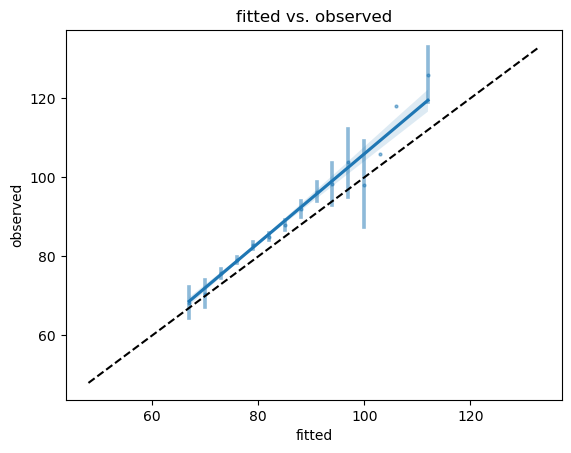

In [29]:
plot_fitted_observed_TS(model, val_dl, bce=bce, CNN=CNN, MMD=MMD, DTF = False)

In [3]:
#plot_from_saved(save_name, model, val_dl, CNN=CNN, bce=True, MMD=MMD, DTF=False, method = 'regression')

In [225]:
#load_model(save_name, model)
model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
model_path = os.path.join(model_dir, save_name + ".pt")
checkpoint = torch.load(model_path, weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])

RuntimeError: Error(s) in loading state_dict for Causal_CNN_Classifier_KG:
	size mismatch for u0: copying a param with shape torch.Size([]) from checkpoint, the shape in current model is torch.Size([1]).
	size mismatch for u1: copying a param with shape torch.Size([]) from checkpoint, the shape in current model is torch.Size([0]).
	size mismatch for u2: copying a param with shape torch.Size([]) from checkpoint, the shape in current model is torch.Size([0]).
	size mismatch for u3: copying a param with shape torch.Size([]) from checkpoint, the shape in current model is torch.Size([0]).

131
131
0 151.74657953702487 121.74935913085938
5 99.77452512887808 56.48715591430664
10 48.48325538635254 29.194202423095703
15 28.16449708205003 24.360671997070312
20 23.585933171785793 24.883358001708984
25 23.286226162543663 26.12717056274414
30 23.184525049649753 26.573314666748047
35 22.931029576521652 26.54305648803711
40 22.770640006432167 26.573808670043945
45 22.75050372343797 26.773157119750977
50 22.775408524733322 26.979446411132812
55 22.79882475046011 27.110042572021484
60 22.808528129871075 27.16740608215332
65 22.80759334564209 27.178476333618164
70 22.802307715782753 27.167871475219727
75 22.796489018660324 27.15083885192871
80 22.79124747789823 27.133771896362305
85 22.786448331979607 27.11782455444336
90 22.781733366159294 27.10234832763672
95 22.77695211997399 27.086732864379883


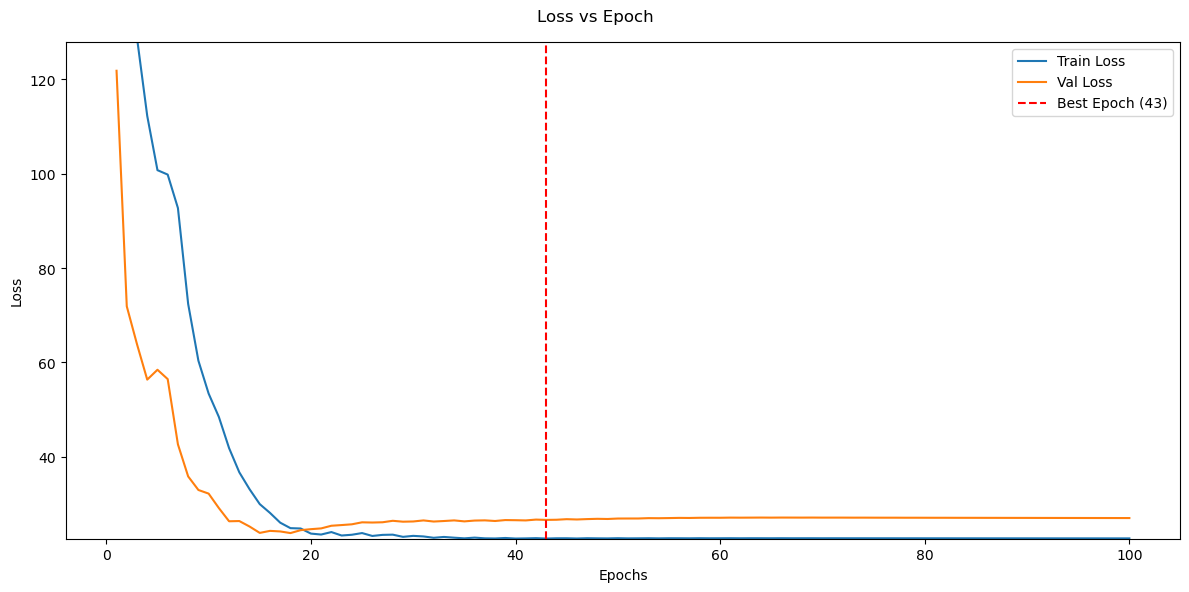

In [84]:
bs=100
n_channels = 5
transfer_method = 'first_layer'
X_tensor, y_tensor = ML_tensor_from_ds(last_tests_dict['highlands full'])#early_ds_dict['arid low'])
train_ds, val_ds = train_test_ds_from_tensors(X_tensor, y_tensor, train_proportion=1)
train_dl, val_dl = train_test_dl_from_tensors(X_tensor, y_tensor, bs = bs, n_channels = n_channels, train_proportion=0.8)
#train_dl, val_dl = train_test_dl_by_year(temp_NDVI_series_DE, NDVI_labels_DE, test_years = [2022, 2023, 2024], year_column = -2, bs = bs, n_channels = 8, train_proportion=0.8)
save_name_mother = 'CCNN_KG_DE_pre_2022_for_TL2'
epochs = 1000
input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
normalise_at_end = False#True
num_layers = 3
output_dim = 1 
KG = True
MMD = False
regression = False
KG_vpd = False
CNN = True
bce = True
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG, MMD, None, regression, KG_vpd, normalise_at_end, 8, 22, 39)
model= Causal_CNN_Classifier_KG(*model_args)
trained_model = load_model(save_name_mother, model)
criterion = problist_square_loss()
if transfer_method == 'KG':
    lr = 0.01
    epochs = 500
else:
    lr = 0.05
    epochs = 500
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=lr)#, weight_decay = 0.001)
ft_params = get_ft_params(trained_model, transfer_method=transfer_method)
for param in model.parameters():
    param.requires_grad = False
for param in ft_params:
    param.requires_grad = True
fit(epochs, trained_model, criterion, optimizer, train_dl, val_dl, save_name = save_name_mother + '_transferred', CNN = CNN, bce=bce, MMD=MMD)

In [4]:
#plot_from_saved(save_name_mother + '_transferred', model, val_dl, CNN=CNN, bce=True, MMD=MMD, DTF=False, method = 'regression')

In [129]:
lr = 0.05
save_name = 'CCNN_KG_DE_pre_2022_for_TL2'
transfer_method='first_layer'
epochs = 100
bs = 500
n_channels = 5
input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
normalise_at_end = False#True
num_layers = 3
output_dim = 1 
KG = True
MMD = False
regression = False
KG_vpd = False
CNN = True
bce = True
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG, MMD, None, regression, KG_vpd, normalise_at_end, 8, 22, 39)
#get data for specific region
ds_highlands = late_ds_dict['high']#last_tests_dict['highlands full']
#convert to pytorch format
X_tensor, y_tensor = ML_tensor_from_ds(ds_highlands)
train_ds, val_ds = train_test_ds_from_tensors(X_tensor, y_tensor, train_proportion=1)
#run K-fold cross validation
criterion = problist_square_loss()
comparison_frame, loss_values, R2s, Biases, Variances, RMSEs, SSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, lengths, obsvars = K_fold_transfer(5, train_ds, Causal_CNN_Classifier_KG, 
                                                                                                        save_name, epochs, bs, model_args, 
                                                                                                        transfer_method=transfer_method, lr = lr, 
                                                                                                        loss = 'MSE', CNN=CNN, bce=bce, 
                                                                                                        custom_loss=criterion, DTF = False)
print('highlands full', R2s)
#Store sum of squared errors, variance of obs and length of folds for evaluation

62
62
highlands full [0.4252772927284241, -0.0708475112915039, -4.194500923156738, 0.46727466583251953, -0.2838233709335327]


In [5]:
#r2_score(comparison_frame['observed'], comparison_frame['fitted'])

In [6]:
#bad_fit = comparison_frame.iloc[26:37, :]
#sns.regplot(data=bad_fit, x='fitted', y='Error')

In [75]:
def K_fold_transfer_regions(ds_dict, transfer_method = 'KG'):
    if transfer_method == 'last_layer':
        lr = 0.01
        epochs = 500
    else:
        lr = 0.05
        epochs = 500
    save_name = 'CCNN_KG_DE_pre_2022_for_TL2'
    bs = 500
    n_channels = 5
    input_dim = n_channels # Example: 100-dimensional word embeddings
    hidden_dim = 8
    normalise_at_end = False#True
    num_layers = 3
    output_dim = 1 
    KG = True
    MMD = False
    regression = False
    KG_vpd = False
    CNN = True
    bce = True
    model_args = (input_dim, hidden_dim, num_layers, output_dim, KG, MMD, None, regression, KG_vpd, normalise_at_end, 8, 22, 39)
    # initialise lists for storing
    SSE_all_reg = []
    length_all_reg = []
    obsvars_all_reg = []
    regs = []
    comparison_frames = []
    for region in ds_dict.keys():
        #get data for specific region
        ds = ds_dict[region]
        if len(ds) < 20:
            continue
        regs.append(region)
        #convert to pytorch format
        #X_tensor, y_tensor = ML_tensor_from_ds(ds)
        #train_ds, val_ds = train_test_ds_from_tensors(X_tensor, y_tensor, train_proportion=1)
        #run K-fold cross validation
        criterion = problist_square_loss()
        comparison_frame, loss_values, R2s, Biases, Variances, RMSEs, SSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, lengths, obsvars = K_fold_transfer(5, ds, Causal_CNN_Classifier_KG, 
                                                                                                                save_name, epochs, bs, model_args, 
                                                                                                                transfer_method=transfer_method, lr = lr, 
                                                                                                                loss = 'MSE', CNN=CNN, bce=bce, 
                                                                                                                custom_loss=criterion, DTF = False)
        comparison_frames.append(comparison_frame)
        print(region, R2s)
        #Store sum of squared errors, variance of obs and length of folds for evaluation
        SSE_all_reg.append(SSEs)
        length_all_reg.append(lengths)
        obsvars_all_reg.append(obsvars)
    results_dict = {'SSEs': SSE_all_reg,
                    'observed variances': obsvars_all_reg,
                    'fold lengths': length_all_reg,
                    'regions': regs,
                    'comparison_frames': comparison_frames}
    return results_dict

In [73]:
no_regions_dict = {'early full': ds_SSA_early,
                   'late full': ds_SSA_late}

In [67]:
combined_variety_tests_dict = {key: pd.concat((early_ds_dict[key], late_ds_dict[key])) for key in early_ds_dict.keys()}

In [84]:
def make_df_from_score_dict(score_dict, TL_method = 'NA', variety = 'NA'):
    R2s, R2s_split, R2s_pooled = skill_score_all_reg(score_dict)
    df = pd.DataFrame()
    df['R2 score'] = R2s_split.mean(axis=1)
    df_pooled = pd.DataFrame()
    df_pooled['R2 score'] = R2s_pooled
    df['Variety'] = variety
    df_pooled['Variety'] = variety
    df_full_model = pd.DataFrame()
    df_full_model['Variety'] = [variety]
    df_full_model['R2 score'] = [R2s.mean()]
    return df, df_pooled, df_full_model

In [78]:
df, df_pooled = make_df_from_score_dict(no_regions_test_first)
df#_pooled

,R2 score,Variety
0,0.613534,NA
1,0.595885,NA


In [7]:
#no_regions_test_first = K_fold_transfer_regions(no_regions_dict, transfer_method='first_layer')

In [8]:
#results_combined_test_first = K_fold_transfer_regions(combined_variety_tests_dict, transfer_method='first_layer')

In [71]:
for ind, score_dict in enumerate([results_combined_test_first]):# results_dict_late]):
    variety = ['combined'][ind]
    TL_method = ['first', 'first'][ind]
    df, df_pooled = make_df_from_score_dict(score_dict, TL_method=TL_method, variety=variety)
    if ind == 1:
        df['region'] = score_dict['regions']#np.array(['arid low', 'city', 'high', 'humid low'])
        df_pooled['region'] = score_dict['regions']#np.array(['arid low', 'city', 'high', 'humid low'])
    else:
        df['region'] = score_dict['regions']#np.array(['arid low', 'city', 'high', 'humid low', 'cool'])
        df_pooled['region'] = score_dict['regions']#np.array(['arid low', 'city', 'high', 'humid low', 'cool'])

In [72]:
df_pooled.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\TL_tests\\combined_varieties_score_TL_new_eval.csv')

In [9]:
#results_early_first_hps = K_fold_transfer_regions(early_ds_dict, transfer_method='first_layer')
#results_late_first_hps = K_fold_transfer_regions(late_ds_dict, transfer_method='first_layer')

In [10]:
#results_early_KG = K_fold_transfer_regions(early_ds_dict)
#results_late_KG = K_fold_transfer_regions(late_ds_dict)
#results_early_first = K_fold_transfer_regions(early_ds_dict, transfer_method='first_layer')
#results_late_first = K_fold_transfer_regions(late_ds_dict, transfer_method='first_layer')
#results_early_last_conv = K_fold_transfer_regions(early_ds_dict, transfer_method='last_conv')
#results_late_last_conv = K_fold_transfer_regions(late_ds_dict, transfer_method='last_conv')
#results_early_last = K_fold_transfer_regions(early_ds_dict, transfer_method='last_layer')
#results_late_last = K_fold_transfer_regions(late_ds_dict,transfer_method='last_layer')

In [31]:
results_early_first_new_split = K_fold_transfer_regions(early_ds_dict, transfer_method='first_layer')

125
125
arid low [0.6480962038040161, 0.7346668243408203, 0.7110372185707092, 0.8603478670120239, 0.14413630962371826]
53
53
city [0.7665618658065796, 0.4158684015274048, 0.6652498841285706, 0.6279577016830444, 0.6543921232223511]
69
69
high [0.5146205425262451, 0.338775098323822, -0.3686026334762573, 0.49393773078918457, 0.386594295501709]
81
81
humid low [0.6747186183929443, 0.533537745475769, 0.4760345220565796, 0.5647058486938477, 0.07605141401290894]
10
10
cool [-5.559999942779541, 0.09375, -8.847222328186035, -0.8877551555633545, -0.039999961853027344]


In [32]:
results_late_first_new_split = K_fold_transfer_regions(late_ds_dict, transfer_method='first_layer')

109
109
arid low [0.8412555456161499, 0.6064133644104004, 0.6970483064651489, 0.8457937240600586, 0.7301465272903442]
44
44
city [0.4725840091705322, 0.663636326789856, 0.08646613359451294, -0.2626521587371826, -0.5010197162628174]
62
62
high [-0.16164004802703857, -2.002199411392212, 0.4243869185447693, 0.42406612634658813, -0.5557644367218018]
79
79
humid low [0.25946539640426636, 0.4977777600288391, 0.47463494539260864, 0.6470211744308472, 0.6789536476135254]


In [56]:
def skill_score_all_reg(score_dict):
    SSE_all_reg = np.array(score_dict['SSEs'])
    obsvars_all_reg = np.array(score_dict['observed variances'])
    length_all_reg = np.array(score_dict['fold lengths'])
    MSE_all_reg = SSE_all_reg.sum(axis=0)/length_all_reg.sum(axis = 0)
    R2_all_reg = 1 - (SSE_all_reg.sum(axis=0)/((length_all_reg - 1)*obsvars_all_reg).sum(axis=0))
    R2_all_reg_split = 1 - (SSE_all_reg/((length_all_reg - 1)*obsvars_all_reg))
    #R2_pooled = 1 - (SSE_all_reg.sum(axis=1)/((length_all_reg - 1)*obsvars_all_reg).sum(axis=1))
    R2_pooled = []
    for cf in score_dict['comparison_frames']:
        R2_pooled.append(r2_score(cf['observed'], cf['fitted']))
    R2_pooled = np.array(R2_pooled)
    return R2_all_reg, R2_all_reg_split, R2_pooled

In [ ]:
score_dict = results_early_first_new_split
variety = 'early'
TL_method = 'first'
R2s = skill_score_all_reg(score_dict)
scores_by_set_method = pd.DataFrame({'Variety': [variety],
                            'TL method': [TL_method],
                            'R2 Fold 1': [R2s[0]],
                            'R2 Fold 2': [R2s[1]],
                            'R2 Fold 3': [R2s[2]],
                            'R2 Fold 4': [R2s[3]],
                            'R2 Fold 5': [R2s[4]]})

TypeError: unhashable type: 'slice'

In [ ]:
for method_ind in range(4):
    score_dict = [results_early_KG, results_late_KG, results_early_first, results_late_first][method_ind]
    variety = ['early', 'late', 'early', 'late'][method_ind]
    TL_method = ['KG', 'KG', 'first', 'first'][method_ind]
    R2s, R2s_split = skill_score_all_reg(score_dict)
    scores_by_set_method = pd.DataFrame({'Variety': [variety],
                              'TL method': [TL_method],
                              'R2 Fold 1': [R2s[0]],
                              'R2 Fold 2': [R2s[1]],
                              'R2 Fold 3': [R2s[2]],
                              'R2 Fold 4': [R2s[3]],
                              'R2 Fold 5': [R2s[4]]})
    if method_ind == 0:
        scores_full = scores_by_set_method
    else: scores_full = pd.concat((scores_full, scores_by_set_method),axis=0)

In [85]:
df = pd.DataFrame()
for ind, score_dict in enumerate([results_early_first_hps, results_late_first_hps]):
    variety = ['early', 'late'][ind]
    TL_method = ['first', 'first'][ind]
    df, df_pooled, df_full_model = make_df_from_score_dict(score_dict, TL_method=TL_method, variety=variety)
    df['region'] = score_dict['regions']
    df_pooled['region'] = score_dict['regions']
    df_full_model['region'] = 'all combined'
    df = pd.concat((df, df_full_model))
    df_pooled = pd.concat((df_pooled, df_full_model))
    if ind == 0:
        df_full = df
        df_pooled_full = df_pooled
    else:
        df_full = pd.concat([df_full, df])
        df_pooled_full = pd.concat([df_pooled_full, df_pooled])
#df_full = df_full.drop(4)
#df_pooled_full = df_pooled_full.drop(4)
    

In [58]:
#df_full = df_full.drop(4)
df_pooled_full = df_pooled_full.drop(4)

In [ ]:
R2s_split.mean(axis=1)

array([ 0.70757794, -0.99772919, -0.27989086,  0.54540997])

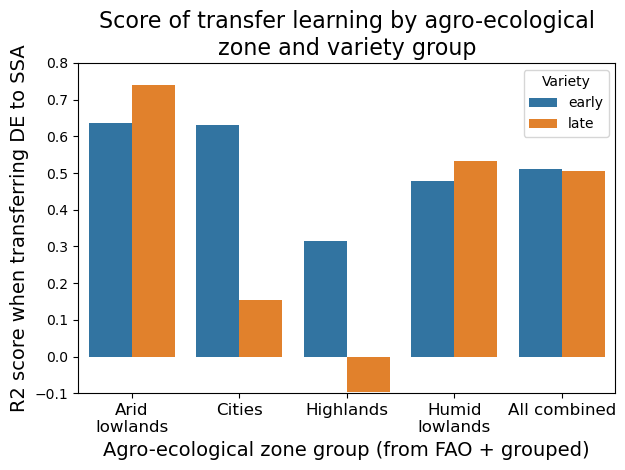

In [90]:
font_size = 14
fig, ax = plt.subplots()
sns.barplot(data = df_pooled_full, hue = 'Variety', x = 'region', y='R2 score', ax=ax)
ax.set_xticks(range(5), ['Arid\nlowlands', 'Cities', 'Highlands', 'Humid\nlowlands', 'All combined'], fontsize =font_size - 2)
ax.set_ylabel('R2 score when transferring DE to SSA', fontsize =font_size)
ax.set_xlabel('Agro-ecological zone group (from FAO + grouped)', fontsize =font_size)
ax.set_title('Score of transfer learning by agro-ecological\nzone and variety group', fontsize = font_size +2)
ax.set_ylim((-0.1, 0.8))
fig.tight_layout()

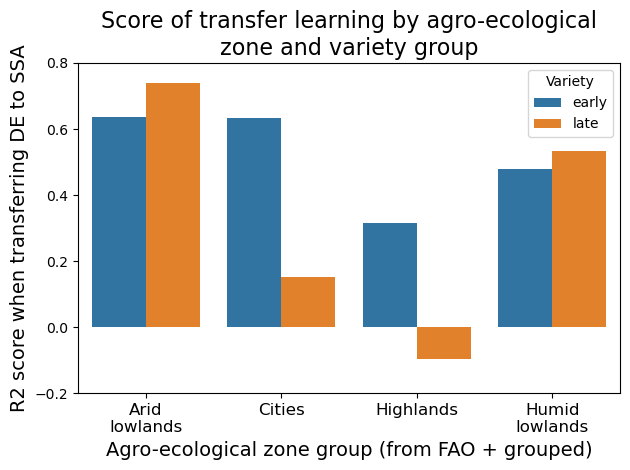

In [66]:
font_size = 14
fig, ax = plt.subplots()
sns.barplot(data = df_pooled_full, hue = 'Variety', x = 'region', y='R2 score', ax=ax)
ax.set_xticks(range(4), ['Arid\nlowlands', 'Cities', 'Highlands', 'Humid\nlowlands'], fontsize =font_size - 2)
ax.set_ylabel('R2 score when transferring DE to SSA', fontsize =font_size)
ax.set_xlabel('Agro-ecological zone group (from FAO + grouped)', fontsize =font_size)
ax.set_title('Score of transfer learning by agro-ecological\nzone and variety group', fontsize = font_size +2)
ax.set_ylim((-0.2, 0.8))
fig.tight_layout()

In [176]:
df_pooled_full.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\TL_tests\\split_varieties_pooled_score_TL.csv')

In [177]:
df_full.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\TL_tests\\split_varieties_score_TL.csv')

In [133]:
score_dict = results_early_first
SSE_all_reg = np.array(score_dict['SSEs'])
obsvars_all_reg = np.array(score_dict['observed variances'])
length_all_reg = np.array(score_dict['fold lengths'])
MSE_all_reg = SSE_all_reg.sum(axis=0)/length_all_reg.sum(axis = 0)
R2_all_reg = 1 - (SSE_all_reg/((length_all_reg-1)*obsvars_all_reg))

In [140]:
def kfold_df_from_array(array):
    df = pd.DataFrame({'arid lowlands': array[0, :],
                       'arid highlands': array[2, :],
                       'humid lowlands': array[3, :],
                       'humid highlands': array[4, :],
                       'cities': array[1, :]})
    return df

In [147]:
df_early_first.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\early_vars_split_scores.csv')

In [80]:
def get_ft_params(model, transfer_method):
    if transfer_method == 'KG':
        ft_params = [model.u0, model.u1, model.u2, model.u3, model.p0]
    elif transfer_method == 'last_layer':
        ft_params = model.fc.parameters()
    elif transfer_method == 'first_layer':
        ft_params = model.conv1.parameters()
    elif transfer_method == 'last_conv':
        ft_params = model.conv21.parameters()
    elif transfer_method == 'last_wave':
        ft_params = [layer.parameters() for layer in model.wave3]
        ft_params = [param for layer_params in ft_params for param in layer_params]
    elif transfer_method == 'first_wave':
        ft_params = [layer.parameters() for layer in model.wave1]
        ft_params = [param for layer_params in ft_params for param in layer_params]
    return ft_params

0 0.4270164966583252 0.2432604432106018
5 0.2579318583011627 0.2529607117176056
10 0.23143935203552246 0.23746049404144287
15 0.19790534675121307 0.18823614716529846
20 0.11933302134275436 0.14075195789337158
25 0.12715351581573486 0.12516501545906067
30 0.12009669840335846 0.1190573200583458
35 0.11770009994506836 0.1126132681965828
40 0.11445806175470352 0.10953367501497269
45 0.11161278188228607 0.10927050560712814
50 0.10939378291368484 0.10890523344278336
55 0.10899576544761658 0.10875624418258667
60 0.10879199206829071 0.10931451618671417
65 0.10879484564065933 0.1087370291352272
70 0.1088414117693901 0.10918313264846802
75 0.1088058203458786 0.10868426412343979
80 0.10876969248056412 0.10891886055469513
85 0.10905304551124573 0.10891712456941605
90 0.10881529748439789 0.10899984836578369
95 0.1087908148765564 0.10901984572410583
100 0.10872690379619598 0.10901445895433426
105 0.10870103538036346 0.10893836617469788
110 0.10866811126470566 0.10897620767354965
115 0.10862701386213

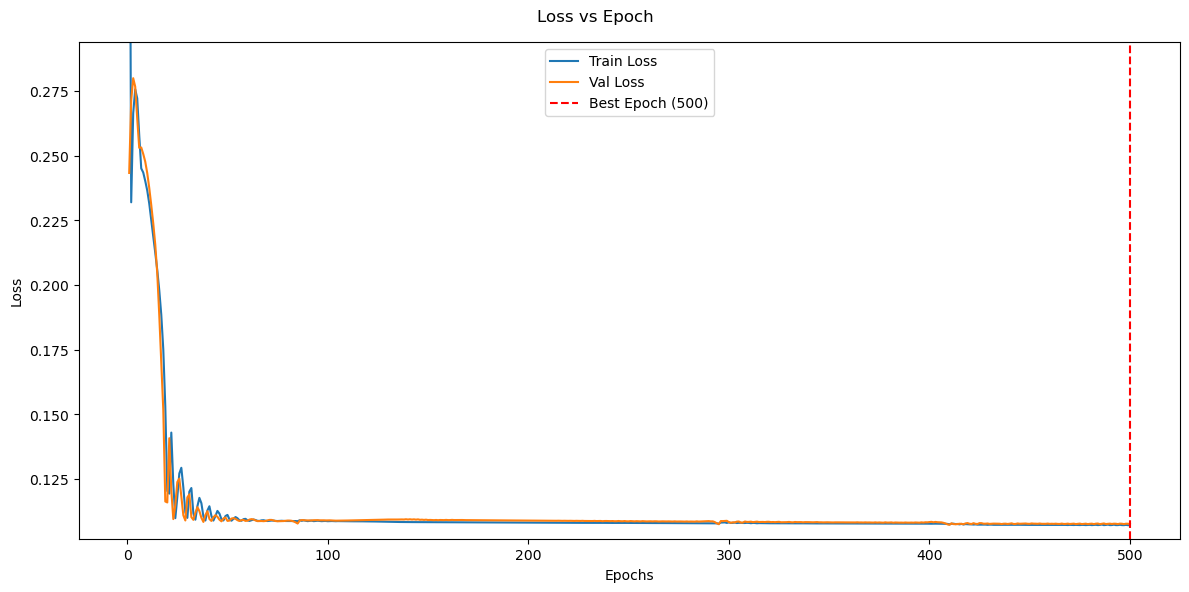

In [91]:
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.8)
transfer_method = 'first_layer'
save_name = 'CCNN_KG_DE_pre_2022_dev_stage_small'
trained_model = load_model(save_name, model)
save_name = 'CCNN_KG_DE_pre_2022_dev_stage_small_SSA_transfer'
bs = 500
CNN = True
bce = True
input_dim = n_channels # Example: 100-dimensional word embeddings
criterion = nn.BCELoss()
MMD_loss = MMDLoss(weight=0.01)
if transfer_method == 'KG':
    lr = 0.5
    epochs = 500
else:
    lr = 0.5
    epochs = 500
optimizer = torch.optim.Adam(model.parameters(), lr=lr)#, weight_decay = 0.001)
ft_params = get_ft_params(trained_model, transfer_method=transfer_method)
for param in model.parameters():
    param.requires_grad = False
for param in ft_params:
    param.requires_grad = True
fit(epochs, trained_model, criterion, optimizer, train_dl_SSA, val_dl_SSA, save_name = save_name, CNN = CNN, bce=bce, MMD=MMD, MMD_loss=MMD_loss)

In [37]:
hidden_dim = 4
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
epochs = 500
save_name = 'CCNN_KG_DE_pre_2022_dev_stage_small'
KG = True
regression = False
bs = 500
n_channels = 4
CNN = True
bce = True

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
num_layers = 3
output_dim = 1 
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG, MMD, None, regression, KG_vpd)
loss_values, R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs = K_fold_transfer(5, train_ds, Causal_CNN_Classifier_KG, save_name, epochs, bs, model_args, transfer_method='first_layer', lr = 0.01, loss = 'MSE', CNN=True, bce=False, custom_loss=criterion, DTF = True, obs_method=False, savename_prefix='layer1')

Fold 1
Loss: 0.11093205958604813
torch.Size([51, 163]) torch.Size([51, 1, 163])
tensor(0)  fits too small
Fold 2
Loss: 0.11481966078281403
torch.Size([51, 163]) torch.Size([51, 1, 163])
tensor(0)  fits too small
Fold 3
Loss: 0.11297120153903961
torch.Size([51, 163]) torch.Size([51, 1, 163])
tensor(0)  fits too small
Fold 4


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Loss: 0.11313913017511368
torch.Size([51, 163]) torch.Size([51, 1, 163])
tensor(0)  fits too small
Fold 5
Loss: 0.10793603211641312
torch.Size([50, 163]) torch.Size([50, 1, 163])
tensor(0)  fits too small


In [165]:
for transfer_method in ['first_layer', 'last_conv', 'last_layer','last_wave', 'first_wave']:#['KG']:#, 'first_layer', 'last_conv', 'last_layer','last_wave', 'first_wave']:#
    print(transfer_method)
    train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
    save_name = 'CCNN_KG_DE_pre_2022_dev_stage_small_tmax_fix'
    epochs = 1000
    bs = 500

    n_channels = 4
    input_dim = n_channels # Example: 100-dimensional word embeddings
    hidden_dim = 32
    num_layers = 3
    output_dim = 1 
    KG = True
    MMD = False
    regression = False
    KG_vpd = False
    normalise_at_end = False
    model_args = (input_dim, hidden_dim, num_layers, output_dim, KG, MMD, None, regression, KG_vpd, normalise_at_end)
    criterion = nn.BCELoss()
    CNN = True
    bce = True

    
    
    loss_values, R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs = K_fold_transfer(5, train_ds, Causal_CNN_Classifier_KG, 
                                                                                                             save_name, epochs, bs, model_args, 
                                                                                                             transfer_method=transfer_method, lr = 0.1, 
                                                                                                             loss = 'MSE', CNN=CNN, bce=bce, 
                                                                                                             custom_loss=criterion, DTF = False)
    print(loss_values, R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs)
    err_df = make_error_df(R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, 'CCNN KG', 'DE', '5-fold')
    if transfer_method == 'KG':
        err_df_full = err_df
    else:
        err_df_full = pd.concat([err_df_full, err_df], ignore_index=True)
    if 'Unnamed: 0' in err_df_full.columns:
        err_df_full.drop(['Unnamed: 0'], axis = 1, inplace = True)

first_layer
[np.float64(0.18120716512203217), np.float64(0.09891651570796967), np.float64(0.08255009353160858), np.float64(0.10362079739570618), np.float64(0.09067188948392868)] [0.18592476844787598, 0.5189717411994934, 0.2576431632041931, 0.4167085886001587, 0.46438801288604736] [np.float32(4.509804), np.float32(-1.8823547), np.float32(1.0), np.float32(-0.68627167), np.float32(0.8199997)] [36.8470573425293, 61.88078308105469, 42.38823318481445, 41.87843704223633, 64.27919006347656] [np.float32(14.130169), np.float32(7.9573545), np.float32(6.9733386), np.float32(8.92999), np.float32(7.570178)] [6.0701775550842285, 7.866434097290039, 6.510624408721924, 6.471354961395264, 8.017430305480957] [np.float64(0.5399920417554073), np.float64(0.7423910918421348), np.float64(0.5670937928395496), np.float64(0.6576564242467312), np.float64(0.6898724567778737)] [-14.0, -20.0, -12.0, -20.0, -20.0] [np.float64(-3.5), np.float64(-7.0), np.float64(-3.5), np.float64(-6.0), np.float64(-3.75)] [1.0, -3.0, 0

c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[np.float64(0.07961051911115646), np.float64(9.386021614074707), np.float64(0.11433611065149307), np.float64(0.8164064884185791), np.float64(0.09519905596971512)] [0.4542245864868164, -63.15052032470703, 0.5425139665603638, -15.319780349731445, 0.5481276512145996] [np.float32(0.05882263), np.float32(-91.54902), np.float32(0.0), np.float32(60.56863), np.float32(1.3600006)] [60.25493621826172, 0.0, 55.10823059082031, 0.1835295557975769, 66.89794921875] [np.float32(6.951969), np.float32(11.520339), np.float32(7.2002177), np.float32(15.570529), np.float32(8.758448)] [7.7624053955078125, 0.0, 7.423491954803467, 0.42840349674224854, 8.179116249084473] [np.float64(0.6864644034999099), np.float64(nan), np.float64(0.7380927579981623), np.float64(-0.1990083567029929), np.float64(0.7620016620704405)] [-15.0, -116.0, -14.0, 36.0, -14.0] [np.float64(-5.0), np.float64(-98.5), np.float64(-6.0), np.float64(52.0), np.float64(-5.0)] [0.0, -90.0, 2.0, 58.0, -0.5] [np.float64(4.0), np.float64(-84.0), np.f

c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[np.float64(39.24177169799805), np.float64(45.535072326660156), np.float64(47.27473449707031), np.float64(47.23643493652344), np.float64(46.28080368041992)] [-49.51654815673828, -10.748835563659668, -21.84735870361328, -42.59856414794922, -69.0867691040039] [np.float32(-88.0), np.float32(-35.980392), np.float32(-62.470596), np.float32(-86.882355), np.float32(-86.619995)] [0.0, 3.6337249279022217, 2.17490291595459, 0.0, 5.430204391479492] [np.float32(12.505685), np.float32(12.612615), np.float32(14.17586), np.float32(13.311718), np.float32(10.757119)] [0.0, 1.9062331914901733, 1.4747551679611206, 0.0, 2.33027982711792] [np.float64(nan), np.float64(-0.7570222653498949), np.float64(-0.490978795712107), np.float64(nan), np.float64(-0.035124425515844514)] [-112.0, -63.0, -91.0, -111.0, -111.0] [np.float64(-95.0), np.float64(-44.0), np.float64(-69.5), np.float64(-95.0), np.float64(-94.0)] [-89.0, -35.0, -63.0, -87.0, -87.0] [np.float64(-83.5), np.float64(-28.5), np.float64(-54.5), np.float64

In [161]:
np.mean(np.array(R2s))

np.float64(0.4164148211479187)

In [168]:
err_df_full

,model,region,evaluation method,R2,Bias (obs minus modelled),Variance,RMSE,STD,Corr,Min,LQ,Median,UQ,Max,transfer_method
0,CCNN KG,DE,5-fold,0.416415,-0.142039,56.188951,9.176462,7.456411,0.658961,-17.4,-5.50,-0.9,3.65,28.8,KG
1,CCNN KG,DE,5-fold,0.368727,0.752235,49.454740,9.112206,6.987204,0.639401,-17.2,-4.75,-0.4,4.70,30.4,first_layer
2,CCNN KG,DE,5-fold,0.418618,0.370273,49.229514,9.256266,6.995405,0.655775,-18.8,-5.00,-0.4,4.05,35.0,last_conv
3,CCNN KG,DE,5-fold,0.399578,0.090117,49.041818,9.065927,6.991345,0.657458,-16.8,-5.00,-0.8,4.35,32.6,last_layer
4,CCNN KG,DE,5-fold,-15.385087,-5.912313,36.488929,10.000300,4.758683,NaN,-24.6,-12.50,-6.1,-0.90,21.8,last_wave
5,CCNN KG,DE,5-fold,-38.759615,-71.990669,2.247766,12.672599,1.142254,NaN,-97.6,-79.50,-72.2,-65.75,-29.2,first_wave


In [162]:
import copy
t_mins = []
t_opts = []
t_maxs = []
scale_list = []
for s_name in ['CCNN_KG_DE_pre_2022_dev_stage_small_tmax_fix'] + [f'KFold{n}' for n in range(1, 5)]:
    saved_model = load_model(s_name, model)
    T_min = 9 + 10*(torch.tanh(saved_model.u1.data)) - 4 #normally multiplier = 2
    T_opt = 28 + 7*(torch.tanh(saved_model.u2.data)) - 4 #normally multiplier = 3
    T_max = 39 + 3.5*torch.tanh(saved_model.u3.data) - 2 #normally no multiplier
    scale = copy.deepcopy(saved_model.u0.data)
    print(T_min, T_opt, T_max, scale)
    t_mins.append(T_min)
    t_opts.append(T_opt)
    t_maxs.append(T_max)
    scale_list.append(scale)
    print(scale_list)
param_df = pd.DataFrame({'T_min': np.array(t_mins).squeeze(),
                       'T_opt': np.array(t_opts).squeeze(),
                       'T_max': np.array(t_maxs).squeeze(),
                       'scale': np.array(scale_list).squeeze(),
                       'region': ['Germany from training'] + ['SSA from transfer' for n in range(1, 5)]})

tensor([8.0822]) tensor([23.2791]) tensor([36.9997]) tensor([1.2956])
[tensor([1.2956])]
tensor([2.0534]) tensor([27.4423]) tensor([40.3788]) tensor([1.1915])
[tensor([1.2956]), tensor([1.1915])]
tensor([6.2250]) tensor([25.9488]) tensor([40.3700]) tensor([1.1122])
[tensor([1.2956]), tensor([1.1915]), tensor([1.1122])]
tensor([-4.4420]) tensor([24.8434]) tensor([33.8007]) tensor([1.1154])
[tensor([1.2956]), tensor([1.1915]), tensor([1.1122]), tensor([1.1154])]
tensor([-4.7346]) tensor([26.1400]) tensor([40.4236]) tensor([1.1059])
[tensor([1.2956]), tensor([1.1915]), tensor([1.1122]), tensor([1.1154]), tensor([1.1059])]


In [163]:
param_df = param_df.groupby('region').mean()
param_df

,T_min,T_opt,T_max,scale
region,,,,
Germany from training,8.082190,23.279068,36.999748,1.295642
SSA from transfer,-0.224546,26.093620,38.743290,1.131253


In [110]:
err_df

,model,region,evaluation method,R2,Bias (obs minus modelled),Variance,RMSE,STD,Corr,Min,LQ,Median,UQ,Max
0,CCNN KG,DE,5-fold,0.399666,-0.404552,46.349577,9.211668,6.781991,0.654463,-18.6,-5.1,-1.0,3.4,35.2


In [167]:
err_df_full['transfer_method'] = ['KG', 'first_layer', 'last_conv', 'last_layer','last_wave', 'first_wave']

In [106]:
error_df_full = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\important_results\\error_df.csv')

In [169]:
err_df_full.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\results_for_comparing\\errors_TL2.csv')

In [175]:
temp_NDVI_series_SSA.shape

torch.Size([254, 8, 163])

In [177]:
from torchsummary import summary
summary(trained_model, (4, 163))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 164]             288
         LeakyReLU-2              [-1, 32, 163]               0
            Conv1d-3              [-1, 32, 165]           2,080
         LeakyReLU-4              [-1, 32, 163]               0
            Conv1d-5              [-1, 32, 167]           2,080
         LeakyReLU-6              [-1, 32, 163]               0
            Conv1d-7              [-1, 32, 171]           2,080
         LeakyReLU-8              [-1, 32, 163]               0
            Conv1d-9              [-1, 32, 179]           2,080
        LeakyReLU-10              [-1, 32, 163]               0
           Conv1d-11              [-1, 32, 195]           2,080
        LeakyReLU-12              [-1, 32, 163]               0
           Conv1d-13              [-1, 32, 227]           2,080
        LeakyReLU-14              [-1, 

In [63]:
error_df_TL = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\results_for_comparing\\errors_TL.csv')

<Axes: xlabel='transfer_method', ylabel='R2'>

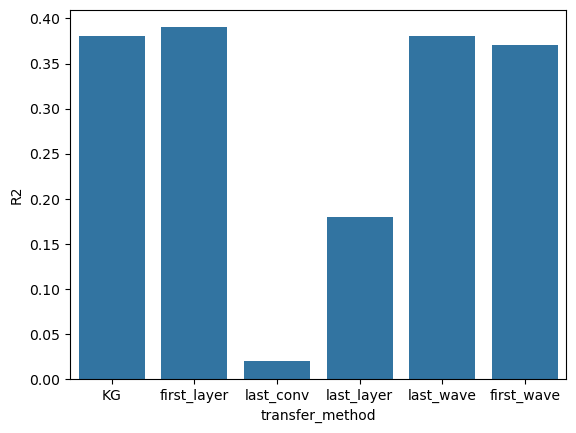

In [ ]:

sns.barplot(error_df_TL, x='transfer_method', y='R2')

In [108]:
error_df_full

,Unnamed: 0,model,region,evaluation method,R2,Bias (obs minus modelled),Variance,RMSE,STD,Corr,Min,LQ,Median,UQ,Max
0,0,GDD Wang Engel,Germany,5-Fold,0.422360,0.196544,57.469759,8.177595,7.580095,0.652758,-45.4,-4.60,0.0,5.00,39.0
1,1,GDD Wang Engel,SSA,5-Fold,0.242415,-0.133237,78.927194,10.486990,8.549305,0.549946,-21.4,-5.40,-0.2,4.75,37.4
2,2,GDD Wang Engel,SSA,Transfer DE to SSA,-1.299031,15.346491,41.795502,10.173415,6.464944,0.546211,-6.0,10.00,14.5,20.00,77.0
3,3,Logistic regression,Germany,5-fold,0.446303,0.100999,50.377059,8.015746,7.096942,0.668896,-42.6,-5.00,-0.8,4.00,38.4
4,4,Logistic regression,SSA,5-fold,0.405319,0.918828,71.359880,9.228532,8.407529,0.666128,-17.0,-5.85,-1.2,4.60,32.8
5,5,linear regression DTF,SSA,5-fold,0.373997,3.348015,58.993333,9.699900,7.630353,0.645322,-15.6,-4.50,-0.2,5.55,35.6
6,6,random forests DTF,SSA,5-fold,0.354385,0.894169,83.229527,9.438324,9.048926,0.643454,-17.2,-4.95,-1.0,4.15,36.0
7,7,random forests classification,SSA,5-fold,0.339676,5.194968,87.124543,10.378714,9.314278,0.652924,-16.0,-4.20,0.0,5.90,34.6
8,8,logistic regression,SSA,Transfer DE to SSA,-18.872547,53.838583,16.444322,10.806163,4.055160,0.514927,30.0,47.25,53.0,59.00,112.0
9,9,regression DTF,SSA,Transfer DE to SSA,-1.632538,-17.307087,117.775419,9.995678,10.852438,0.633848,-47.0,-23.00,-18.0,-14.00,43.0


In [105]:
err_df_full

,model,region,evaluation method,R2,Bias (obs minus modelled),Variance,RMSE,STD,Corr,Min,LQ,Median,UQ,Max,transfer_method
0,CCNN KG,DE,5-fold,0.383275,-0.513178,48.714439,9.227539,6.938437,0.648928,-18.4,-5.85,-1.4,3.15,33.4,KG
1,CCNN KG,DE,5-fold,0.392111,-0.116862,49.747309,9.253349,6.940589,0.656033,-19.0,-5.75,-1.1,3.35,35.0,first_layer
2,CCNN KG,DE,5-fold,0.024481,0.827058,9.539788,11.672549,2.939593,0.254697,-22.2,-6.30,0.0,6.15,42.4,last_conv
3,CCNN KG,DE,5-fold,0.183580,0.598979,6.160861,10.837110,2.479277,0.610717,-20.6,-5.20,-0.2,5.20,37.4,last_layer
4,CCNN KG,DE,5-fold,0.384641,1.144707,48.524313,9.387568,6.937497,0.638125,-16.4,-4.15,-0.1,4.70,36.6,last_wave
5,CCNN KG,DE,5-fold,0.369817,0.109569,80.128472,9.522199,8.882179,0.633590,-21.2,-5.35,-0.4,4.50,33.8,first_wave


In [38]:
R2s

[0.055555522441864014,
 -0.41666650772094727,
 -0.020000100135803223,
 0.1861702799797058,
 0.3333333134651184]

In [115]:
trained_model.u0

Parameter containing:
tensor([1.1986])

OrderedDict([('u0', tensor([1.1986])), ('u1', tensor([-0.0543])), ('u2', tensor([0.5423])), ('u3', tensor([-0.5862])), ('p0', tensor([13.5989])), ('fc2.weight', tensor([[ 0.2569, -0.2192,  0.0190,  0.1502, -0.0478, -0.0338, -0.0129,  0.1637]])), ('fc2.bias', tensor([0.0824])), ('conv1.weight', tensor([[[ 0.1365,  0.2469],
         [ 0.0721,  0.3115],
         [-0.2821,  0.2326],
         [-0.0876,  0.3830]],

        [[ 0.4280,  0.1385],
         [ 0.0543,  0.3844],
         [-0.0054,  0.2452],
         [-0.0285, -0.0603]],

        [[-0.1789, -0.4374],
         [ 0.1608,  0.2450],
         [-0.1184, -0.2257],
         [ 0.0184,  0.3796]],

        [[ 0.2040, -0.2192],
         [ 0.1731,  0.1117],
         [ 0.0371, -0.0910],
         [-0.1149,  0.0304]],

        [[ 0.4476,  0.3920],
         [-0.0545,  0.3035],
         [ 0.3585,  0.0941],
         [-0.2367,  0.3474]],

        [[ 0.3049, -0.0168],
         [-0.2089,  0.1669],
         [-0.2107,  0.0266],
         [-0.2227, -0.2514]]

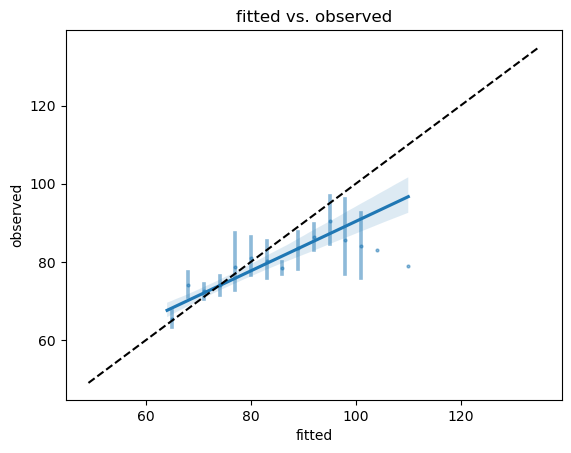

In [128]:
plot_from_saved(save_name, model, train_dl_SSA, CNN=CNN, bce=True, MMD=MMD, DTF=False, method = 'regression', modify_u0=True)

In [68]:
comparison_frame, logs = get_comparison_frame(save_name, model, val_dl, bce=bce, CNN=True, MMD=False, DTF = False, n_channels = 6, obs_method = False)

T_min = tensor([8.5336], grad_fn=<SubBackward0>),
T_opt = tensor([23.8257], grad_fn=<SubBackward0>),
T_max = tensor([36.7678], grad_fn=<SubBackward0>)
tensor([[2.6418e-09, 3.3861e-09, 4.3397e-09, 5.5606e-09, 7.1293e-09, 9.1389e-09,
         1.1713e-08, 1.5007e-08, 1.9216e-08, 2.4600e-08, 3.1490e-08, 4.0303e-08,
         5.1577e-08, 6.5998e-08, 8.4443e-08, 1.0804e-07, 1.3876e-07, 1.7821e-07,
         2.2887e-07, 2.9389e-07, 3.7743e-07, 4.8465e-07, 6.2221e-07, 7.9867e-07,
         1.0260e-06, 1.3180e-06, 1.6927e-06, 2.1741e-06, 2.7941e-06, 3.5926e-06,
         4.6227e-06, 5.9533e-06, 7.6419e-06, 9.8139e-06, 1.2608e-05, 1.6198e-05,
         2.0808e-05, 2.6731e-05, 3.4331e-05, 4.4079e-05, 5.6592e-05, 7.2640e-05,
         9.3218e-05, 1.1962e-04, 1.5352e-04, 1.9703e-04, 2.5284e-04, 3.2443e-04,
         4.1409e-04, 5.2858e-04, 6.7491e-04, 8.6214e-04, 1.1018e-03, 1.4088e-03,
         1.8026e-03, 2.3078e-03, 2.9540e-03, 3.7827e-03, 4.8475e-03, 6.2167e-03,
         7.9779e-03, 1.0248e-02, 1.3183

In [69]:
comparison_frame

,Stations_id,year,fitted,observed
0,7521.0,2022.0,95.0,88.0
1,7521.0,2023.0,95.0,100.0
2,7521.0,2024.0,85.0,101.0
3,7592.0,2023.0,79.0,84.0
4,7608.0,2024.0,77.0,73.0
...,...,...,...,...
1443,19722.0,2023.0,79.0,68.0
1444,19722.0,2024.0,86.0,84.0
1445,19914.0,2022.0,76.0,67.0
1446,19914.0,2023.0,71.0,66.0


In [47]:
comparison_frame['Error'] = comparison_frame['observed'] - comparison_frame['fitted']
comparison_frame['Error'] = comparison_frame['Error'] - comparison_frame['Error'].mean()
1 - (comparison_frame['Error']**2).mean()/comparison_frame['observed'].var()

np.float32(0.3491814)

In [27]:
comparison_frame['fitted'].std()

5.8444929122924805

In [72]:
ds_DE = pd.merge(comparison_frame[['Stations_id', 'year', 'fitted']], ds_inputs_DE, on = ['Stations_id', 'year'], how = 'left').drop_duplicates(subset=['Stations_id', 'year'])

In [73]:
ds_DE['observed time to beginning of flowering']

0        88
1       100
2       101
3        84
4        73
       ... 
1443     68
1444     84
1445     67
1446     66
1447     62
Name: observed time to beginning of flowering, Length: 1448, dtype: int64

In [31]:
#sns.regplot(x='fitted', y='observed time to beginning of flowering', data=ds_DE, x_bins = np.arange(50, 150, 5))

In [79]:
x = [0.34525542, 7.00219008, 23.57229066, 39.02041395, 'Pure Wang', 'NA']
#x = [ 0.37934956,  7.0094127,  25.16467337, 39.17442218]
#x =[0.59, 9.3, 28.3, 39.2, 8, 3]
x = [0.596, 9.3, 28.3, 39.2, 10, 3]
#x = [0.593, 9.3, 28.3, 39.2, 9, 3]
#x = [0.279, 3.6, 21.6, 37.4, 'Pure Wang', 'NA']
cf2 = run_GDD(x, ds_DE, 't2m', response_type='Convolved_vary_spread', thresholds =[20], growing_period_length = 180)   #'Convolved_vary_spread''Wang'
cf_both = comparison_frame.merge(cf2[['Stations_id', 'year', 'lat', 'lon', 'modelled time to beginning of flowering']], on = ['Stations_id', 'year']).drop_duplicates()
cf_both['discrepancy'] = cf_both['fitted'] - cf_both['modelled time to beginning of flowering']


In [75]:
cf_both

,Stations_id,year,fitted,observed,Error,lat,lon,modelled time to beginning of flowering,discrepancy
0,7521.0,2022.0,95.0,88.0,-6.977901,54.4333,9.8167,92.0,3.0
1,7521.0,2023.0,95.0,100.0,5.022099,54.4333,9.8167,93.0,2.0
2,7521.0,2024.0,85.0,101.0,16.022099,54.4333,9.8167,86.0,-1.0
3,7592.0,2023.0,79.0,84.0,5.022099,53.4833,10.6333,77.0,2.0
4,7608.0,2024.0,77.0,73.0,-3.977901,53.5000,10.4833,79.0,-2.0
...,...,...,...,...,...,...,...,...,...
1443,19722.0,2023.0,79.0,68.0,-10.977901,47.8655,9.0147,75.0,4.0
1444,19722.0,2024.0,86.0,84.0,-1.977901,47.8655,9.0147,83.0,3.0
1445,19914.0,2022.0,76.0,67.0,-8.977901,50.3168,9.3627,75.0,1.0
1446,19914.0,2023.0,71.0,66.0,-4.977901,50.3168,9.3627,71.0,0.0


In [76]:
for x_ind, x in enumerate([[0.279, 3.6, 21.6, 37.4, 'Pure Wang', 'NA'], [0.34525542, 7.00219008, 23.57229066, 39.02041395, 'Pure Wang', 'NA'], [0.327, 8.13, 22.84, 38.88, 'Pure Wang', 'NA'], [0.59, 9.3, 28.3, 39.2, 8, 3], [0.593, 9.3, 28.3, 39.2, 9, 3], [0.596, 9.3, 28.3, 39.2, 10, 3]]):
      if x_ind == 0 or x_ind == 1 or x_ind == 2:
            cf2 = run_GDD(x, ds_DE, 't2m', response_type='Wang', thresholds =[20], growing_period_length = 180)   #'Convolved_vary_spread''Wang'
      else:
            cf2 = run_GDD(x, ds_DE, 't2m', response_type='Convolved_vary_spread', thresholds =[20], growing_period_length = 180)   #'Convolved_vary_spread''Wang'
      cf_both = comparison_frame.merge(cf2[['Stations_id', 'year', 'modelled time to beginning of flowering']], on = ['Stations_id', 'year']).drop_duplicates()
      cf_both['discrepancy'] = cf_both['fitted'] - cf_both['modelled time to beginning of flowering']
      var_GDD = cf_both['modelled time to beginning of flowering'].var()
      var_ML = cf_both['fitted'].var()
      var_dis = cf_both['discrepancy'].var()
      print(f'Smoothing param: {x[-2]}'
            f'\nVariance ML: {var_ML}',
            f'\nVariance GDD: {var_GDD}',
            f'\nVariance difference: {var_dis}')

Smoothing param: Pure Wang
Variance ML: 34.15810012817383 
Variance GDD: 16.59812022969992 
Variance difference: 6.370688355026779
Smoothing param: Pure Wang
Variance ML: 34.15810012817383 
Variance GDD: 34.69853039437648 
Variance difference: 4.245573810551061
Smoothing param: Pure Wang
Variance ML: 34.15810012817383 
Variance GDD: 36.7018273662025 
Variance difference: 4.346833036154029
Smoothing param: 8
Variance ML: 34.15810012817383 
Variance GDD: 38.6294123486584 
Variance difference: 7.499761365675522
Smoothing param: 9
Variance ML: 34.15810012817383 
Variance GDD: 32.11892341556352 
Variance difference: 6.739097752255564
Smoothing param: 10
Variance ML: 34.15810012817383 
Variance GDD: 26.832385159617825 
Variance difference: 6.328612828217666


Text(0, 0.5, 'ML - GDD')

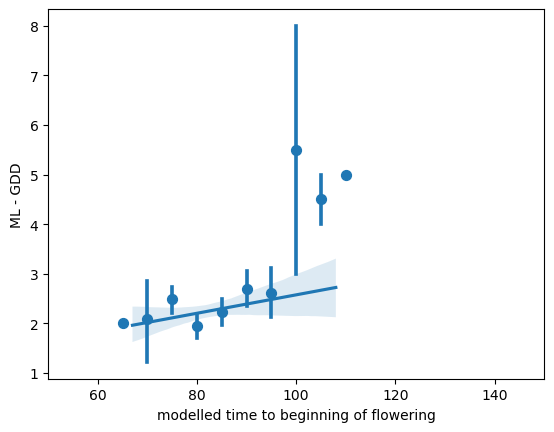

In [77]:
fig, ax = plt.subplots()
sns.regplot(x='modelled time to beginning of flowering', y='discrepancy', data=cf_both, x_bins = np.arange(50, 150, 5))
ax.set_xlim(50, 150)
ax.set_ylabel('ML - GDD')
#ax.plot([50, 150], [50, 150], color='red', linestyle='--')

In [80]:
cf_both.to_csv("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\model_output\\compare_CCNN_model2.csv")

In [91]:
#ds_DE.loc[ds_DE['fitted'] != 0]['t2min at day 0']

In [ ]:
cf_both[]

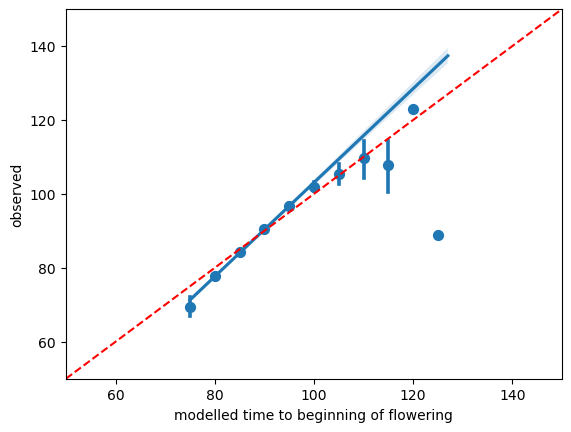

In [107]:
fig, ax = plt.subplots()
sns.regplot(x='modelled time to beginning of flowering', y='observed', data=cf_both, x_bins = np.arange(50, 150, 5))
ax.set_xlim(50, 150)
ax.set_ylim(50, 150)
ax.plot([50, 150], [50, 150], color='red', linestyle='--')


In [65]:
cf_both['modelled time to beginning of flowering'].var()

49.99939554685482

55.55484390258789

In [25]:
cf_both

,Stations_id,year,fitted,observed,modelled time to beginning of flowering,error_CNN,error_GDD
0,11858.0,1995.0,86.0,90.0,89.0,-4.0,-1.0
1,7937.0,1997.0,86.0,79.0,87.0,7.0,8.0
2,13004.0,2016.0,79.0,103.0,88.0,-24.0,-15.0
3,10236.0,1991.0,81.0,81.0,90.0,0.0,9.0
4,10561.0,1993.0,85.0,72.0,74.0,13.0,2.0
...,...,...,...,...,...,...,...
5236,12001.0,2006.0,86.0,88.0,88.0,-2.0,0.0
5237,8810.0,1993.0,93.0,78.0,75.0,15.0,-3.0
5238,11447.0,2018.0,90.0,74.0,72.0,16.0,-2.0
5239,10416.0,1991.0,82.0,107.0,95.0,-25.0,-12.0


In [57]:
cf_both['error_GDD'].mean()

np.float64(0.16618965846212555)

In [59]:
cf_both['discrepancy'].std()

3.1048625838663124

<Axes: xlabel='discrepancy', ylabel='Count'>

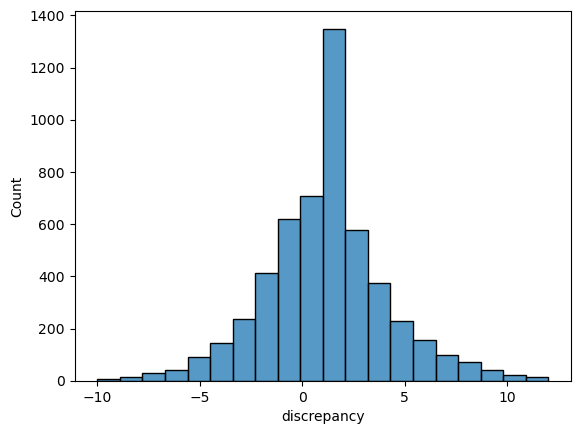

In [61]:
sns.histplot(cf_both['discrepancy'], bins=20)

<Axes: xlabel='modelled time to beginning of flowering', ylabel='error_GDD'>

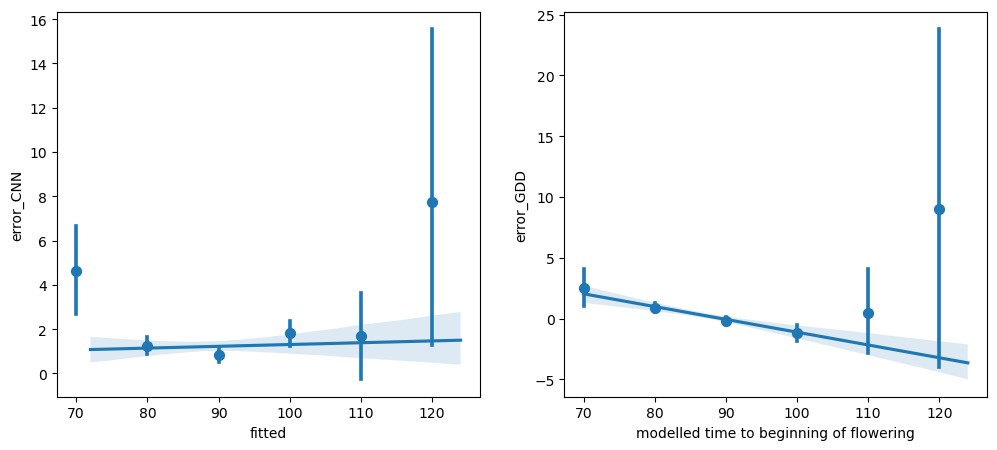

In [55]:
cf_both['error_CNN'] = cf_both['fitted'] - cf_both['observed']
cf_both['error_GDD'] = cf_both['modelled time to beginning of flowering'] - cf_both['observed']
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.regplot(x='fitted', y='error_CNN', data=cf_both, x_bins = np.arange(50, 150, 10), ax=axs[0])
sns.regplot(x='modelled time to beginning of flowering', y='error_GDD', data=cf_both, x_bins = np.arange(50, 150, 10), ax=axs[1])

In [111]:
print(cf_both['modelled time to beginning of flowering'].var(), cf_both['fitted'].var())

65.28372637352857 50.67609786987305


In [104]:
cf_both['mean'] = (cf_both['fitted'] + cf_both['modelled time to beginning of flowering'])/2
1 - (((cf_both['mean'] - cf_both['observed'])**2).mean()/cf_both['observed'].var())

np.float64(0.42381941249167354)

In [117]:
cf_both['discrepancy'] = cf_both['fitted'] - cf_both['modelled time to beginning of flowering']

<Axes: xlabel='discrepancy', ylabel='Count'>

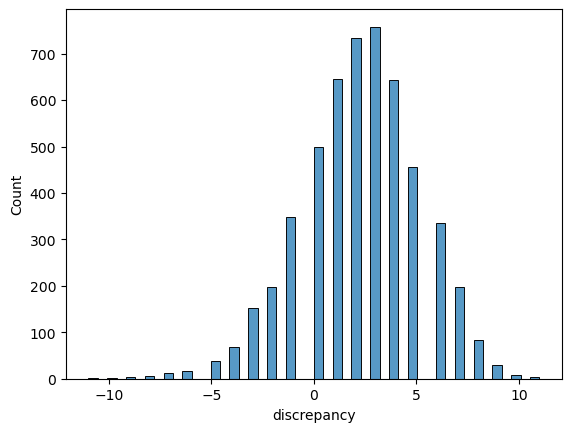

In [118]:
sns.histplot(cf_both['discrepancy'])

In [119]:
((cf_both['modelled time to beginning of flowering'] - cf_both['observed'])**2).mean()**0.5

np.float64(8.601626555090936)

In [120]:
((cf_both['fitted'] - cf_both['observed'])**2).mean()**0.5

np.float32(8.666058)

In [39]:
comparison_frame

,Stations_id,year,fitted,observed
0,11882.0,2002.0,100.0,90.0
1,13922.0,2013.0,93.0,92.0
2,11100.0,2011.0,88.0,86.0
3,8644.0,2012.0,94.0,113.0
4,11609.0,2007.0,86.0,87.0
...,...,...,...,...
6117,11004.0,2016.0,97.0,88.0
6118,13346.0,2010.0,94.0,94.0
6119,13102.0,2021.0,88.0,93.0
6120,10651.0,2003.0,80.0,82.0


<Axes: xlabel='fitted', ylabel='observed'>

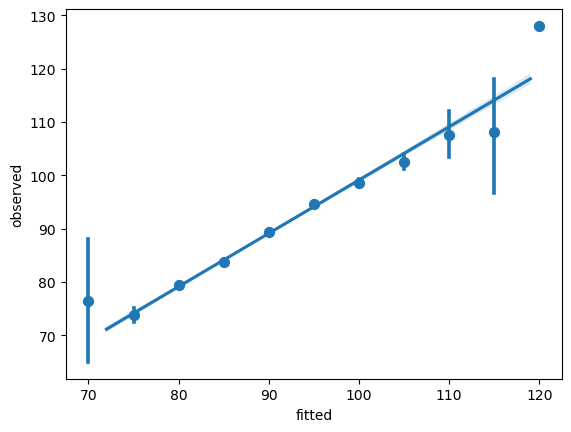

In [36]:
sns.regplot(x='fitted', y='observed', data=comparison_frame, x_bins = np.arange(50, 150, 5))

0 166.32516507222977 328.0841059667618
5 83.79429457587452 93.96393324494635


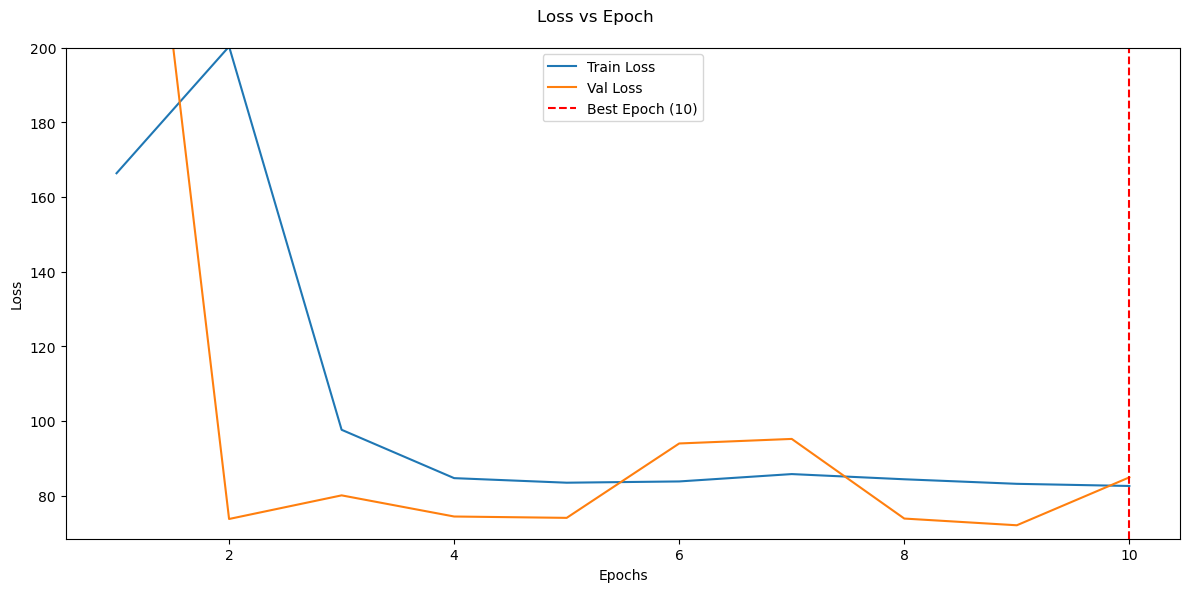

In [15]:
epochs=10
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = CNN, bce=bce, MMD=MMD, MMD_loss=MMD_loss)

In [86]:
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.01)
comparison_frame = get_comparison_frame(save_name, model, val_dl_SSA, bce=bce, CNN=CNN, MMD=MMD, DTF = True, n_channels = n_channels, obs_method = False)

torch.Size([252, 163]) torch.Size([252, 1, 163])
tensor(13)  fits too small


In [89]:
R2s = []
Biases = []
Variances = []

RMSEs = []
STDs = []
Corrs = []

Mins = []
LQs = []
Medians = []
UQs = []
Maxs = []

comparison_frame['Error'] = comparison_frame['observed'] - comparison_frame['fitted']

r2_score_model = r2_score(comparison_frame['observed'], comparison_frame['fitted'])
bias_model = (comparison_frame['Error']).mean()
variance = comparison_frame['fitted'].var()

RMSE = np.sqrt(np.mean((comparison_frame['Error'] - bias_model)**2))
STD = comparison_frame['fitted'].std() 
Corr = comparison_frame['observed'].corr(comparison_frame['fitted'])

RMSEs.append(RMSE)
STDs.append(STD)
Corrs.append(Corr)

Mins.append(comparison_frame['Error'].min())
LQs.append(comparison_frame['Error'].quantile(0.25))
Medians.append(comparison_frame['Error'].median())
UQs.append(comparison_frame['Error'].quantile(0.75))
Maxs.append(comparison_frame['Error'].max())

R2s.append(r2_score_model)
Biases.append(bias_model)
Variances.append(variance)

OrderedDict([('u0', tensor([1.])), ('u1', tensor([0.])), ('u2', tensor([0.])), ('u3', tensor([0.])), ('p0', tensor([12.8599])), ('fc2.weight', tensor([[-0.0895,  0.0733,  0.1021,  0.0966,  0.1595, -0.1211,  0.1119,  0.0049,
          0.1072, -0.1293, -0.1059,  0.0389,  0.1225, -0.0989,  0.1164,  0.1645,
         -0.0222,  0.1485, -0.1668, -0.0626,  0.1199, -0.0751,  0.1478,  0.1597,
         -0.1660, -0.1475,  0.0514,  0.0892, -0.0160, -0.1289, -0.1064, -0.1420]])), ('fc2.bias', tensor([0.0923])), ('conv1.weight', tensor([[[ 0.2153, -0.3701],
         [ 0.1156,  0.2297],
         [-0.2841, -0.2687],
         [-0.3471, -0.3309]],

        [[ 0.1965, -0.3871],
         [-0.1911,  0.1637],
         [ 0.0228,  0.0335],
         [ 0.3286,  0.0532]],

        [[-0.0806,  0.1583],
         [-0.2790,  0.0786],
         [ 0.2265, -0.1136],
         [-0.0008, -0.1951]],

        [[ 0.1820, -0.2570],
         [-0.1920, -0.2373],
         [ 0.1439,  0.1092],
         [-0.1885,  0.0037]],

        

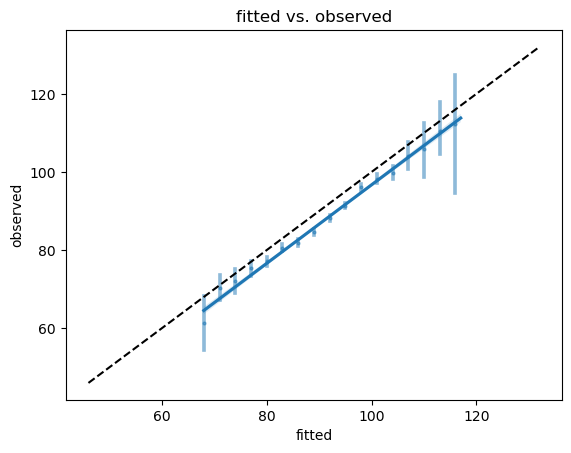

In [16]:
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.01)
train_dl_DE, val_dl_DE = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels, train_proportion=0.1)
plot_from_saved(save_name, model, val_dl, method = 'regression', bce=bce, CNN=CNN, MMD=False, DTF=True, obs_method = False)#

In [45]:
model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
model_path = os.path.join(model_dir, save_name + ".pt")
checkpoint = torch.load(model_path, weights_only=True)
model = Causal_CNN_Classifier_KG(input_dim, hidden_dim, num_layers, output_dim, KG = KG, MMD=MMD, regression=regression, KG_vpd=KG_vpd) #LSTMClassifier_KG(input_dim, hidden_dim, num_layers, output_dim)
model.load_state_dict(checkpoint['model_state_dict'])
for param in model.parameters():
    param.requires_grad = False
for param in [model.u0, model.u1, model.u2, model.u3, model.p0]:
    param.requires_grad = True

In [35]:
bs = 500
train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.5)

# Loss function and optimizer
MSE_weights = torch.Tensor(1 - 0.5*((np.arange(0, 1.63, 0.01) - 1.2)**2))/torch.mean(torch.Tensor(1 - 0.5*((np.arange(0, 1.63, 0.01) - 1.2)**2)))
#print(MSE_weights)
criterion = weighted_MSELoss(weights = MSE_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)#, weight_decay = 0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.5)
new_save_name = 'CCNN_KG_finetuned_SSA'
epochs = 200
torch.autograd.set_detect_anomaly(False)
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = new_save_name, CNN = CNN, bce=bce, MMD=MMD, MMD_loss=MMD_loss)

0 298.23907470703125 389.5352478027344
5 280.09600830078125 370.28985595703125
10 262.9932556152344 352.0083923339844
15 246.90261840820312 334.6732177734375
20 231.79428100585938 318.25726318359375
25 217.63963317871094 302.730224609375
30 204.41038513183594 288.0637512207031
35 192.0716552734375 274.2294616699219
40 180.6010284423828 261.20367431640625
45 169.96728515625 248.96408081054688


KeyboardInterrupt: 

In [15]:
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, train_proportion=1)
epochs = 40
save_name = 'CCNN_expanded_KG'
KG = True
regression = True
bs = 500
n_channels = 4
MSE_weights = torch.Tensor(1 - 0.5*((np.arange(0, 1.63, 0.01) - 1.2)**2))/torch.mean(torch.Tensor(1 - 0.5*((np.arange(0, 1.63, 0.01) - 1.2)**2)))
criterion = weighted_MSELoss(weights = MSE_weights)
MMD = False
KG_vpd = False
input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 32 #8 for SSA
num_layers = 3 #2 for SSA
output_dim = 1 
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG, MMD, None, regression, KG_vpd)
#loss_values, R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs = K_fold_crossval(5, train_ds, Causal_CNN_Classifier_KG, epochs, bs, model_args, savename_prefix = save_name, lr = 0.001, loss = 'MSE', custom_loss=criterion, CNN=True, bce=False, DTF = True, obs_method=False)# 

In [25]:
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, train_proportion=1)
# Loop through each fold
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
skill_lists = []
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state = 1)
bce = False
CNN = True
MMD = False
DTF = True
obs_method = False
for fold, (train_idx, test_idx) in enumerate(kf.split(train_ds)):
    fold_skill_list = []
    print(f"Fold {fold + 1}")
    savename = save_name + str(fold + 1)
    # Define the data loaders for the current fold
    train_dl = DataLoader(
        dataset=train_ds,
        batch_size=bs,
        sampler=torch.utils.data.SubsetRandomSampler(train_idx),
    )
    val_dl = DataLoader(
        dataset=train_ds,
        batch_size=bs,
        sampler=torch.utils.data.SubsetRandomSampler(test_idx),
    )
    TS_model = Causal_CNN_Classifier_KG(input_dim, hidden_dim, num_layers, output_dim, KG, MMD, None, regression, KG_vpd)
    for prediction_day in range(120):
        comp_frame, logs = get_comparison_frame(savename, TS_model, val_dl, bce=bce, CNN=CNN, MMD=MMD, n_channels = n_channels, DTF = DTF, obs_method = obs_method, prediction_day=prediction_day)
        fold_skill_list.append(r2_score(comp_frame['observed'], comp_frame['fitted']))
    skill_lists.append(fold_skill_list)
        
        

Fold 1
torch.Size([5241, 163]) torch.Size([5241, 1, 163])
tensor(0)  fits too small
torch.Size([5241, 163]) torch.Size([5241, 1, 163])
tensor(0)  fits too small
torch.Size([5241, 163]) torch.Size([5241, 1, 163])
tensor(0)  fits too small
torch.Size([5241, 163]) torch.Size([5241, 1, 163])
tensor(0)  fits too small
torch.Size([5241, 163]) torch.Size([5241, 1, 163])
tensor(0)  fits too small
torch.Size([5241, 163]) torch.Size([5241, 1, 163])
tensor(0)  fits too small
torch.Size([5241, 163]) torch.Size([5241, 1, 163])
tensor(0)  fits too small
torch.Size([5241, 163]) torch.Size([5241, 1, 163])
tensor(0)  fits too small
torch.Size([5241, 163]) torch.Size([5241, 1, 163])
tensor(0)  fits too small
torch.Size([5241, 163]) torch.Size([5241, 1, 163])
tensor(0)  fits too small
torch.Size([5241, 163]) torch.Size([5241, 1, 163])
tensor(0)  fits too small
torch.Size([5241, 163]) torch.Size([5241, 1, 163])
tensor(0)  fits too small
torch.Size([5241, 163]) torch.Size([5241, 1, 163])
tensor(0)  fits to

In [27]:
skill_array = np.array(skill_lists)

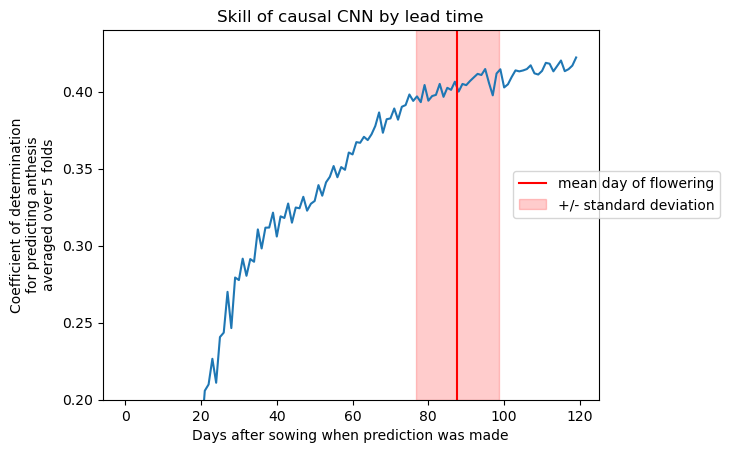

In [53]:
fig, ax = plt.subplots()
ax.plot(range(120), skill_array.mean(axis=0))
ax.set_xlabel('Days after sowing when prediction was made')
ax.set_ylabel('Coefficient of determination\nfor predicting anthesis\naveraged over 5 folds')
ax.set_title('Skill of causal CNN by lead time')
ax.axvline(NDVI_labels_DE[:, 0].mean(), color = 'r', label = 'mean day of flowering')
ax.fill_betweenx([0.2, 0.44], 
                 NDVI_labels_DE[:, 0].mean() - NDVI_labels_DE[:, 0].std(), 
                 NDVI_labels_DE[:, 0].mean() + NDVI_labels_DE[:, 0].std(), 
                 color = 'r', alpha = 0.2, label = '+/- standard deviation')
ax.set_ylim((0.2, 0.44))
fig.legend(bbox_to_anchor = (1.1, 0.6))

tensor(10.9762)

In [23]:
fold_skill_list

[]

In [ ]:
skill_lists = []
for fold_num in range(5):
    for 
    comp_frame, logs = get_comparison_frame()


In [66]:
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, train_proportion=1)
epochs = 40
save_name = 'CCNN_expanded_KG'
KG = True
regression = True
bs = 500
n_channels = 4

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 32 #8 for SSA
num_layers = 3 #2 for SSA
output_dim = 1 
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG, MMD, None, regression, KG_vpd)
loss_values, R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs = K_fold_crossval(5, train_ds, Causal_CNN_Classifier_KG, epochs, bs, model_args, lr = 0.001, loss = 'MSE', CNN=True, bce=False, custom_loss=criterion, DTF = True, obs_method=False)

Fold 1
Loss: 76.9256551649383
torch.Size([3061, 163]) torch.Size([3061, 1, 163])
tensor(0)  fits too small
Fold 2
Loss: 68.89439154645038
torch.Size([3061, 163]) torch.Size([3061, 1, 163])
tensor(0)  fits too small
Fold 3
Loss: 68.98198738091912
torch.Size([3061, 163]) torch.Size([3061, 1, 163])
tensor(0)  fits too small
Fold 4
Loss: 69.85619603575887
torch.Size([3060, 163]) torch.Size([3060, 1, 163])
tensor(0)  fits too small
Fold 5
Loss: 76.45650392691411
torch.Size([3060, 163]) torch.Size([3060, 1, 163])
tensor(0)  fits too small


In [31]:
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
epochs = 150
save_name = 'CCNN_expanded_KG'
KG = True
regression = True
bs = 500
n_channels = 4

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 32
num_layers = 3
output_dim = 1 
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG, MMD, None, regression, KG_vpd)
loss_values, R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs = K_fold_transfer(5, train_ds, Causal_CNN_Classifier_KG, save_name, epochs, bs, model_args, lr = 0.01, loss = 'MSE', CNN=True, bce=False, custom_loss=criterion, DTF = True, obs_method=False)

Fold 1
Loss: 91.04596710205078
torch.Size([51, 163]) torch.Size([51, 1, 163])
tensor(0)  fits too small
Fold 2
Loss: 88.77099609375
torch.Size([51, 163]) torch.Size([51, 1, 163])
tensor(0)  fits too small
Fold 3
Loss: 106.09954071044922
torch.Size([51, 163]) torch.Size([51, 1, 163])
tensor(0)  fits too small
Fold 4
Loss: 102.39878845214844
torch.Size([51, 163]) torch.Size([51, 1, 163])
tensor(0)  fits too small
Fold 5
Loss: 109.42640686035156
torch.Size([50, 163]) torch.Size([50, 1, 163])
tensor(0)  fits too small


In [ ]:
err_df = make_error_df(R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, 'CCNN KG', 'DE', '5-fold')
error_df_full = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\important_results\\error_df.csv')
err_df_full = pd.concat([error_df_full, err_df], ignore_index=True)
err_df_full.drop(['Unnamed: 0'], axis = 1, inplace = True)
err_df_full.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\important_results\\error_df.csv')

In [71]:
err_df_full

,model,region,evaluation method,R2,Bias (obs minus modelled),Variance,RMSE,STD,Corr,Min,LQ,Median,UQ,Max
0,GDD Wang Engel,Germany,5-Fold,0.422360,0.196544,57.469759,8.177595,7.580095,0.652758,-45.4,-4.60,0.0,5.00,39.0
1,GDD Wang Engel,SSA,5-Fold,0.242415,-0.133237,78.927194,10.486990,8.549305,0.549946,-21.4,-5.40,-0.2,4.75,37.4
2,GDD Wang Engel,SSA,Transfer DE to SSA,-1.299031,15.346491,41.795502,10.173415,6.464944,0.546211,-6.0,10.00,14.5,20.00,77.0
3,Logistic regression,Germany,5-fold,0.446303,0.100999,50.377059,8.015746,7.096942,0.668896,-42.6,-5.00,-0.8,4.00,38.4
4,Logistic regression,SSA,5-fold,0.405319,0.918828,71.359880,9.228532,8.407529,0.666128,-17.0,-5.85,-1.2,4.60,32.8
5,linear regression DTF,SSA,5-fold,0.373997,3.348015,58.993333,9.699900,7.630353,0.645322,-15.6,-4.50,-0.2,5.55,35.6
6,random forests DTF,SSA,5-fold,0.354385,0.894169,83.229527,9.438324,9.048926,0.643454,-17.2,-4.95,-1.0,4.15,36.0
7,random forests classification,SSA,5-fold,0.339676,5.194968,87.124543,10.378714,9.314278,0.652924,-16.0,-4.20,0.0,5.90,34.6
8,logistic regression,SSA,Transfer DE to SSA,-18.872547,53.838583,16.444322,10.806163,4.055160,0.514927,30.0,47.25,53.0,59.00,112.0
9,regression DTF,SSA,Transfer DE to SSA,-1.632538,-17.307087,117.775419,9.995678,10.852438,0.633848,-47.0,-23.00,-18.0,-14.00,43.0


In [ ]:
logs = torch.round(logs)
fitted_days = mindex_at_0(logs)
observed_days = mindex_at_0(observed)
print(logs.shape, observed_days.shape)
fitted_days = observed_days + logs[:, observed_days.int()]
print(logs)
print(fitted_days, observed_days)

In [23]:
#ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_with_mask_PD_SOS.csv')
#print(len(ds_inputs_DE))
#ds_inputs_DE = ds_inputs_DE.dropna(how='any')
#print(len(ds_inputs_DE))
#ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'] < 120]
skip = 1
numsteps = int(163 // skip)
#NDVI_series_DE = torch.Tensor(ds_inputs_DE[[f'NDVI interpolated at day {skip*n}' for n in range(numsteps)]].values)#12
#NDVI_series_DE = ((NDVI_series_DE - NDVI_series_DE.min(dim=1)[0].unsqueeze(1))/(NDVI_series_DE.max(dim=1)[0] - NDVI_series_DE.min(dim=1)[0]).unsqueeze(1))
temp_series_DE = torch.Tensor(ds_inputs_DE[[f'temperature at day {skip*n}' for n in range(numsteps)]].values)
#photoperiod_series_DE = torch.Tensor((ds_inputs_DE[[f'photoperiod at day {56 + skip*n}' for n in range(numsteps)]] > 11).astype(int).values)#12
photoperiod_series_DE = torch.Tensor(ds_inputs_DE[[f'photoperiod at day {skip*n}' for n in range(numsteps)]].values)#12
day_series_DE = torch.Tensor([[(skip*n)/10 for n in range(numsteps)] for count in range(len(ds_inputs_DE))])
year_series_DE = torch.Tensor([ds_inputs_DE['year'] for count in range(numsteps)]).T
id_series_DE = torch.Tensor([ds_inputs_DE['Stations_id'] for count in range(numsteps)]).T
#temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE, *new_series, day_series_DE, year_series_DE, id_series_DE)), 0, 1)#, photoperiod_series_DE, NDVI_series_DE,
temp_NDVI_series_DE = torch.swapaxes(torch.stack((*new_series, day_series_DE, year_series_DE, id_series_DE)), 0, 1)
labelled_temp_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE, day_series_DE, year_series_DE, id_series_DE)), 0, 1)
#labelled_NDVI_series_DE = torch.swapaxes(torch.stack((NDVI_series_DE, day_series_DE, year_series_DE, id_series_DE)), 0, 1)
#labelled_NDVI_series_DE[:, 0, :] = torch.cumsum(labelled_NDVI_series_DE[:, 0, :], dim=1)
ds_inputs_DE.loc[:, [f'DTF at day {n}' for n in range(193)]] = np.tile(ds_inputs_DE['observed time to beginning of flowering'].values, (193, 1)).T - np.tile(np.arange(0, 193), (len(ds_inputs_DE),1))
#NDVI_labels_DE = torch.Tensor(ds_inputs_DE[[f'dev stage at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype('int64').values)
NDVI_labels_DE = torch.Tensor(ds_inputs_DE[[f'DTF at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype('int64').values)

KeyError: "None of [Index(['temperature at day 0', 'temperature at day 1', 'temperature at day 2',\n       'temperature at day 3', 'temperature at day 4', 'temperature at day 5',\n       'temperature at day 6', 'temperature at day 7', 'temperature at day 8',\n       'temperature at day 9',\n       ...\n       'temperature at day 153', 'temperature at day 154',\n       'temperature at day 155', 'temperature at day 156',\n       'temperature at day 157', 'temperature at day 158',\n       'temperature at day 159', 'temperature at day 160',\n       'temperature at day 161', 'temperature at day 162'],\n      dtype='object', length=163)] are in the [columns]"

In [15]:
def tensor_from_dl(dl):
    first = True
    for xb, yb in dl:
        if first:
            tensor_f = xb
            tensor_l = yb
            first = False
        else:
            tensor_f = torch.cat((tensor_f, xb), dim=0)
            tensor_l = torch.cat((tensor_l, yb), dim=0)
    return tensor_f, tensor_l

In [10]:
def augment_dl(train_dl, val_dl, max_shift = 50, noise_magnitude = 0.1, scale_magnitude = 0.5, num_augs = 12, extra_tensor = labelled_NDVI_series_SSA, extra_factor = 0.1):
    train_tensor_f, train_tensor_l = tensor_from_dl(train_dl)
    val_tensor_f, val_tensor_l = tensor_from_dl(val_dl)
    train_tensor_f, train_tensor_l = augment_tensor(train_tensor_f, train_tensor_l, max_shift = max_shift, num_augs = num_augs, noise_magnitude = noise_magnitude, scale_magnitude = scale_magnitude, extra_tensor = extra_tensor, extra_factor = extra_factor)
    val_tensor_f = val_tensor_f[:, :, :(160 - max_shift)] 
    val_tensor_l = val_tensor_l[:, :(160 - max_shift)]
    train_dl, _ = train_test_dl_from_tensors(train_tensor_f, train_tensor_l, bs = bs, n_channels = 3, train_proportion=1)
    val_dl, _ = train_test_dl_from_tensors(val_tensor_f, val_tensor_l, bs = bs, n_channels = 3, train_proportion=1)
    return train_dl, val_dl

NameError: name 'labelled_NDVI_series_SSA' is not defined

In [85]:
bs=500
train_dl, val_dl = train_test_dl_from_tensors(labelled_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = 3, train_proportion=0.95)

In [76]:
train_dl, val_dl = train_test_dl_from_tensors(labelled_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = 3, train_proportion=0.95)
first = True
for xb, yb in train_dl:
    if first:
        train_tensor_f = xb
        train_tensor_l = yb
        first = False
    else:
        train_tensor_f = torch.cat((train_tensor_f, xb), dim=0)
        train_tensor_l = torch.cat((train_tensor_l, yb), dim=0)
first = True
for xb, yb in val_dl:
    if first:
        val_tensor_f = xb
        val_tensor_l = yb
        first = False
    else:
        val_tensor_f = torch.cat((train_tensor_f, xb), dim=0)
        val_tensor_l = torch.cat((train_tensor_l, yb), dim=0)

In [12]:
def augment_tensor(features, labels, max_shift = 50, noise_magnitude = 0.1, scale_magnitude = 0.5, num_augs = 12, extra_tensor = labelled_NDVI_series_SSA, extra_factor = 0.1):
    aug_series_list = []
    aug_labels_list = []
    for count in range(num_augs):
        for row_int in range(features.shape[0]):
            shift = np.random.randint(0, high=max_shift)
            extra_addition = extra_factor*torch.rand(1)
            extra_choice = np.random.randint(0, high = extra_tensor.shape[0])
            #labelled_NDVI_series_DE = torch.stack((labelled_NDVI_series_DE[:, :, :140], labelled_NDVI_series_DE[row_int, :, shift:(shift + 140)]))
            if row_int == 0:
                augmented_series = copy.deepcopy(features[[row_int], :, :(160 - max_shift)])
                augmented_series[[row_int], 0, :]  = (1 - 0.5*scale_magnitude + scale_magnitude*torch.rand(1))*features[[row_int], 0, shift:(shift + 160 - max_shift)] + noise_magnitude*(torch.rand((1, 1, 160 - max_shift)) - 0.5)
                augmented_series[[row_int], 0, :] = (1 - extra_addition)*augmented_series[[row_int], 0, :] + extra_addition*extra_tensor[[extra_choice], 0, :]
                augmented_labels = labels[[row_int], shift:(shift + 160 - max_shift)]
            else:
                augmented_data = copy.deepcopy(features[[row_int], :, :(160 - max_shift)])
                augmented_data[:, 0, :] = (1 - 0.5*scale_magnitude + scale_magnitude*torch.rand(1))*features[[row_int], 0, shift:(shift + 160 - max_shift)] + noise_magnitude*(torch.rand((1, 1, 160 - max_shift)) - 0.5)
                augmented_data[:, 0, :] = (1 - extra_addition)*augmented_data[:, 0, :] + extra_addition*extra_tensor[[extra_choice], 0, :]
                augmented_series = torch.cat((augmented_series, augmented_data), dim=0)
                augmented_labels = torch.cat((augmented_labels, labels[[row_int], shift:(shift + 160 - max_shift)]), dim=0)
        aug_series_list.append(augmented_series)
        aug_labels_list.append(augmented_labels)
    augmented_feats = torch.cat((features[:, :, :(160 - max_shift)], *aug_series_list), dim=0)
    augmented_labs = torch.cat((labels[:, :(160 - max_shift)], *aug_labels_list), dim=0)
    return augmented_feats, augmented_labs


In [398]:
train_tensor_f, train_tensor_l = augment_tensor(train_tensor_f, train_tensor_l, max_shift = 10, num_augs = 2, noise_magnitude = 0, scale_magnitude = 0.3)

RuntimeError: The size of tensor a (145) must match the size of tensor b (150) at non-singleton dimension 2

In [69]:
train_tensor_f.shape[0]/3

2092.0

In [317]:
max_shift = 50
train_tensor_f, train_tensor_l = augment_tensor(train_tensor_f, train_tensor_l, max_shift = max_shift, num_augs = 6, noise_magnitude = 0.2, scale_magnitude = 0.6)
val_tensor_f = val_tensor_f[:, :, :(160 - max_shift)] 
val_tensor_l = val_tensor_l[:, :(160 - max_shift)]

In [283]:
#train_tensor_f[:, 0, :] = torch.cumsum(train_tensor_f[:, 0, :], dim=1)
#val_tensor_f[:, 0, :] = torch.cumsum(val_tensor_f[:, 0, :], dim=1)

In [318]:
train_dl, _ = train_test_dl_from_tensors(train_tensor_f, train_tensor_l, bs = bs, n_channels = 3, train_proportion=1)
val_dl, _ = train_test_dl_from_tensors(val_tensor_f, val_tensor_l, bs = bs, n_channels = 3, train_proportion=1)

In [9]:
#ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['observed time to beginning of flowering'] < 110]
ds_inputs_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML_fixed_photoperiod.csv')
skip = 1
numsteps = int(163 // skip)
NDVI_series_SSA = torch.Tensor(ds_inputs_SSA[[f'NDVI interpolated at day {skip*n}' for n in range(numsteps)]].values)#12
#NDVI_series_SSA = NDVI_series_SSA - 0.5
#NDVI_series_SSA = ((NDVI_series_SSA - NDVI_series_SSA.min(dim=1)[0].unsqueeze(1))/(NDVI_series_SSA.max(dim=1)[0] - NDVI_series_SSA.min(dim=1)[0]).unsqueeze(1))
temp_series_SSA = torch.Tensor(ds_inputs_SSA[[f'temperature at day {skip*n}' for n in range(numsteps)]].values)
#photoperiod_series_SSA = torch.Tensor((ds_inputs_SSA[[f'photoperiod at day {skip*n}' for n in range(numsteps)]] > 11).astype(int).values)#12
photoperiod_series_SSA = torch.Tensor(ds_inputs_SSA[[f'photoperiod at day {skip*n}' for n in range(numsteps)]].values)#12
day_series_SSA = torch.Tensor([[skip*n for n in range(numsteps)] for count in range(len(ds_inputs_SSA))])
year_series_SSA = torch.Tensor([ds_inputs_SSA['year'] for count in range(numsteps)]).T
id_series_SSA = torch.Tensor([ds_inputs_SSA['Stations_id'] for count in range(numsteps)]).T
temp_NDVI_series_SSA = torch.swapaxes(torch.stack((temp_series_SSA, photoperiod_series_SSA, NDVI_series_SSA, day_series_SSA, year_series_SSA, id_series_SSA)), 0, 1) #, photoperiod_series_SSA
labelled_temp_series_SSA = torch.swapaxes(torch.stack((temp_series_SSA, photoperiod_series_SSA, day_series_SSA, year_series_SSA, id_series_SSA)), 0, 1)
labelled_NDVI_series_SSA = torch.swapaxes(torch.stack((NDVI_series_SSA, day_series_SSA, year_series_SSA, id_series_SSA)), 0, 1)
#labelled_NDVI_series_SSA[:, 0, :] = torch.cumsum(labelled_NDVI_series_SSA[:, 0, :], dim=1)
NDVI_labels_SSA = torch.Tensor(ds_inputs_SSA[[f'dev stage at day {skip*n}' for n in range(numsteps)]].astype('int64').values)

In [10]:
max_shift = 30
labelled_NDVI_series_SSA = labelled_NDVI_series_SSA[:, :, :(160 - max_shift)] 
NDVI_labels_SSA = NDVI_labels_SSA[:, :(160 - max_shift)]
#labelled_NDVI_series_SSA[:, 0, :] = torch.cumsum(labelled_NDVI_series_SSA[:, 0, :], dim=1)

0 0.6829981218672503 0.6682586669921875
5 0.17665075325532886 0.15670154988765717
10 0.11824205432353577 0.12420406937599182
15 0.11366823147326945 0.117622509598732
20 0.10490813581579525 0.11273925751447678
25 0.09861812306722366 0.0964893102645874
30 0.09396425863806154 0.09831494092941284
35 0.08951642245866114 0.09414663165807724
40 0.09298884148088947 0.09960967302322388
45 0.08670731212745054 0.09137014299631119
50 0.09160430688795788 0.10120400786399841
55 0.08585447306394847 0.08947290480136871
60 0.08935285083924195 0.09802627563476562
65 0.08622319543909675 0.08833847939968109
70 0.0869971782679455 0.09279778599739075
75 0.08983711130435025 0.0889468789100647
80 0.0848993406917532 0.09040171653032303
85 0.09055979762154459 0.09896315634250641
90 0.08379037874443171 0.08806783705949783
95 0.08812103149873309 0.09628672897815704


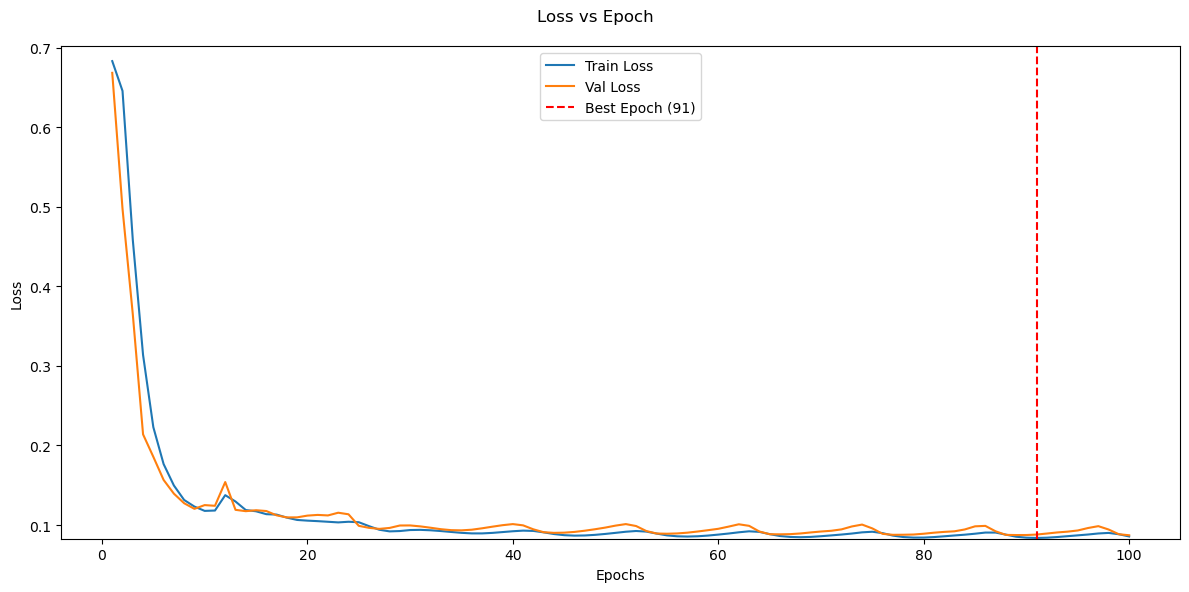

In [29]:
bs = 500
n_channels = 3
max_shift = 30
train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = 4, train_proportion=0.8)

train_tensor_f, train_tensor_l = tensor_from_dl(train_dl)
val_tensor_f, val_tensor_l = tensor_from_dl(val_dl)

train_dl_temp, _ = train_test_dl_from_tensors(train_tensor_f[:, [0, 1, 3, 4, 5], :], train_tensor_l, bs = bs, n_channels = 3, train_proportion=1)
val_dl_temp, _ = train_test_dl_from_tensors(val_tensor_f[:, [0, 1, 3, 4, 5], :], val_tensor_l, bs = bs, n_channels = 3, train_proportion=1)

train_dl_SAT, _ = train_test_dl_from_tensors(train_tensor_f[:, [2, 4, 5], :], train_tensor_l, bs = bs, n_channels = 3, train_proportion=1)
val_dl_SAT, _ = train_test_dl_from_tensors(val_tensor_f[:, [2, 4, 5], :], val_tensor_l, bs = bs, n_channels = 3, train_proportion=1)
#train_dl, val_dl = augment_dl(train_dl, val_dl, max_shift = max_shift, noise_magnitude = 0, scale_magnitude = 0.1, num_augs = 2, extra_factor = 0.2, extra_tensor = labelled_NDVI_series_SSA)

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 16
num_layers = 2
output_dim = 1  # Example: 5 classes


save_name_temp = 'CCNN_Temp'

bce = True
CNN = True
MMD = False
KG=True

model_temp = Causal_CNN_Classifier_KG(input_dim, hidden_dim, num_layers, output_dim, KG = KG, MMD=MMD, target_features=labelled_NDVI_series_SSA)
#for param in [model.p0, model.u0, model.u1, model.u2, model.u3  ]:#[model.u2]: #
#    param.requires_grad = False

# Loss function and optimizer
criterion = nn.BCELoss() #nn.NLLLoss()  # For multi-class classification
MMD_loss = MMDLoss(weight=0.1)
optimizer = torch.optim.Adam(model_temp.parameters(), lr=0.01)#, weight_decay = 0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

epochs = 100
fit(epochs, model_temp, criterion, optimizer, train_dl_temp, val_dl_temp, save_name = save_name_temp, CNN = CNN, bce=bce, MMD=MMD, MMD_loss=MMD_loss)

0 0.6906796021981082 0.6736460328102112
5 0.1361215363228091 0.1439671814441681
10 0.12528305392496702 0.1294994205236435
15 0.12377693526928867 0.12461007386445999
20 0.11687359910682436 0.11616025120019913
25 0.11714332752885397 0.11831783503293991
30 0.11172591247062001 0.11543967574834824
35 0.11000334117963284 0.11113337427377701
40 0.11120863451657312 0.11517941951751709
45 0.10851244274082844 0.11054090410470963
50 0.10952190938114985 0.11290586739778519
55 0.10731855147305737 0.11019495129585266
60 0.10794523306757584 0.11224628239870071
65 0.10631011687768845 0.11012832075357437
70 0.10648748535709403 0.11210024356842041
75 0.10575510608825185 0.11080914735794067
80 0.105324695781127 0.11018716543912888
85 0.10456656508156173 0.11067689210176468
90 0.10446224582384718 0.11127401143312454
95 0.10506429731270782 0.11165735870599747


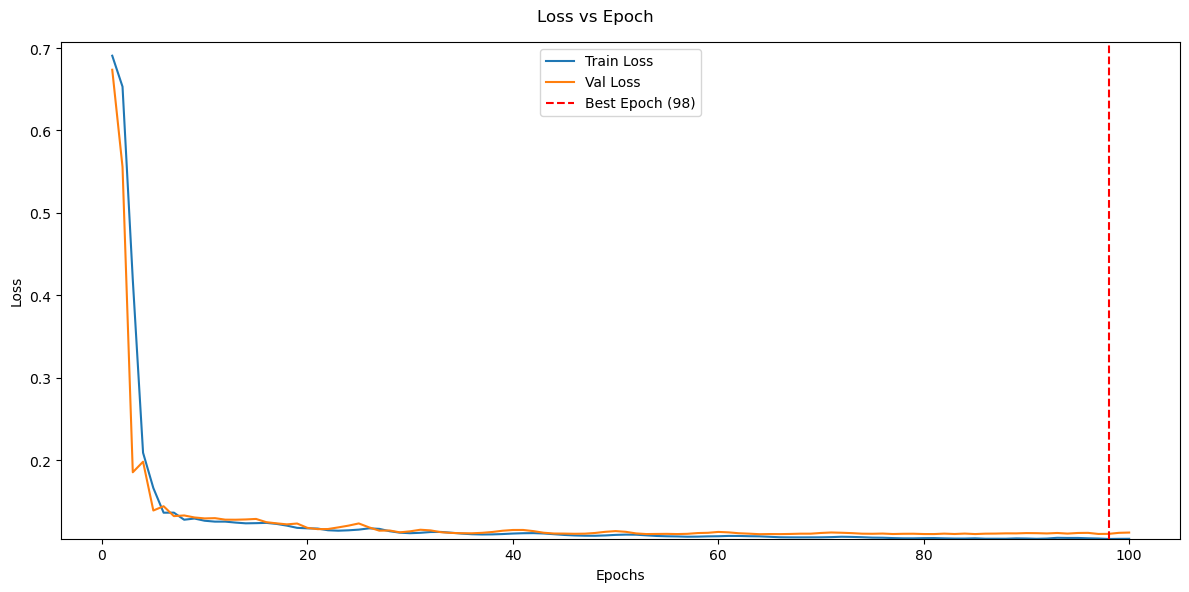

In [30]:
bs = 500
n_channels = 1
input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 16
num_layers = 2
output_dim = 1  # Example: 5 classes

save_name_SAT = 'CCNN_SAT'

bce = True
CNN = True
MMD = False

model_SAT = Causal_CNN_Classifier_KG(input_dim, hidden_dim, num_layers, output_dim, KG = False, MMD=MMD, target_features=labelled_NDVI_series_SSA)

# Loss function and optimizer
criterion = nn.BCELoss() #nn.NLLLoss()  # For multi-class classification
MMD_loss = MMDLoss(weight=0.1)
optimizer = torch.optim.Adam(model_SAT.parameters(), lr=0.01)#, weight_decay = 0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

epochs = 100
fit(epochs, model_SAT, criterion, optimizer, train_dl_SAT, val_dl_SAT, save_name = save_name_SAT, CNN = CNN, bce=bce, MMD=MMD, MMD_loss=MMD_loss)

In [63]:
savenames = ['CCNN_Temp', 'CCNN_SAT']
TS_models = [model_temp, model_SAT]
dls = [val_dl_temp, val_dl_SAT]
bces = [True, True]
CNNs= [True, True]
MMDs = [False, False]
n_channels_list = [3, 1]
CCF = combined_comparison_frame(savenames, TS_models, dls, bces=bces, CNNs=CNNs, MMDs=MMDs, n_channels_list = n_channels_list)


In [64]:
weights = [0.98, 0.02]
for model_ind in range(2):
    CCF[f'fitted logit model {model_ind + 1}'] = np.log(CCF[f'fitted model {model_ind + 1}']/(1 - CCF[f'fitted model {model_ind + 1}']))
    if model_ind == 0:
        CCF['improved fit'] = weights[model_ind]*CCF[f'fitted logit model {model_ind + 1}']
    else:
        CCF['improved fit'] += weights[model_ind]*CCF[f'fitted logit model {model_ind + 1}']
CCF['improved fit'] = 1/(1 + np.exp(-CCF['improved fit']))
CCF['improved fit'] = np.round(CCF['improved fit'])
CCF['observed'] = CCF['observed model 1']
CCF[f'fitted model {model_ind + 1}'] = np.round(CCF[f'fitted model {model_ind + 1}'])

In [65]:
anthesis_fitted = []
anthesis_observed = []
anthesis_models = [[] for count in range(2)]
L = CCF.sizes['time']
for statyear_ind in range(CCF.sizes['statyear']):
    anthesis_fitted.append(L - CCF.isel(statyear=statyear_ind)['improved fit'].sum().values)
    anthesis_observed.append(L - CCF.isel(statyear=statyear_ind)['observed'].sum().values)
    for model_ind in range(2):
        anthesis_models[model_ind].append(L - CCF.isel(statyear=statyear_ind)[f'fitted model {model_ind + 1}'].sum().values)
for model_ind in range(2):
    CCF[f'fitted time model {model_ind + 1}'] = (['statyear'], np.array(anthesis_models[model_ind]))
CCF['observed time'] = (['statyear'], np.array(anthesis_observed))
CCF['fitted time'] = (['statyear'], np.array(anthesis_fitted))
#CCF['fitted']

In [66]:
print(r2_score(CCF['observed time'].values, CCF['fitted time model 1'].values),
      r2_score(CCF['observed time'].values, CCF['fitted time'].values))

0.4887535160999781 0.485113683734696


Text(0.5, 1.0, 'Comparison of residuals between temperature and satellite CCNNs')

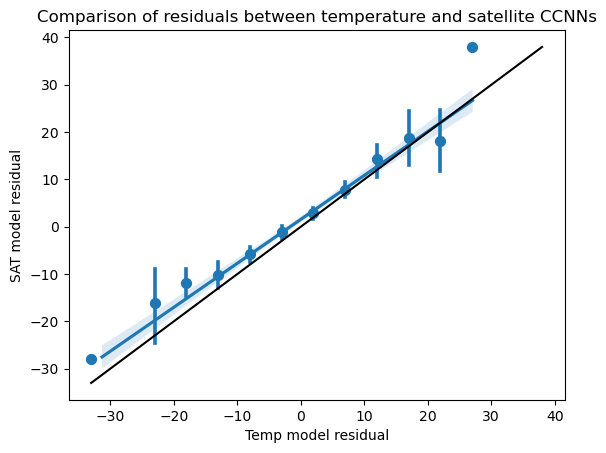

In [69]:
ds = pd.DataFrame({'Temp model residual': CCF['fitted time model 1'].values - CCF['observed time'].values, 'SAT model residual': CCF['fitted time model 2'].values - CCF['observed time'].values})
minval = min(ds['Temp model residual'].min(), ds['SAT model residual'].min())
maxval = max(ds['Temp model residual'].max(), ds['SAT model residual'].max())
fig, ax = plt.subplots()
sns.regplot(x = 'Temp model residual', y = 'SAT model residual', data = ds, x_bins = np.arange(minval, maxval, 5), ax = ax, fit_reg = True)
ax.plot([minval, maxval], [minval, maxval], color = 'black')
ax.set_title('Comparison of residuals between temperature and satellite CCNNs')

In [39]:
ds = pd.DataFrame({'model 1': CCF['fitted time model 1'].values - CCF['observed time'].values, 'model 2': CCF['fitted time model 2'].values - CCF['observed time'].values})

In [41]:
ds = pd.DataFrame({'Temp model': CCF['fitted time model 1'].values, 'SAT model - Temp model': CCF['fitted time model 2'].values - CCF['fitted time model 1'].values})

In [42]:
minval = ds['Temp model'].min()
maxval = ds['Temp model'].max()

In [77]:
CCF.coords['Stations_id'].values.squeeze().shape

(441,)

In [78]:
CCF['observed'].values.shape

(441, 163)

In [79]:
ds = pd.DataFrame({'Temp model': CCF['fitted time model 1'].values, 'SAT model': CCF['fitted time model 2'].values, 
                   'observed': CCF['observed time'].values, 'Stations_id': CCF.coords['Stations_id'].values, 'year': CCF.coords['year'].values})

In [80]:
ds.to_csv(('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\model_output\\compare_CCNN_results.csv'))

In [70]:
import skill_metrics as sm
ds = pd.DataFrame({'Temp model': CCF['fitted time model 1'].values, 'SAT model': CCF['fitted time model 2'].values, 'observed': CCF['observed'].values})
taylor_stats1 = sm.taylor_statistics(ds['Temp model'],ds['observed'],'data')
taylor_stats2 = sm.taylor_statistics(ds['SAT model'],ds['observed'],'data')

ModuleNotFoundError: No module named 'skill_metrics'

NameError: name 'sm' is not defined

Text(0.5, 1.0, 'Discrepancy between CCNN trained just on temperature and just on NDVI')

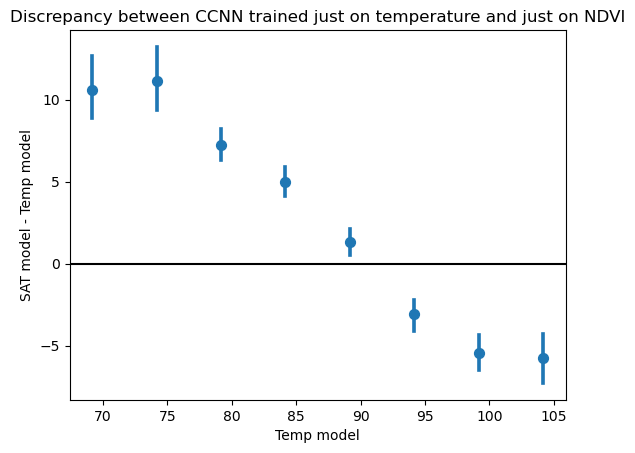

In [44]:
fig, ax = plt.subplots()
sns.regplot(x = 'Temp model', y = 'SAT model - Temp model', data = ds, x_bins = np.arange(minval, maxval, 5), ax = ax, fit_reg = False)
ax.axhline(0, color = 'k')
ax.set_title('Discrepancy between CCNN trained just on temperature and just on NDVI')

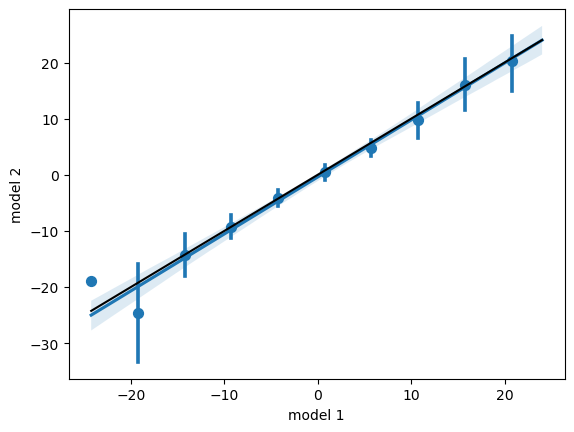

In [380]:
fig, ax = plt.subplots()
sns.regplot(x = 'model 1', y = 'model 2', data = ds, x_bins = np.arange(minval, maxval, 5), ax = ax, fit_reg = True)
ax.plot([minval, maxval], [minval, maxval], color = 'black')


In [205]:
r2_score(CCF.isel(model=0)['observed time'].values, CCF.isel(model=0)['fitted time'].values)

0.1907443404197693

In [144]:
((CCF['fitted time model 2'].values - CCF['fitted time '].values)**2).mean()

69.03061224489795

0 0.6097901379003534 0.26323822140693665
5 0.20402444767262293 0.16421933472156525
10 0.17372347901675825 0.16619955003261566
15 0.16516754825107988 0.17197202146053314


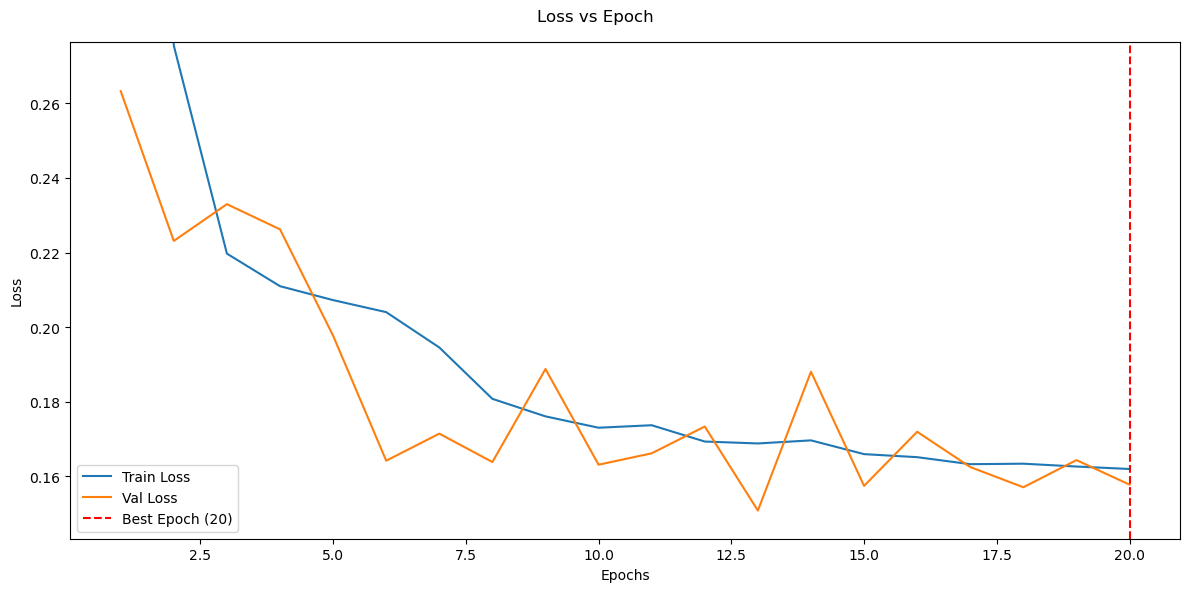

In [19]:
bs = 500
n_channels = 1
#temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE)), 0, 1)#, NDVI_series_DE
#temp_NDVI_series_DE = torch.swapaxes(temp_NDVI_series_DE, 2, 1)
max_shift = 30
train_dl, val_dl = train_test_dl_from_tensors(labelled_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = 4, train_proportion=0.9)
train_dl, val_dl = augment_dl(train_dl, val_dl, max_shift = max_shift, noise_magnitude = 0, scale_magnitude = 0.1, num_augs = 2, extra_factor = 0.2, extra_tensor = labelled_NDVI_series_SSA)

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 16
num_layers = 2
output_dim = 1  # Example: 5 classes


save_name = 'CCNN_SAT'

bce = True
CNN = True
MMD = False

model = Causal_CNN_Classifier_KG(input_dim, hidden_dim, num_layers, output_dim, KG = False, MMD=MMD, target_features=labelled_NDVI_series_SSA)
#for param in [model.p0, model.u0, model.u1, model.u2, model.u3  ]:#[model.u2]: #
#    param.requires_grad = False

# Loss function and optimizer
criterion = nn.BCELoss() #nn.NLLLoss()  # For multi-class classification
MMD_loss = MMDLoss(weight=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)#, weight_decay = 0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

epochs = 20
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = CNN, bce=bce, MMD=MMD, MMD_loss=MMD_loss)

OrderedDict([('u0', tensor([1.])), ('u1', tensor([0.])), ('u2', tensor([0.])), ('u3', tensor([0.])), ('p0', tensor([13.])), ('fc2.weight', tensor([[-0.1962,  0.1590, -0.0072, -0.0044,  0.2036, -0.1932, -0.1694, -0.1349,
          0.1079, -0.0823, -0.1497,  0.1934, -0.2329, -0.1237,  0.0944, -0.0770]])), ('fc2.bias', tensor([0.0540])), ('conv1.weight', tensor([[[-0.3970, -0.2807]],

        [[-0.0023,  0.1802]],

        [[-0.1502,  0.3400]],

        [[ 0.0449, -0.4281]],

        [[ 0.3268, -0.0474]],

        [[ 0.6835,  0.0198]],

        [[-0.6054,  0.5534]],

        [[-0.6241, -0.1538]],

        [[ 0.0159, -0.2863]],

        [[-0.4652, -0.4956]],

        [[-0.0096, -0.2396]],

        [[ 0.6374, -0.6974]],

        [[-0.4542,  0.1887]],

        [[-0.5932, -0.6294]],

        [[ 0.6978,  0.4409]],

        [[-0.2578,  0.6181]]])), ('conv1.bias', tensor([ 0.5670, -0.4149, -0.2704,  0.0876,  0.3772, -0.2293,  0.3910,  0.3392,
         0.0332,  0.1045, -0.1785, -0.1454, -0.5053, 

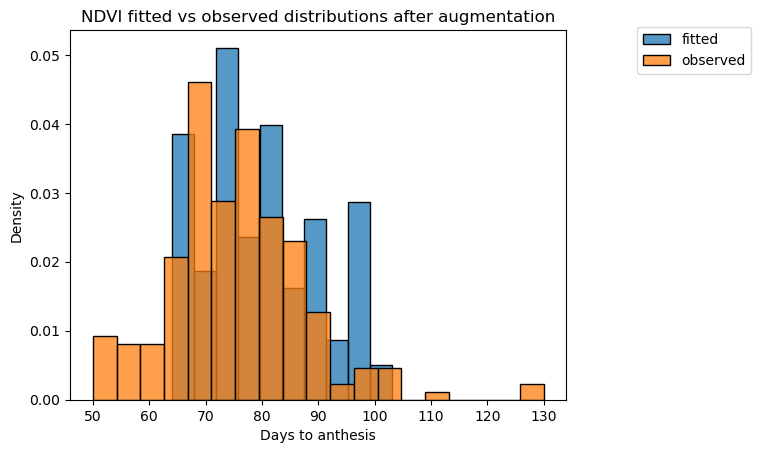

In [21]:
#temp_NDVI_series_SSA = torch.swapaxes(torch.stack((temp_series_SSA, photoperiod_series_SSA, NDVI_series_SSA, day_series_SSA, year_series_SSA, id_series_SSA)), 0, 1)
#save_name = 'CCNN_SAT_pp_KG'
#bce = True
#CNN = True
#model = Causal_CNN_Classifier_KG(input_dim, hidden_dim, num_layers, output_dim, KG = True)
n_channels = 3
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(labelled_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.1)
#train_dl_SSA, val_dl_SSA = augment_dl(train_dl_SSA, val_dl_SSA, max_shift = max_shift, noise_magnitude = 0, scale_magnitude = 0, num_augs = 0)
train_dl_DE, val_dl_DE = train_test_dl_from_tensors(labelled_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels, train_proportion=0.1)
#train_dl_DE, val_dl_DE = augment_dl(train_dl_DE, val_dl_DE, max_shift = max_shift, noise_magnitude = 0, scale_magnitude = 0, num_augs = 0)
plot_from_saved(save_name, model, val_dl_SSA, method = 'histogram', bce=bce, CNN=CNN, MMD=MMD, title = 'NDVI fitted vs observed distributions after augmentation')#

In [36]:
epochs = 10
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = CNN, bce=bce, MMD=MMD, MMD_loss=MMD_loss)

RuntimeError: all elements of input should be between 0 and 1

OrderedDict([('u0', tensor([1.])), ('u1', tensor([-0.5424])), ('u2', tensor([0.1531])), ('u3', tensor([-0.7744])), ('p0', tensor([14.0630])), ('fc2.weight', tensor([[-0.1301,  0.1628,  0.1195, -0.2119,  0.0585,  0.0264, -0.2048, -0.1819,
          0.2113, -0.1679, -0.1622, -0.0827, -0.0134,  0.0316,  0.1547,  0.2051]])), ('fc2.bias', tensor([-0.0084])), ('conv1.weight', tensor([[[ 0.0147,  0.1884],
         [-0.1640, -0.3069],
         [-0.2271, -0.1299]],

        [[ 0.5107,  0.5280],
         [-0.2140,  0.1730],
         [-0.2319,  0.2701]],

        [[-0.4180, -1.0861],
         [-0.0411, -0.3468],
         [ 0.0446, -0.0686]],

        [[-0.2464, -0.3897],
         [ 0.2619, -0.2886],
         [-0.3638,  0.1960]],

        [[ 0.5647,  0.8449],
         [ 0.1002,  0.0944],
         [-0.2837,  0.3076]],

        [[-0.5439, -0.7296],
         [-0.3334, -0.0043],
         [ 0.3558, -0.3294]],

        [[-0.2475, -0.3221],
         [-0.2375, -0.2911],
         [ 0.1258, -0.1417]],

    

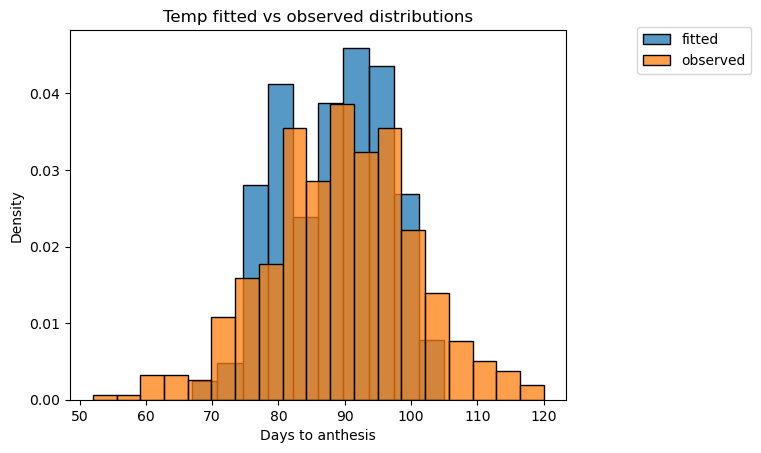

In [52]:
#temp_NDVI_series_SSA = torch.swapaxes(torch.stack((temp_series_SSA, photoperiod_series_SSA, NDVI_series_SSA, day_series_SSA, year_series_SSA, id_series_SSA)), 0, 1)
#save_name = 'CCNN_SAT_pp_KG'
#bce = True
#CNN = True
#model = Causal_CNN_Classifier_KG(input_dim, hidden_dim, num_layers, output_dim, KG = True)
n_channels = 3
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(labelled_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.1)
#train_dl_SSA, val_dl_SSA = augment_dl(train_dl_SSA, val_dl_SSA, max_shift = max_shift, noise_magnitude = 0, scale_magnitude = 0, num_augs = 0)
train_dl_DE, val_dl_DE = train_test_dl_from_tensors(labelled_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels, train_proportion=0.1)
#train_dl_DE, val_dl_DE = augment_dl(train_dl_DE, val_dl_DE, max_shift = max_shift, noise_magnitude = 0, scale_magnitude = 0, num_augs = 0)
plot_from_saved(save_name_temp, model_temp, val_dl_temp, method = 'histogram', bce=bce, CNN=CNN, MMD=MMD, title = 'Temp fitted vs observed distributions')#

0 0.6960809302854014 0.694514274597168
5 0.6399930571461772 0.6240007877349854
10 0.42877162501707183 0.39336368441581726
15 0.23464546499999014 0.27941709756851196
20 0.19941577872077187 0.20226480066776276
25 0.19390126956360682 0.19064861536026
30 0.18819512402290825 0.19039583206176758
35 0.18324758791989024 0.19093596935272217
40 0.180236021732236 0.1880197823047638
45 0.17830952666290514 0.18539971113204956
50 0.17723800913318172 0.18461351096630096
55 0.17634132971147914 0.1839665174484253
60 0.1755319254902693 0.18412594497203827
65 0.1746330465916749 0.18369914591312408
70 0.17302225955895015 0.1849314421415329
75 0.1715547421148845 0.18137817084789276
80 0.1705068241763901 0.1781356781721115
85 0.16963954007887577 0.18265599012374878
90 0.16902333424314037 0.18334496021270752
95 0.16817794257140423 0.18604105710983276


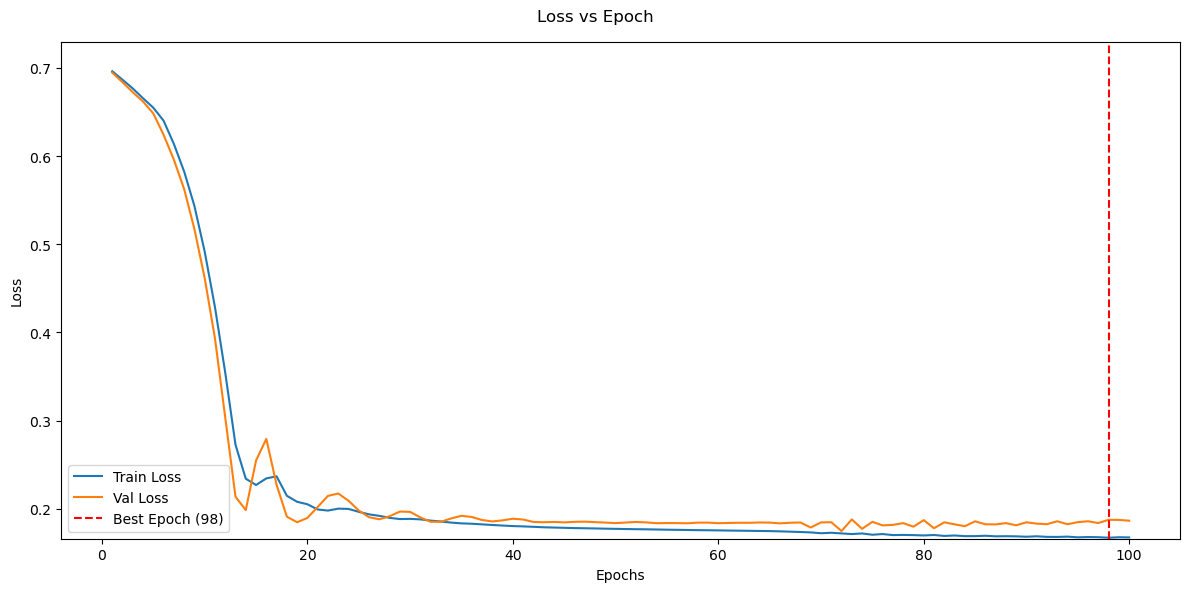

In [491]:
bs = 500
n_channels = 1
#temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE)), 0, 1)#, NDVI_series_DE
#temp_NDVI_series_DE = torch.swapaxes(temp_NDVI_series_DE, 2, 1)
max_shift = 20
labelled_NDVI_series_SSA2 = labelled_NDVI_series_SSA[:, :, :(160 - max_shift)] 

train_dl, val_dl = train_test_dl_from_tensors(labelled_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = 3, train_proportion=0.8)
train_dl, val_dl = augment_dl(train_dl, val_dl, max_shift = max_shift, noise_magnitude = 0, scale_magnitude = 0.2, num_augs = 3, extra_factor=0.01, extra_tensor=labelled_NDVI_series_SSA2)

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
num_layers = 2 #actual value * 7
output_dim = 1  # Example: 5 classes


save_name = 'CCNN_SAT_SSA'

bce = True
CNN = True
MMD = False

model = Causal_CNN_Classifier_KG(input_dim, hidden_dim, num_layers, output_dim, KG = False, MMD=MMD)
#for param in [model.p0, model.u0, model.u1, model.u2, model.u3]:#[model.u2]: #
#    param.requires_grad = False

# Loss function and optimizer
criterion = nn.BCELoss() #nn.NLLLoss()  # For multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)#, weight_decay = 0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

epochs = 100
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = CNN, bce=bce, MMD=MMD)#, MMD_loss=MMD_loss)

0 0.29247917529645856 0.28173816204071045
5 0.28899469382160314 0.28059154748916626
10 0.2861819923906536 0.2799237370491028
15 0.28389336185140923 0.27950793504714966
20 0.28201933925623424 0.2792913317680359
25 0.2804780702342044 0.2792709171772003
30 0.2792049574327993 0.27941423654556274
35 0.2781482404404944 0.279666930437088
40 0.2772661016865091 0.27998560667037964
45 0.27652526409416406 0.2803475856781006
50 0.27589882550003764 0.2807405889034271
55 0.2753647174481507 0.28115254640579224
60 0.2749044444862303 0.2815711498260498
65 0.2745024034610161 0.2819868326187134
70 0.27414496750622 0.2823929190635681
75 0.2738190103363205 0.2827834486961365
80 0.27350739676218766 0.2831486761569977
85 0.27317490469623396 0.28346672654151917
90 0.2726935682060954 0.28363144397735596
95 0.27097085216543176 0.2829101085662842


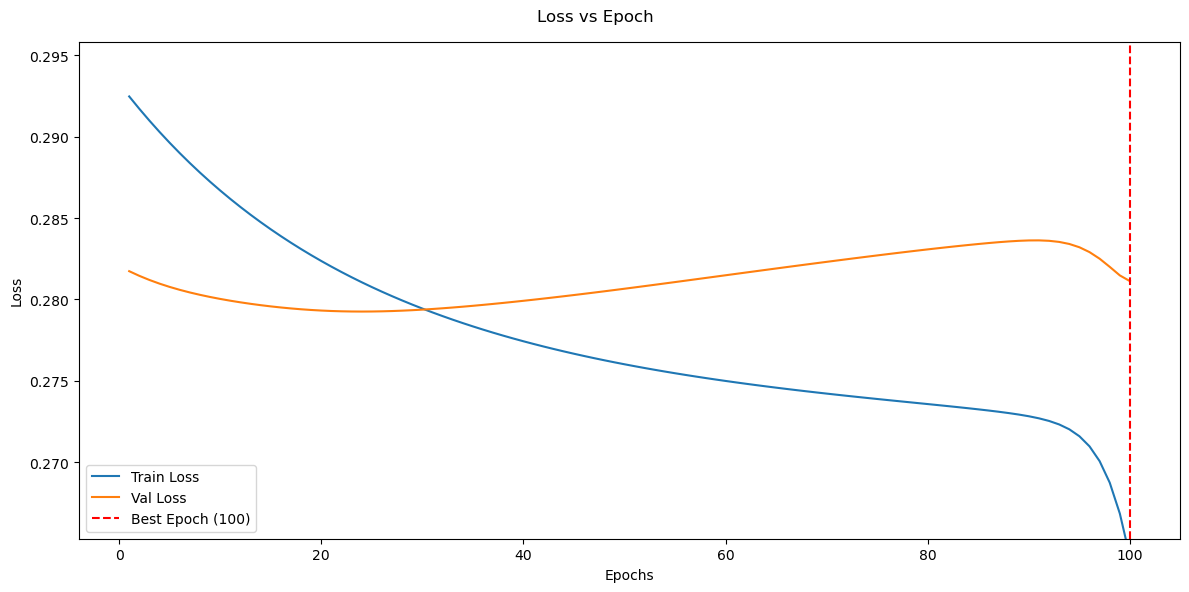

In [490]:
epochs = 100
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = CNN, bce=bce, MMD=MMD)#, MMD_loss=MMD_loss)

OrderedDict([('u0', tensor([1.])), ('u1', tensor([0.])), ('u2', tensor([0.])), ('u3', tensor([0.])), ('p0', tensor([13.])), ('fc2.weight', tensor([[ 0.2257, -0.2469,  0.1304,  0.0018,  0.0430,  0.1117, -0.2366, -0.0241]])), ('fc2.bias', tensor([-0.0556])), ('conv1.weight', tensor([[[-0.3992,  0.4668]],

        [[-0.3074, -0.2995]],

        [[ 0.3793,  0.7559]],

        [[-0.3766,  0.6007]],

        [[ 0.7310,  0.4135]],

        [[-0.6840, -0.6872]],

        [[ 0.1805,  0.6611]],

        [[-0.2561,  0.3112]]])), ('conv1.bias', tensor([-0.1619, -0.6158, -0.5290, -0.1289,  0.0346, -0.0996, -0.1474,  0.0492])), ('conv2.weight', tensor([[[-0.0687,  0.2263],
         [-0.0669, -0.1484],
         [-0.1151,  0.1482],
         [ 0.1521,  0.2374],
         [ 0.0664, -0.0659],
         [ 0.0933,  0.0859],
         [ 0.1855,  0.1733],
         [-0.1133, -0.0183]],

        [[-0.0445,  0.1309],
         [ 0.1008, -0.1057],
         [ 0.4552,  0.5406],
         [-0.0028,  0.1672],
         [ 

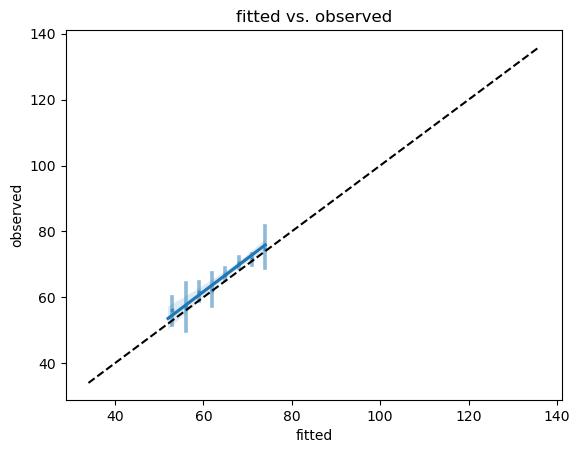

In [493]:
#temp_NDVI_series_SSA = torch.swapaxes(torch.stack((temp_series_SSA, photoperiod_series_SSA, NDVI_series_SSA, day_series_SSA, year_series_SSA, id_series_SSA)), 0, 1)
#save_name = 'CCNN_SAT_pp_KG'
#bce = True
#CNN = True
#model = Causal_CNN_Classifier_KG(input_dim, hidden_dim, num_layers, output_dim, KG = True)
n_channels = 3
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(labelled_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.1)
#train_dl_SSA, val_dl_SSA = augment_dl(train_dl_SSA, val_dl_SSA, max_shift = max_shift, noise_magnitude = 0, scale_magnitude = 0, num_augs = 0)
train_dl_DE, val_dl_DE = train_test_dl_from_tensors(labelled_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels, train_proportion=0.1)
train_dl_DE, val_dl_DE = augment_dl(train_dl_DE, val_dl_DE, max_shift = max_shift, noise_magnitude = 0, scale_magnitude = 0, num_augs = 0)
plot_from_saved(save_name, model, train_dl, method = 'regression', bce=bce, CNN=CNN, MMD=MMD)#

In [15]:
temp_NDVI_series_DE.shape

torch.Size([15308, 10, 163])

In [83]:
criterion.weights

tensor([1.6000, 1.5950, 1.5900, 1.5850, 1.5800, 1.5750, 1.5700, 1.5650, 1.5600,
        1.5550, 1.5500, 1.5450, 1.5400, 1.5350, 1.5300, 1.5250, 1.5200, 1.5150,
        1.5100, 1.5050, 1.5000, 1.4950, 1.4900, 1.4850, 1.4800, 1.4750, 1.4700,
        1.4650, 1.4600, 1.4550, 1.4500, 1.4450, 1.4400, 1.4350, 1.4300, 1.4250,
        1.4200, 1.4150, 1.4100, 1.4050, 1.4000, 1.3950, 1.3900, 1.3850, 1.3800,
        1.3750, 1.3700, 1.3650, 1.3600, 1.3550, 1.3500, 1.3450, 1.3400, 1.3350,
        1.3300, 1.3250, 1.3200, 1.3150, 1.3100, 1.3050, 1.3000, 1.2950, 1.2900,
        1.2850, 1.2800, 1.2750, 1.2700, 1.2650, 1.2600, 1.2550, 1.2500, 1.2450,
        1.2400, 1.2350, 1.2300, 1.2250, 1.2200, 1.2150, 1.2100, 1.2050, 1.2000,
        1.1950, 1.1900, 1.1850, 1.1800, 1.1750, 1.1700, 1.1650, 1.1600, 1.1550,
        1.1500, 1.1450, 1.1400, 1.1350, 1.1300, 1.1250, 1.1200, 1.1150, 1.1100,
        1.1050, 1.1000, 1.0950, 1.0900, 1.0850, 1.0800, 1.0750, 1.0700, 1.0650,
        1.0600, 1.0550, 1.0500, 1.0450, 

0 0.11145662298393978 0.1332467794418335
5 0.11566674539794429 0.11668350547552109
10 0.12122713797236036 0.12363637238740921
15 0.12042870103287195 0.12429183721542358
20 0.11953569411604628 0.12447915971279144
25 0.11898677041095256 0.12377330660820007
30 0.11863698347348783 0.12322971969842911
35 0.11834406100541182 0.12274711579084396
40 0.11797672151151624 0.12218403816223145
45 0.11757156995069912 0.12165440618991852
50 0.11713640688140352 0.12112937867641449
55 0.1166410116802894 0.1206306517124176
60 0.11608897313390133 0.12002267688512802
65 0.11543554587585292 0.11926953494548798
70 0.114667963656823 0.11842960864305496
75 0.11375635705646092 0.11742211878299713
80 0.11267063212554268 0.11622006446123123
85 0.11139151194697357 0.1148160770535469
90 0.10992261122050294 0.11327424645423889
95 0.10871201233642735 0.11276111751794815


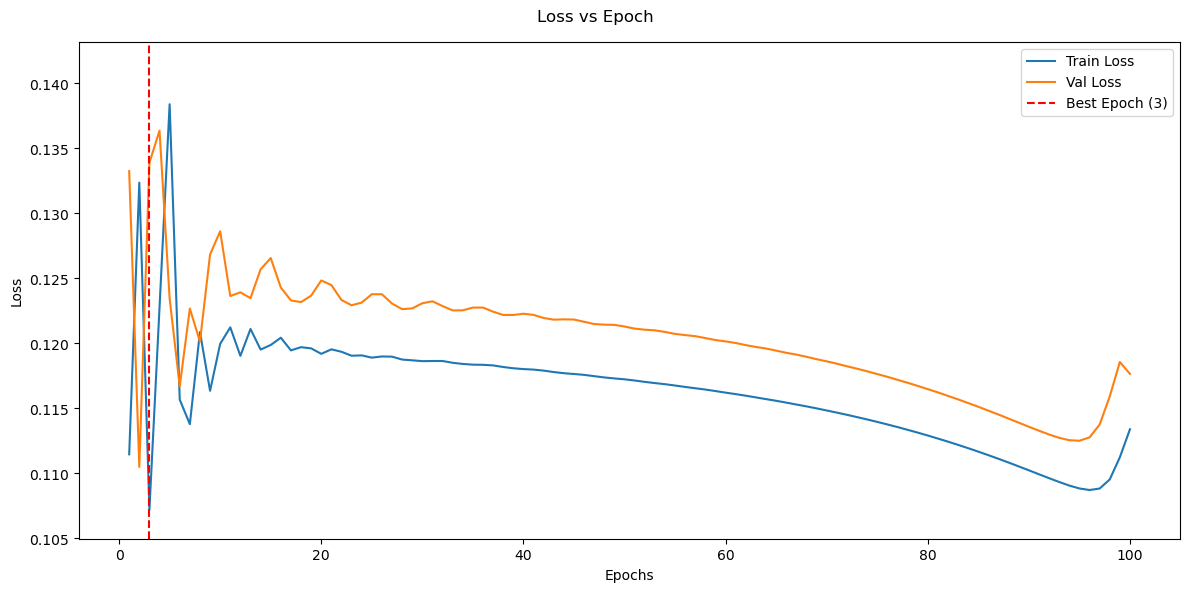

In [149]:
epochs = 50
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = CNN, bce=bce, MMD=True, MMD_loss=MMD_loss)

In [41]:
k_folds=5
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
model_class = Causal_CNN_Classifier_KG
savename = 'CCNN_SAT_pp_KG'
epochs = 200
bs = 500
input_dim = 4
hidden_dim = 8
num_layers = 2
output_dim = 1
KG = True
MMD = False
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG, MMD)
loss_values, R2s, Biases, Variances = K_fold_transfer(k_folds, train_ds, Causal_CNN_Classifier_KG, savename, epochs, bs, model_args, lr = 0.01, savename_prefix = 'KFold', freeze_params = False, loss = 'BCE', CNN=True, bce=True)

Fold 1


RuntimeError: Error(s) in loading state_dict for Causal_CNN_Classifier_KG:
	Missing key(s) in state_dict: "fc_u0_1.weight", "fc_u0_1.bias", "fc_u0_2.weight", "fc_u0_2.bias", "fc_u0_3.weight", "fc_u0_3.bias", "fc_u1_1.weight", "fc_u1_1.bias", "fc_u1_2.weight", "fc_u1_2.bias", "fc_u1_3.weight", "fc_u1_3.bias", "fc_u2_1.weight", "fc_u2_1.bias", "fc_u2_2.weight", "fc_u2_2.bias", "fc_u2_3.weight", "fc_u2_3.bias". 

In [55]:
np.mean(np.array(Biases)**2)

1.5297769

OrderedDict([('u0', tensor([1.])), ('u1', tensor([-0.2771])), ('u2', tensor([0.2531])), ('u3', tensor([-0.8691])), ('p0', tensor([13.])), ('fc2.weight', tensor([[-0.5556,  0.4075, -0.3452, -1.1148, -0.2799,  0.0553,  3.8453, -0.5872]])), ('fc2.bias', tensor([-0.3326])), ('conv1.weight', tensor([[[ 0.7735,  0.6957],
         [ 0.2131, -0.1110],
         [ 0.1006,  0.3372],
         [ 0.3315, -0.2102]],

        [[ 1.1034,  1.6496],
         [ 0.0834,  0.2939],
         [ 0.4053,  0.5494],
         [-0.2446, -0.0261]],

        [[-0.5924, -0.3220],
         [-0.1689, -0.4543],
         [-0.2589, -0.6415],
         [-0.3192, -0.0667]],

        [[ 0.0223,  0.0262],
         [ 0.2649,  0.1036],
         [ 0.5895,  0.6078],
         [ 0.0358,  0.4279]],

        [[-1.0386, -1.3818],
         [-0.0158, -0.1231],
         [ 0.7919,  0.5311],
         [ 0.2731,  0.0533]],

        [[ 0.0677,  0.5930],
         [ 0.1009,  0.2856],
         [ 0.3657,  0.6059],
         [ 0.1074,  0.1429]],

    

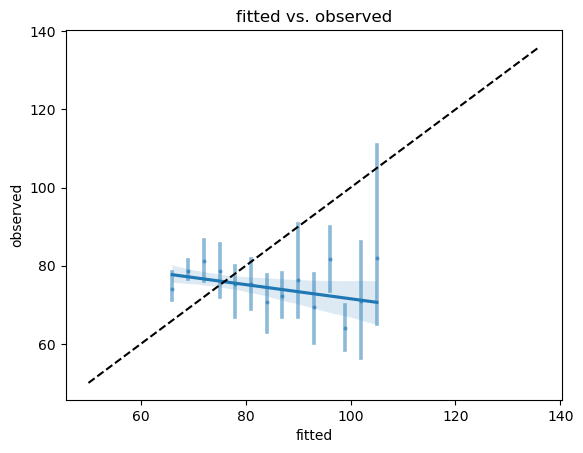

In [15]:
#temp_NDVI_series_SSA = torch.swapaxes(torch.stack((temp_series_SSA, photoperiod_series_SSA, NDVI_series_SSA, day_series_SSA, year_series_SSA, id_series_SSA)), 0, 1)
#save_name = 'CCNN_SAT_pp_KG'
#bce = True
#CNN = True
#model = Causal_CNN_Classifier_KG(input_dim, hidden_dim, num_layers, output_dim, KG = True)
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.1)
train_dl_DE, val_dl_DE = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels, train_proportion=0.1)
plot_from_saved(save_name, model, val_dl_SSA, method = 'regression', bce=bce, CNN=CNN, MMD=True)#

In [90]:
result

tensor([0., 0., 0., 0.])

In [82]:
result

tensor([5., 5., 5., 5.])

In [112]:
arr = torch.Tensor(np.array([torch.arange(0 + jump, arr.shape[1] + jump).float() for jump in [-10, 10, -3, 60]]))
mindex_at_0(arr)

tensor([10.,  0.,  3.,  0.])

In [109]:
arr

tensor([[-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.],
        [ 10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.],
        [  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.],
        [ 60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.]])

In [ ]:
bs = 500
n_channels = 4

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 16
num_layers = 2
output_dim = 1  # Example: 5 classes
KG = False

epochs = 150
#temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE)), 0, 1)#, photoperiod_series_DE
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, train_proportion=1)
k_folds = 5
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG)

model_class = Causal_CNN_Classifier_KG

loss_values_raw, R2s_raw, Biases_raw, Variances_raw = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, model_args, savename_prefix = 'KFold', freeze_params=True, loss='BCE', bce=True, CNN=True, lr=0.01)

Fold 1
Loss: 0.08472798699587077
Fold 2
Loss: 0.08380358555395406
Fold 3
Loss: 0.08137535114395227
Fold 4
Loss: 0.0822068857820414
Fold 5
Loss: 0.08096801471842059


In [13]:
print_results(loss_values_raw, R2s_raw, Biases_raw, Variances_raw, title = 'Causal CNN with KG')

#### Causal CNN with KG ####
loss 0.08602906912565231 +/- 0.0017666232950732043
R2 0.4957298517227173 +/- 0.011134634665029512
Bias 3.143342971801758 +/- 1.8384490568151213
Variance 65.46676712036133 +/- 5.301150184748136


In [24]:
print_results(loss_values_raw, R2s_raw, Biases_raw, Variances_raw, title = 'Causal CNN with KG')

#### Causal CNN with KG ####
loss 0.08135979771614074 +/- 0.0014518389680607741
R2 0.551973295211792 +/- 0.009248979280957144
Bias 0.49621304869651794 +/- 0.22074940702617724
Variance 63.76042785644531 +/- 1.1013022561824086


In [19]:
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
Bias_score = np.mean(np.array(Biases_raw)**2)
Bias_stde = np.std(np.array(Biases_raw)**2)/np.sqrt(5)
Variance_score = np.mean(Variances_raw)
Variance_stde = np.std(Variances_raw)/np.sqrt(5)
print(f'#### Causal CNN no KG ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}\nBias {Bias_score} +/- {Bias_stde}\nVariance {Variance_score} +/- {Variance_stde}')

#### Causal CNN no KG ####
loss 0.0829683005809784 +/- 0.0023356553205011584
R2 0.5423917055130005 +/- 0.01801321849186073
Bias 1.4350961446762085 +/- 1.0249130391623942
Variance 67.46737594604492 +/- 1.8934418222478935


In [30]:
bs = 500
n_channels = 4

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 4
num_layers = 1
output_dim = 1  # Example: 5 classes
KG = False

epochs = 2500
#temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE)), 0, 1)#, photoperiod_series_DE
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
k_folds = 5
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG)

model_class = Causal_CNN_Classifier_KG

loss_values_SSA, R2s_SSA, Biases_SSA, Variances_SSA = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, model_args, savename_prefix = 'KFold', freeze_params=True, loss='BCE', bce=True, CNN=True)

Fold 1
Loss: 0.08623763173818588
Fold 2
Loss: 0.0916554406285286
Fold 3
Loss: 0.0827585905790329
Fold 4
Loss: 0.08741223067045212
Fold 5
Loss: 0.07524872571229935


In [33]:
bs = 500
n_channels = 4

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 4
num_layers = 1
output_dim = 1  # Example: 5 classes
KG = True

epochs = 2500
#temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE)), 0, 1)#, photoperiod_series_DE
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
k_folds = 5
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG)

model_class = Causal_CNN_Classifier_KG

loss_values_SSA_KG, R2s_SSA_KG, Biases_SSA_KG, Variances_SSA_KG = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, model_args, savename_prefix = 'KFold', freeze_params=True, loss='BCE', bce=True, CNN=True)

Fold 1
Loss: 0.09451353549957275
Fold 2
Loss: 0.09396106004714966
Fold 3
Loss: 0.08914792537689209
Fold 4
Loss: 0.0805366188287735
Fold 5
Loss: 0.08512367308139801


In [32]:
print_results(loss_values_SSA, R2s_SSA, Biases_SSA, Variances_SSA, title = 'Causal CNN SSA no KG')

#### Causal CNN SSA no KG ####
loss 0.126229989528656 +/- 0.0246615596276387
R2 0.42439320087432864 +/- 0.05920390117292838
Bias 5.195734024047852 +/- 3.3216635243565493
Variance 64.90566024780273 +/- 4.162811210059701


In [34]:
print_results(loss_values_SSA_KG, R2s_SSA_KG, Biases_SSA_KG, Variances_SSA_KG, title = 'Causal CNN SSA KG')

#### Causal CNN SSA KG ####
loss 0.11093353480100632 +/- 0.007850556949434597
R2 0.413174045085907 +/- 0.052062620811368795
Bias 3.0364651679992676 +/- 2.001748876704373
Variance 55.041561889648435 +/- 2.1885512147430295


In [12]:
def print_results(loss_values_raw, R2s_raw, Biases_raw, Variances_raw, title = 'Causal CNN'):
    score = np.mean(loss_values_raw)
    score_stde = np.std(loss_values_raw)/np.sqrt(5)
    R2_score = np.mean(R2s_raw)
    R2_stde = np.std(R2s_raw)/np.sqrt(5)
    Bias_score = np.mean(np.array(Biases_raw)**2)
    Bias_stde = np.std(np.array(Biases_raw)**2)/np.sqrt(5)
    Variance_score = np.mean(Variances_raw)
    Variance_stde = np.std(Variances_raw)/np.sqrt(5)
    print(f'#### {title} ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}\nBias {Bias_score} +/- {Bias_stde}\nVariance {Variance_score} +/- {Variance_stde}')

In [ ]:
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
Bias_score = np.mean(np.array(Biases_raw)**2)
Bias_stde = np.std(np.array(Biases_raw)**2)/np.sqrt(5)
Variance_score = np.mean(Variances_raw)
Variance_stde = np.std(Variances_raw)/np.sqrt(5)
print(f'#### Causal CNN no KG SSA ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}\nBias {Bias_score} +/- {Bias_stde}\nVariance {Variance_score} +/- {Variance_stde}')

In [97]:
def fit_for_kf(epochs, model, loss_func, opt, train_dl, valid_dl, save_name = 'best_model', plot_opt = False, CNN=False, bce=False):
    # Variables to store training history
    train_losses = []
    val_losses = []
    best_loss = 50000
    best_epoch = 0

    for epoch in range(epochs):
        running_loss = 0.0
        running_samples = 0
        model.train()

        for xb, yb in train_dl:
            batch_loss, batch_len = loss_batch(model, loss_func, xb, yb, opt, CNN=CNN, bce=bce, MMD = MMD, MMD_loss = MMD_loss)
            running_loss += batch_loss*batch_len
            running_samples += batch_len

        train_loss = running_loss/running_samples
        
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb, CNN=CNN, bce=bce, MMD = MMD, MMD_loss = MMD_loss) for xb, yb in valid_dl]
            )
            
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        # Save the best model (based on validation accuracy)
        if train_loss < best_loss:
            best_loss = train_loss
            best_epoch = epoch + 1
            best_model_state = deepcopy(model.state_dict())
            model_loss = val_loss

        #Save the model at the last epoch
        if epoch == epochs - 1:
            model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
            model_path = os.path.join(model_dir, save_name + ".pt")
            torch.save({'epoch': best_epoch, 'model_state_dict': best_model_state}, model_path)
        #if epoch % 5 == 0:
        #    print(epoch, train_loss, val_loss)
    #print(f'Loss: {best_loss}')
    if plot_opt:
        plot_train_val_loss(epochs, train_losses, val_losses, best_epoch)
    return model_loss

In [35]:
input_dim = 4
savename = 'CCNN_SAT_pp_KG' #'LSTM_KG_SAT_pp'save_name = 'CCNN_SAT_pp_KG'
model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
model_path = os.path.join(model_dir, savename + ".pt")
checkpoint = torch.load(model_path, weights_only=True)
model = Causal_CNN_Classifier_KG(input_dim, hidden_dim, num_layers, output_dim, KG =True, MMD=False) #LSTMClassifier_KG(input_dim, hidden_dim, num_layers, output_dim)
model.load_state_dict(checkpoint['model_state_dict'])
for param in model.parameters():
    param.requires_grad = False
for param in [model.u0, model.u1, model.u2, model.u3, model.p0]:
    param.requires_grad = True
#for param in model.fc.parameters():
#    param.requires_grad = False
#for param in model.lstm.parameters():
#    param.requires_grad = False
#for param in [model.u0, model.u1, model.u2, model.u3, model.p0]:
#    param.requires_grad = True
#for param in [model.u2]: #[model.u1, model.u2, model.u3]:
#    param.requires_grad = False


In [30]:
k_folds=5
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
model_class =Causal_CNN_Classifier_KG
savename = 'CCNN_SAT_pp_KG'
epochs = 200
bs = 500
input_dim = 4
hidden_dim = 16
num_layers = 2
output_dim = 1
KG = True
MMD = False
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG, MMD)
loss_values, R2s, Biases, Variances = K_fold_transfer(k_folds, train_ds, model_class, savename, epochs, bs, model_args, lr = 0.01, savename_prefix = 'KFold', freeze_params = False, loss = 'BCE', CNN=True, bce=True)

Fold 1
Loss: 0.12794816493988037
Fold 2
Loss: 0.132425457239151
Fold 3
Loss: 0.10302477329969406
Fold 4
Loss: 0.12475799024105072
Fold 5
Loss: 0.1287185251712799


0 0.1253299117088318 0.14182861149311066
5 0.10630413144826889 0.13517077267169952
10 0.10732317715883255 0.13986842334270477
15 0.10595294833183289 0.13507549464702606
20 0.10439476370811462 0.13843734562397003
25 0.10400751978158951 0.13514241576194763
30 0.10419057309627533 0.13539867103099823
35 0.10426440089941025 0.13645830750465393
40 0.10416539013385773 0.13506557047367096
45 0.10406641662120819 0.13632187247276306
50 0.10400965064764023 0.13521549105644226
55 0.10398709774017334 0.13594388961791992
60 0.10397831350564957 0.1353609263896942
65 0.10397351533174515 0.13574284315109253
70 0.103970468044281 0.13541951775550842
75 0.10396850854158401 0.13564927875995636
80 0.1039661169052124 0.13542576134204865
85 0.1039639264345169 0.13557963073253632
90 0.10396168380975723 0.13543511927127838
95 0.10395939648151398 0.13551656901836395
100 0.10395707190036774 0.1354425549507141
105 0.10395479947328568 0.1354522854089737
110 0.10395267605781555 0.13545124232769012
115 0.103950753808

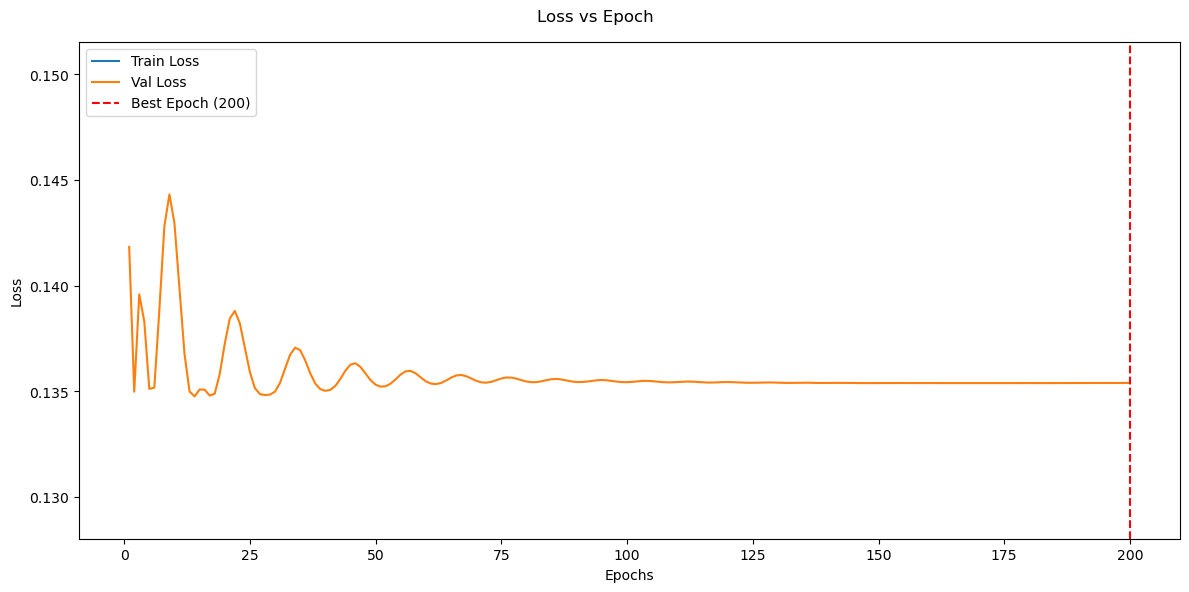

In [36]:
bs = 500
n_channels = 4
train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.5)
save_name = 'CCNN_KG_pp_SSA_TL'
# Loss function and optimizer
criterion = criterion = nn.BCELoss()#nn.NLLLoss()  # For multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

epochs = 200
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN=True, bce = True)

In [388]:
comparison_frame = get_comparison_frame(save_name, model, val_dl, bce=True, CNN=True, MMD=False, n_channels = 3)

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])


In [389]:
comparison_frame.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\model_output\\temp_CCNN_training.csv')

In [259]:
comparison_frame['fitted'] = comparison_frame['fitted'] - comparison_frame['fitted'].mean()
comparison_frame['observed'] = comparison_frame['observed'] - comparison_frame['observed'].mean()

In [260]:
r2_score(comparison_frame['observed'], comparison_frame['fitted'])

0.3123144507408142

<Axes: xlabel='fitted', ylabel='observed'>

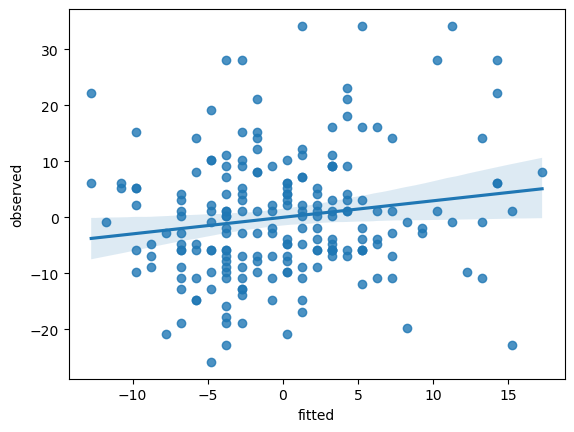

In [209]:
sns.regplot(x = 'fitted', y = 'observed', data = comparison_frame)

<Axes: xlabel='observed', ylabel='Count'>

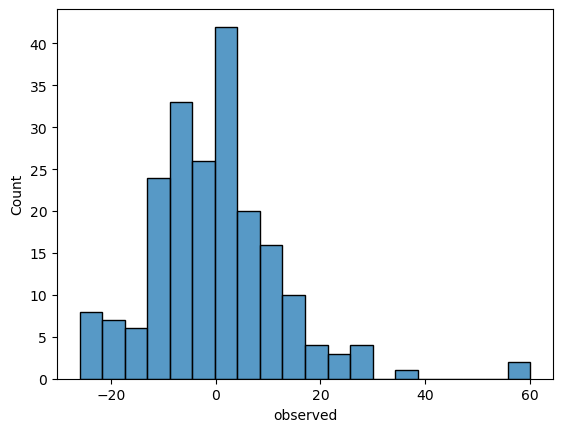

In [70]:
sns.histplot(comparison_frame['observed'])

In [46]:
def plot_residuals(comparison_frame):
    fig, axs = plt.subplots(1, 2)
    comparison_frame['residuals'] = comparison_frame['observed'] - comparison_frame['fitted']
    sns.histplot(comparison_frame['residuals'], ax = axs[0])
    maxval = max(comparison_frame['fitted'].max(), comparison_frame['residuals'].max())
    minval = min(comparison_frame['fitted'].min(), comparison_frame['residuals'].min())
    
    sns.regplot(x='fitted', y='residuals', data = comparison_frame, ax=axs[1],
                scatter_kws={'alpha':0.5, 's':4},  x_bins=np.arange(minval - 5, maxval + 5, 1),
                fit_reg = False)
    axs[1].axhline(0, color = 'black')

In [80]:
def comp_histogram(comparison_frame, title = 'Histogram fitted observed'):
    fig, ax = plt.subplots()
    sns.histplot(x='fitted', data = comparison_frame, ax=ax, label = 'fitted',
                stat = 'density')
    sns.histplot(x='observed', data = comparison_frame, ax=ax, label= 'observed',
                stat = 'density')
    ax.set_xlabel('Days to anthesis')
    ax.set_title(title)
    #ax.plot([minval, maxval], [minval, maxval], linestyle = '--', color='k')
    fig.legend(bbox_to_anchor = (1.2, 0.9))
    rsquared = r2_score(comparison_frame['observed'], comparison_frame['fitted'])
    print(f'R^2 value for model: {rsquared}')
    bias = comparison_frame['observed'].mean() - comparison_frame['fitted'].mean()
    variance_modelled = comparison_frame[f'fitted'].var()
    print(f'Bias: {bias**2}\nVariance of modelled values: {variance_modelled}')

R^2 value for model: -0.0461348295211792
Bias: 21.536816620267928
Variance of modelled values: 28.59884262084961


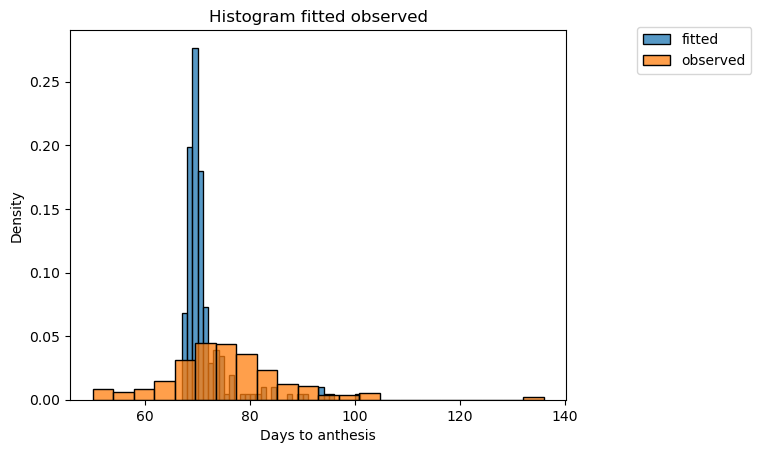

In [81]:
comp_histogram(comparison_frame)

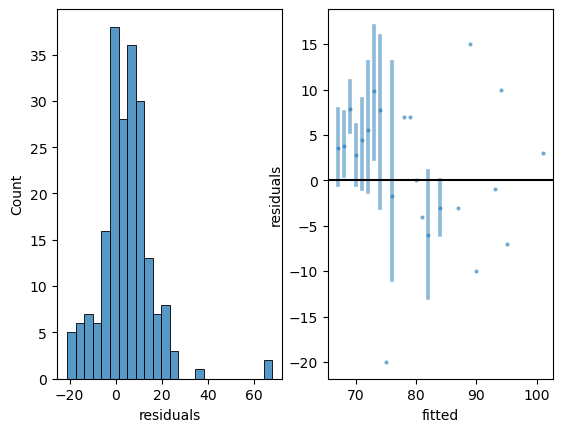

In [82]:
plot_residuals(comparison_frame)

In [ ]:
fig, axs = plt.subplots()
sns.regplot(x='fitted', y='residuals', data = cf, ax=ax,
                scatter_kws={'alpha':0.5, 's':4},  x_bins=np.arange(minval - 5, maxval + 5, 3),
                fit_reg = False)

In [49]:
comparison_frame['residuals'] = comparison_frame['observed'] - comparison_frame['fitted']
comparison_frame.loc[~((comparison_frame['fitted'] > 100)*(comparison_frame['residuals'] > 10))]#.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\overestimate.csv')
comparison_frame.loc[comparison_frame['observed'] > 120].to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\late_flowering.csv')

In [98]:
bs = 500
n_channels = 4

input_dim = n_channels # Example: 100-dimensional word embeddings
output_dim = 1  # Example: 5 classes

epochs = 30
model_class = Causal_CNN_Classifier_KG
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, train_proportion=1)

CNN = True
bce = True

k_folds = 5

for num_layers in [1, 2, 3]:
    for hidden_dim in [16]:
        CNN_args = (input_dim, hidden_dim, num_layers, output_dim)
        loss_values, R2s, Biases, Variances = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, CNN_args, savename_prefix = 'KFold', loss = 'BCE', CNN=CNN, bce=bce)
        score = np.mean(loss_values)
        score_std = np.std(loss_values)
        R2_score = np.mean(R2s)
        R2_std = np.std(R2s)
        print(f'{num_layers} layers\nhidden dim {hidden_dim}\nloss {score} +/- {score_std}\nR2 {R2_score} +/- {R2_std}')

Fold 1
Loss: 0.0886116771890529
Fold 2
Loss: 0.08836373065604436
Fold 3
Loss: 0.08951394303174352
Fold 4
Loss: 0.0882405449773102
Fold 5
Loss: 0.08888193044230566
1 layers
hidden dim 16
loss 0.09006356248548063 +/- 0.0029337343981179036
R2 0.3842145919799805 +/- 0.0316193425945896
Fold 1
Loss: 0.08861211669257428
Fold 2
Loss: 0.08848984463686453
Fold 3
Loss: 0.08975609844555536
Fold 4
Loss: 0.08975120264626958
Fold 5
Loss: 0.08916666366397281
2 layers
hidden dim 16
loss 0.0911295287568484 +/- 0.0037888759662498142
R2 0.3741725325584412 +/- 0.04534479351049852
Fold 1
Loss: 0.08924290149158369
Fold 2
Loss: 0.09043035772493943
Fold 3
Loss: 0.09061214745940353
Fold 4
Loss: 0.09035677325105906
Fold 5
Loss: 0.09013886576669533
3 layers
hidden dim 16
loss 0.09201111013619959 +/- 0.0026411091779612824
R2 0.35802420377731325 +/- 0.0321787427596478


In [99]:
for num_layers in [1]:
    for hidden_dim in [8, 16, 32]:
        CNN_args = (input_dim, hidden_dim, num_layers, output_dim)
        loss_values, R2s, Biases, Variances = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, CNN_args, savename_prefix = 'KFold', loss = 'BCE', CNN=CNN, bce=bce)
        score = np.mean(loss_values)
        score_std = np.std(loss_values)
        R2_score = np.mean(R2s)
        R2_std = np.std(R2s)
        print(f'{num_layers} layers\nhidden dim {hidden_dim}\nloss {score} +/- {score_std}\nR2 {R2_score} +/- {R2_std}')

Fold 1
Loss: 0.08871571966076906
Fold 2
Loss: 0.08948202849041796
Fold 3
Loss: 0.08887378234975064
Fold 4
Loss: 0.08866631186317508
Fold 5
Loss: 0.08997446561430894
1 layers
hidden dim 8
loss 0.0900080360546399 +/- 0.001781744888513259
R2 0.3921561360359192 +/- 0.027771960836591062
Fold 1
Loss: 0.08872808187323458
Fold 2
Loss: 0.08920831392307398
Fold 3
Loss: 0.08905069422282881
Fold 4
Loss: 0.08849793934047906
Fold 5
Loss: 0.08938197528648635
1 layers
hidden dim 16
loss 0.09003622978258721 +/- 0.0013705386912874961
R2 0.3800978422164917 +/- 0.017306412481303074
Fold 1
Loss: 0.08868540235255894
Fold 2
Loss: 0.08809042044102139
Fold 3
Loss: 0.08923776981316427
Fold 4
Loss: 0.08936428121850519
Fold 5
Loss: 0.08978191455740875
1 layers
hidden dim 32
loss 0.08911869591641473 +/- 0.002350894508984044
R2 0.3945940375328064 +/- 0.02463562727769248


In [ ]:
bs = 500
n_channels = 4

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 16
num_layers = 2
output_dim = 1  # Example: 5 classes
KG = True

epochs = 150
#temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE)), 0, 1)#, photoperiod_series_DE
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, train_proportion=1)
k_folds = 5
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG)

model_class = Causal_CNN_Classifier_KG

loss_values_raw, R2s_raw, Biases_raw, Variances_raw = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, model_args, savename_prefix = 'KFold', freeze_params=True, loss='BCE', bce=True, CNN=True)

Fold 1
Loss: 0.09318297356367111
Fold 2
Loss: 0.08788973093032837
Fold 3
Loss: 0.0820319727063179
Fold 4
Loss: 0.10063453018665314
Fold 5
Loss: 0.08032040297985077


In [ ]:
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
print(f'#### wavenet DE no SAT big data ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}')

#### wavenet DE no SAT big data ####
loss 0.08600211074215718 +/- 0.0017534131635885345
R2 0.3106345057487488 +/- 0.023533859321335185


In [ ]:
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
print(f'#### wavenet SSA ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}')

#### wavenet SSA ####
loss 0.10788502544164658 +/- 0.015933853744630414
R2 0.34511895179748536 +/- 0.04444457263756812


In [ ]:
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
print(f'#### wavenet DE no SAT ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}')

#### wavenet DE no SAT ####
loss 0.07681606709957123 +/- 0.0005721705533491635
R2 0.46258920431137085 +/- 0.02771426296112305


In [ ]:
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
print(f'#### wavenet DE ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}')

#### wavenet DE ####
loss 0.0777890920639038 +/- 0.002083252406613548
R2 0.44964544773101806 +/- 0.02450198208101182


In [111]:
bs = 500
n_channels = 4
#temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE)), 0, 1)#, NDVI_series_DE
#temp_NDVI_series_DE = torch.swapaxes(temp_NDVI_series_DE, 2, 1)
train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels, train_proportion=0.95)

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
num_layers = 2
output_dim = 1  # Example: 5 classes
KG = True


save_name = 'CCNN_SAT_pp'

bce = True
CNN = True

model = Causal_CNN_Classifier_KG(input_dim, hidden_dim, num_layers, output_dim, KG =KG)
#for param in [model.p0, model.u0, model.u1, model.u2, model.u3]:#[model.u2]: #
#    param.requires_grad = False

# Loss function and optimizer
criterion = nn.BCELoss() #nn.NLLLoss()  # For multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

epochs = 150
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = CNN, bce=bce)

0 0.7132671801355556 0.7034775018692017
5 0.35784569678981265 0.18454600870609283
10 0.14435004652344247 0.12788264453411102
15 0.12838078421285914 0.11749522387981415
20 0.12473554104338641 0.11380124092102051
25 0.12274551920122671 0.11169859021902084
30 0.11783832871492232 0.10551301389932632
35 0.10094477045376488 0.0847603976726532
40 0.0878063792907713 0.07547184824943542
45 0.08438345408120529 0.07312160730361938
50 0.08377798908812138 0.07198392599821091
55 0.0833771686794425 0.07094074785709381
60 0.08297226543807162 0.07032885402441025
65 0.08263144089375582 0.06962981820106506
70 0.08253672727549281 0.06942011415958405
75 0.08219096745519291 0.06914051622152328
80 0.08165633581564485 0.06889377534389496


KeyboardInterrupt: 

0 0.6904991139175018 0.6838299036026001
5 0.4063269587372948 0.3022230267524719
10 0.1907837125927172 0.1636435091495514
15 0.12289453623639314 0.1160309761762619
20 0.10839521000102748 0.10246682912111282
25 0.10299866752290605 0.09733667969703674
30 0.0995094221562185 0.09390465170145035
35 0.09792811027875568 0.09426847100257874
40 0.09879955520950191 0.09084177762269974
45 0.09913513965253141 0.09954384714365005
50 0.09703523661889353 0.09058978408575058
55 0.09520540649899965 0.0901157557964325
60 0.0943201813275521 0.08892688155174255
65 0.09428218178007237 0.08907714486122131
70 0.09378774862627869 0.08765809237957001
75 0.09282217221039481 0.08718078583478928
80 0.09222851972200723 0.08690068125724792
85 0.09183431315709127 0.0866362452507019
90 0.09153728270183195 0.08631827682256699
95 0.09127028040937296 0.0860113576054573
100 0.09105295856000503 0.08575599640607834
105 0.0906468344561954 0.08517592400312424
110 0.09070671736929656 0.08496306091547012
115 0.09062736212300711

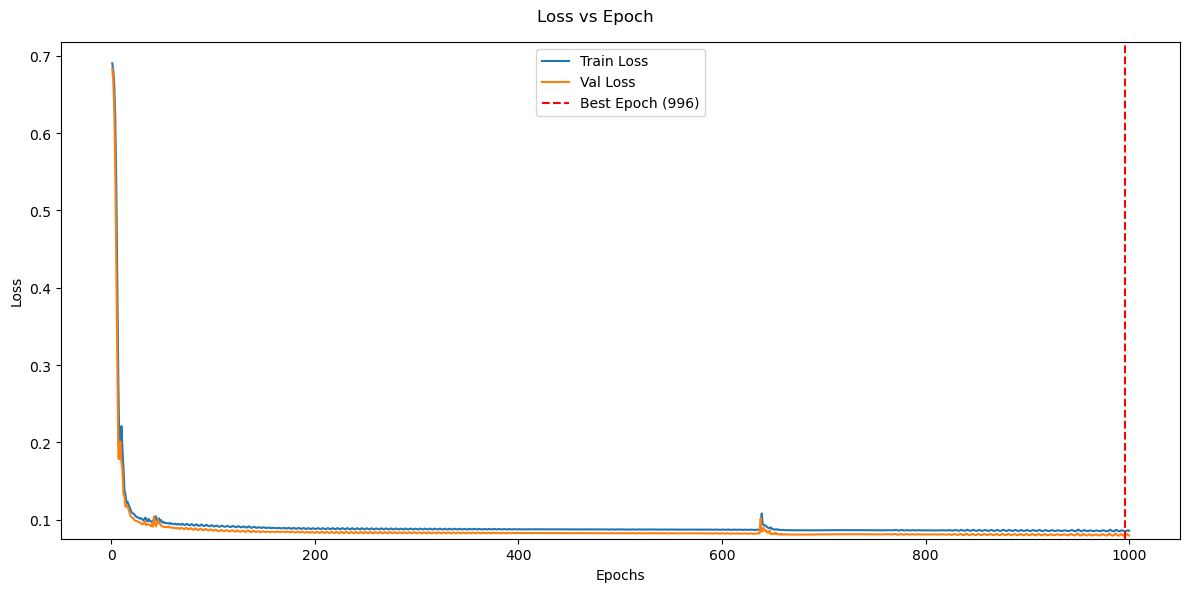

In [136]:
bs = 500
n_channels = 4
#temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE)), 0, 1)#, NDVI_series_DE
#temp_NDVI_series_DE = torch.swapaxes(temp_NDVI_series_DE, 2, 1)
train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 16
num_layers = 1
output_dim = 1  # Example: 5 classes


save_name = 'CCNN_KG_SAT_pp_small'

bce = True
CNN = True

model = Causal_CNN_Classifier_KG(input_dim, hidden_dim, num_layers, output_dim, KG =True)
#for param in [model.p0, model.u0, model.u1, model.u2, model.u3]:#[model.u2]: #
#    param.requires_grad = False

# Loss function and optimizer
criterion = nn.BCELoss() #nn.NLLLoss()  # For multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

epochs = 1000
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = CNN, bce=bce)

OrderedDict([('u0', tensor([1.])), ('u1', tensor([-0.3724])), ('u2', tensor([-0.0713])), ('u3', tensor([-0.7030])), ('p0', tensor([13.])), ('conv1.weight', tensor([[[ 1.0524,  0.6248],
         [-0.0195, -0.3831],
         [-0.4891, -0.0242],
         [-0.1708, -0.1383]],

        [[-0.1743,  0.1651],
         [ 0.3480, -0.0657],
         [ 0.2169,  0.1282],
         [-0.2930,  0.3348]],

        [[-0.0929,  0.5035],
         [ 0.3486,  0.2373],
         [ 0.0355,  0.0290],
         [ 0.1001, -0.0834]],

        [[ 0.6965,  0.7562],
         [ 0.0236,  0.0674],
         [-0.2143,  0.0623],
         [-0.1774,  0.0949]],

        [[-0.9691, -1.0699],
         [-0.0703, -0.0429],
         [ 0.1628,  0.1416],
         [-0.3148,  0.3050]],

        [[ 0.9200,  0.8582],
         [ 0.1094,  0.3992],
         [ 0.1147,  0.0977],
         [-0.1799, -0.0961]],

        [[ 0.1700,  0.5237],
         [ 0.1965,  0.0801],
         [ 0.5478,  0.2747],
         [ 0.0151, -0.0224]],

        [[ 0.3049,

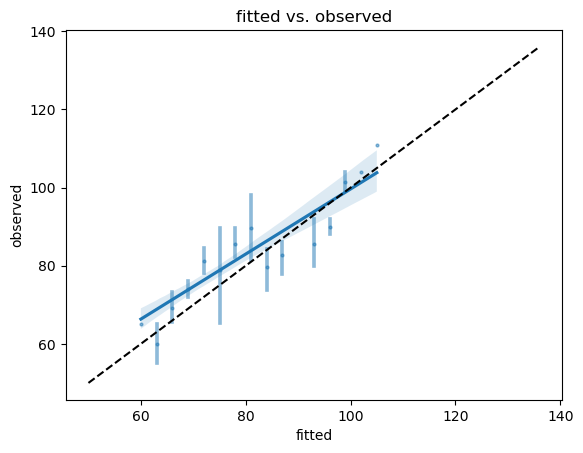

In [138]:
#save_name = 'CCNN_KG_SAT_pp_SSA' #save_name = 'CCNN_KG_SAT_pp'#'CCNN_KG_pp_SSA'#
#temp_NDVI_series_SSA = torch.swapaxes(torch.stack((temp_series_SSA, photoperiod_series_SSA, NDVI_series_SSA, day_series_SSA, year_series_SSA, id_series_SSA)), 0, 1)
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.1)
train_dl_DE, val_dl_DE = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels, train_proportion=0.1)
plot_from_saved(save_name, model, val_dl_SSA, method = 'regression', bce=bce, CNN=CNN)#

In [ ]:
ds_full = ds_inputs_DE
FAO_sorts_string = ds_full['SORTE'].str.split(' ').str.get(-1)
FAO_sorts_string = FAO_sorts_string*(1 - FAO_sorts_string.str.contains(r'[a-zA-Z]', regex=True))
FAO_sorts_string.replace('', np.nan, inplace = True)
FAO_sorts_string.fillna(0, inplace=True)
FAO_sorts_string = FAO_sorts_string.astype(np.int64)
ds_full['FAO_sort'] = FAO_sorts_string
ds_full[['SORTE', 'SILOREIFEZAHL', 'KOERNERREIFEZAHL', 'FAO_sort']]
ds_full.loc[(ds_full['SILOREIFEZAHL'] != ds_full['KOERNERREIFEZAHL'])*~pd.isna(ds_full['KOERNERREIFEZAHL'])].dropna(how='all')[['SORTE_ID', 'SORTE', 'SILOREIFEZAHL', 'KOERNERREIFEZAHL']]#.to_list()